In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib 
import seaborn as sns
import os
plt.rcParams['figure.constrained_layout.use'] = True
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10) 
matplotlib.rcParams.update({'font.size': 15})

slrpev_path = '/Users/aysetugbaozturk/Documents/eCal/SlrpEV/'
results_path = slrpev_path + 'results.csv'
sessions_path =  slrpev_path + 'Sessions2.csv'
carbon_intensity_path=slrpev_path  + "pev-operation-hil/pev-operation-hil/scripts/Python Code/Outputs/D5. Winter Summer Emissions Data.xlsx"
prices_path = slrpev_path  + 'pev-operation-hil/pev-operation-hil/scripts/Python Code/Outputs/Prices_steps_15.csv'
powers_path = slrpev_path + 'pev-operation-hil/pev-operation-hil/scripts/Python Code/Outputs/Powers_zo2535_steps15.csv'

carbon_intensity = pd.read_excel(carbon_intensity_path)
# max(Last update - deadline , 0 )
e_need = 15

################## Define the TOU Cost ##################
# off-peak 0.175  cents / kwh 
TOU_tariff = np.ones((96,)) * 17.5
## 4 pm - 9 pm peak 0.367 cents / kwh 
TOU_tariff[64:84] = 36.7
## 9 am - 2 pm super off-peak 0.49 $ / kWh  to cents / kwh
TOU_tariff[36:56] = 14.9

high_TOU = TOU_tariff * 6.6
low_TOU = TOU_tariff * 3.3
w = 3.3 
h = 2.5
import optimizer

import matplotlib

In [151]:
# os.listdir( slrpev_path+'pev-operation-hil/pev-operation-hil/scripts/Python Code/Outputs/')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# plt.rcParams['axes.linewidth'] = 1

In [152]:
# Check the power profile of the price results
# Check the sensitivty to the DCM parameters of choice
# Read Data

import json
import math
from analysis import plot_max_min_power, plot_arrival_departure

station_pow_max = 6.6 
eff = 1
interval_size_hour = 0.25
interval_size_minutes = int(60*interval_size_hour)
steps_in_hr = 4


prices = pd.read_csv(prices_path).sort_values(by='arrHour')
powers = pd.read_csv(powers_path)

high_powers = powers[powers['highPower'] == 1]
low_powers = powers[powers['highPower'] == 0]

high_prices = prices[prices['highPower'] == 1]
low_prices = prices[prices['highPower'] == 0]

high_powers.reset_index(drop=True,inplace=True)
low_powers.reset_index(drop=True,inplace=True)





In [153]:
plt.style.use(['science','ieee','high-vis'])
plt.rcParams['font.size'] = 14
w = 7/1.1
h = 3/1.1

high_vis_map = ["#0d49fb", "#e6091c", "#26eb47", "#8936df", "#fec32d", "#25d7fd"]
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 
matplotlib.rc('axes', labelsize=14)

In [154]:
print(high_prices['reg_centsPerHr'].values.mean(), high_prices['sch_centsPerHr'].values.mean())
print(low_prices['reg_centsPerHr'].values.mean(), low_prices['sch_centsPerHr'].values.mean())

233.92552504099547 216.75702354956834
136.35477043160668 144.59608405940546


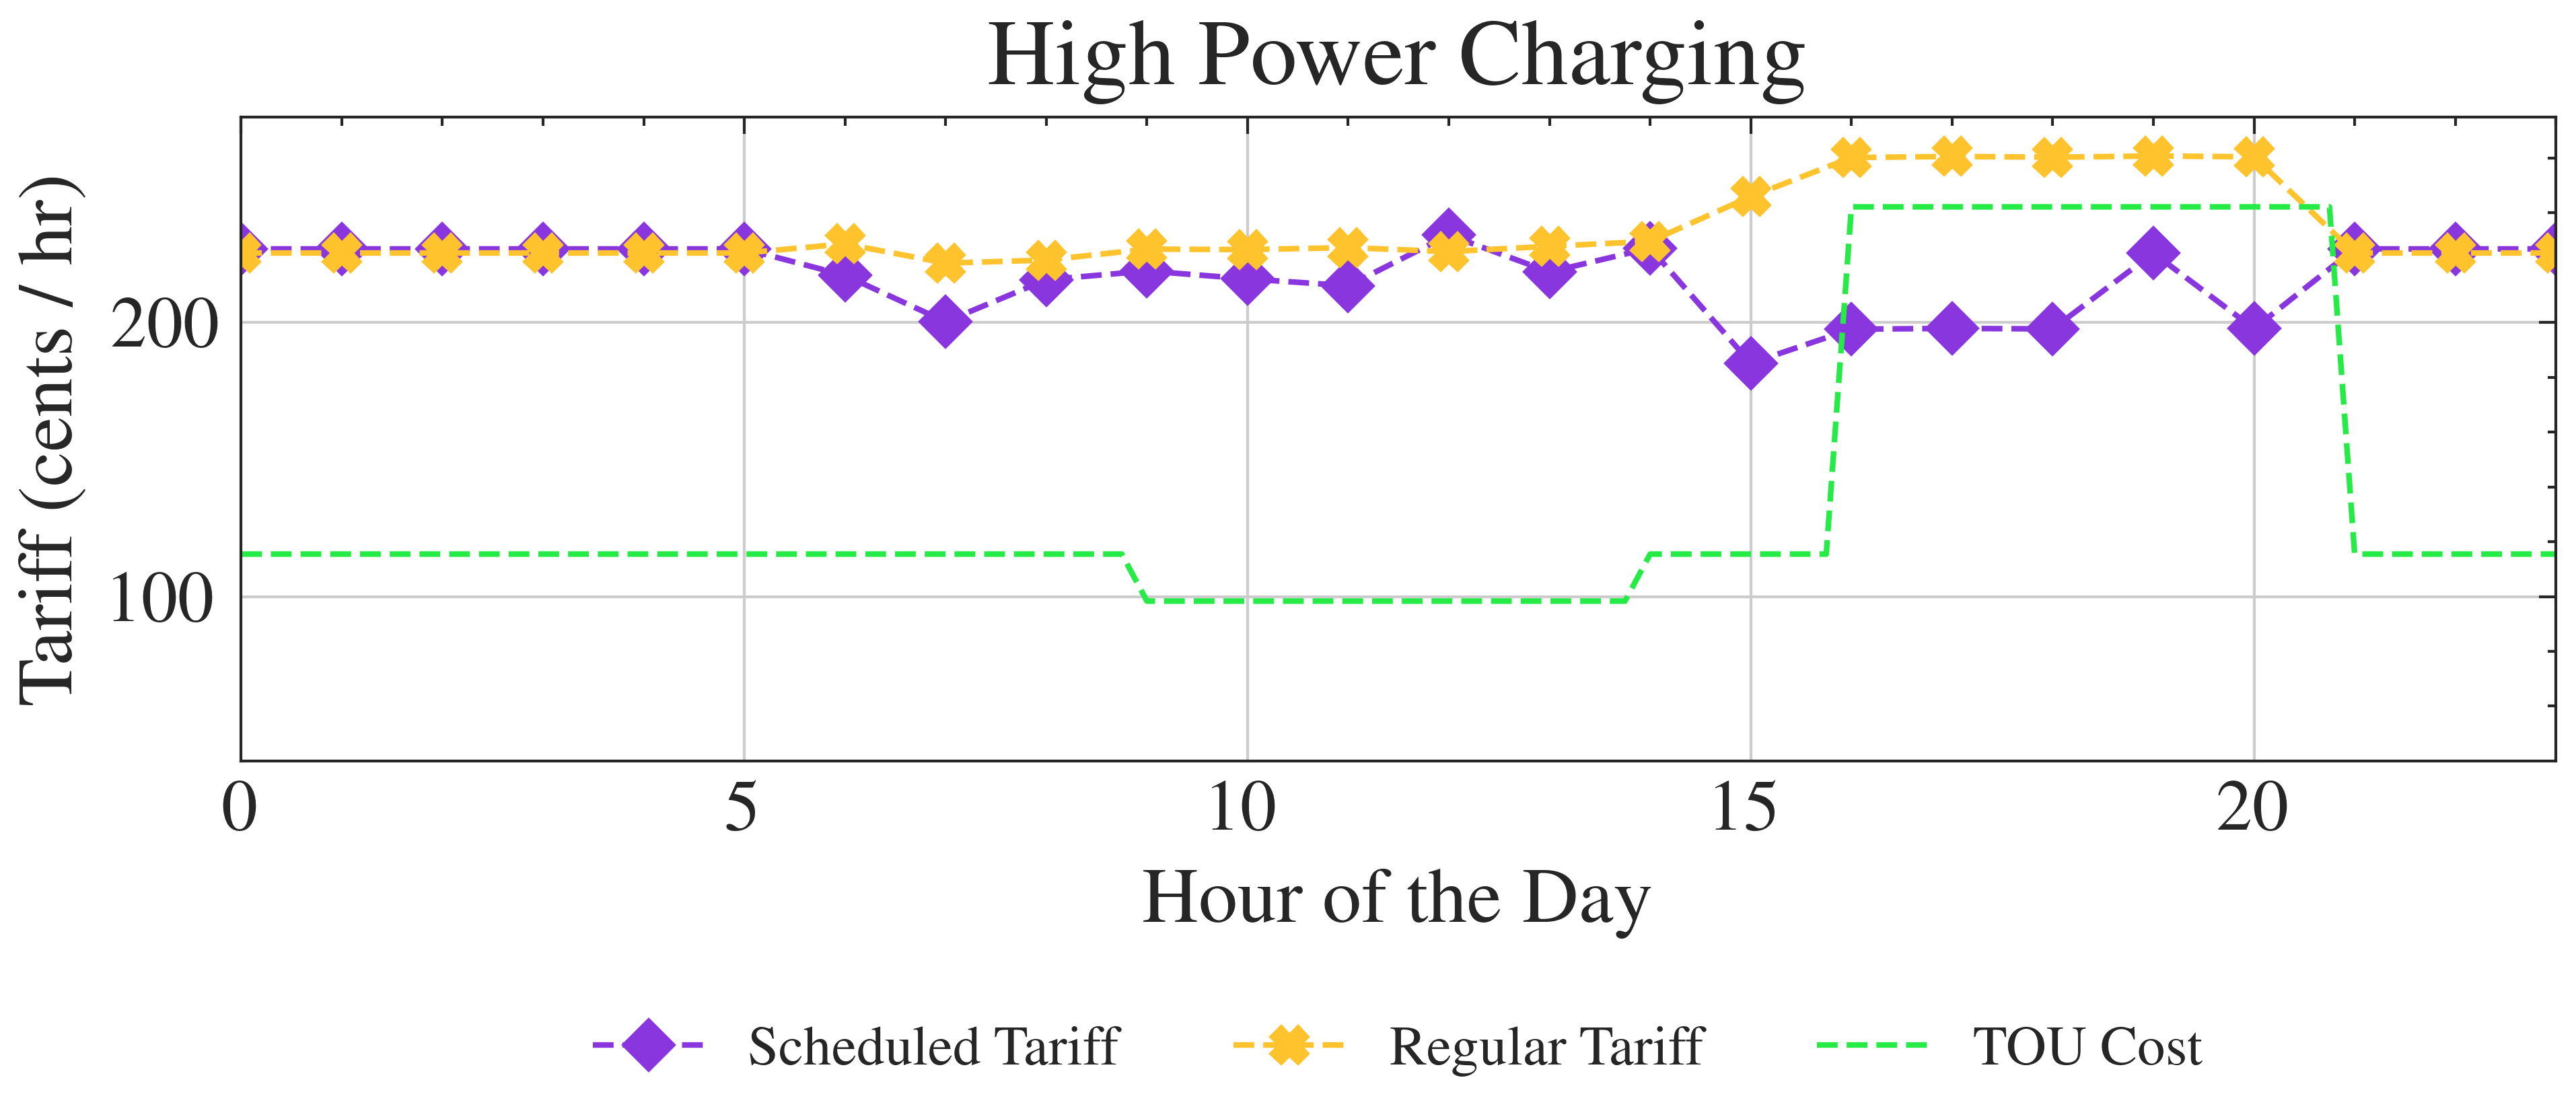

In [155]:
## Plot initial guess vs optimization result 
fig,ax= plt.subplots(1,1,figsize=(w,h))
# Objective Value for each iteration 

arrHour = high_prices['arrHour'].values

high_prices['reg_centsPerHr'].values
high_prices['sch_centsPerHr'].values

ax.plot(arrHour, high_prices['sch_centsPerHr'].values, 
        label = 'Scheduled Tariff', 
        marker = 'D',
        linestyle = "--",color=high_vis_map[3])
ax.plot(arrHour, high_prices['reg_centsPerHr'].values, color=high_vis_map[4], label = 'Regular Tariff',marker ='X',linestyle = "--")
ax.plot(np.arange(0,24,0.25), high_TOU, label = 'TOU Cost', ms=0,marker ='X',
        linestyle = "--",
       color=high_vis_map[2])

ax.set_ylim(40,275)
ax.set_xlim(0,23)
ax.grid()
ax.set_title("High Power Charging")
ax.set_xlabel("Hour of the Day")
ax.set_ylabel("Tariff (cents / hr)")
# ax.set_title("Objective Value")
# ax.legend(loc = 0)
ax.legend(bbox_to_anchor=(0.5, -0.45), loc='center', ncol=3,fontsize=10)

fig.savefig('Figures/fig2a.pdf', dpi=300)

Text(0.5, 0.98, 'Hour 17')

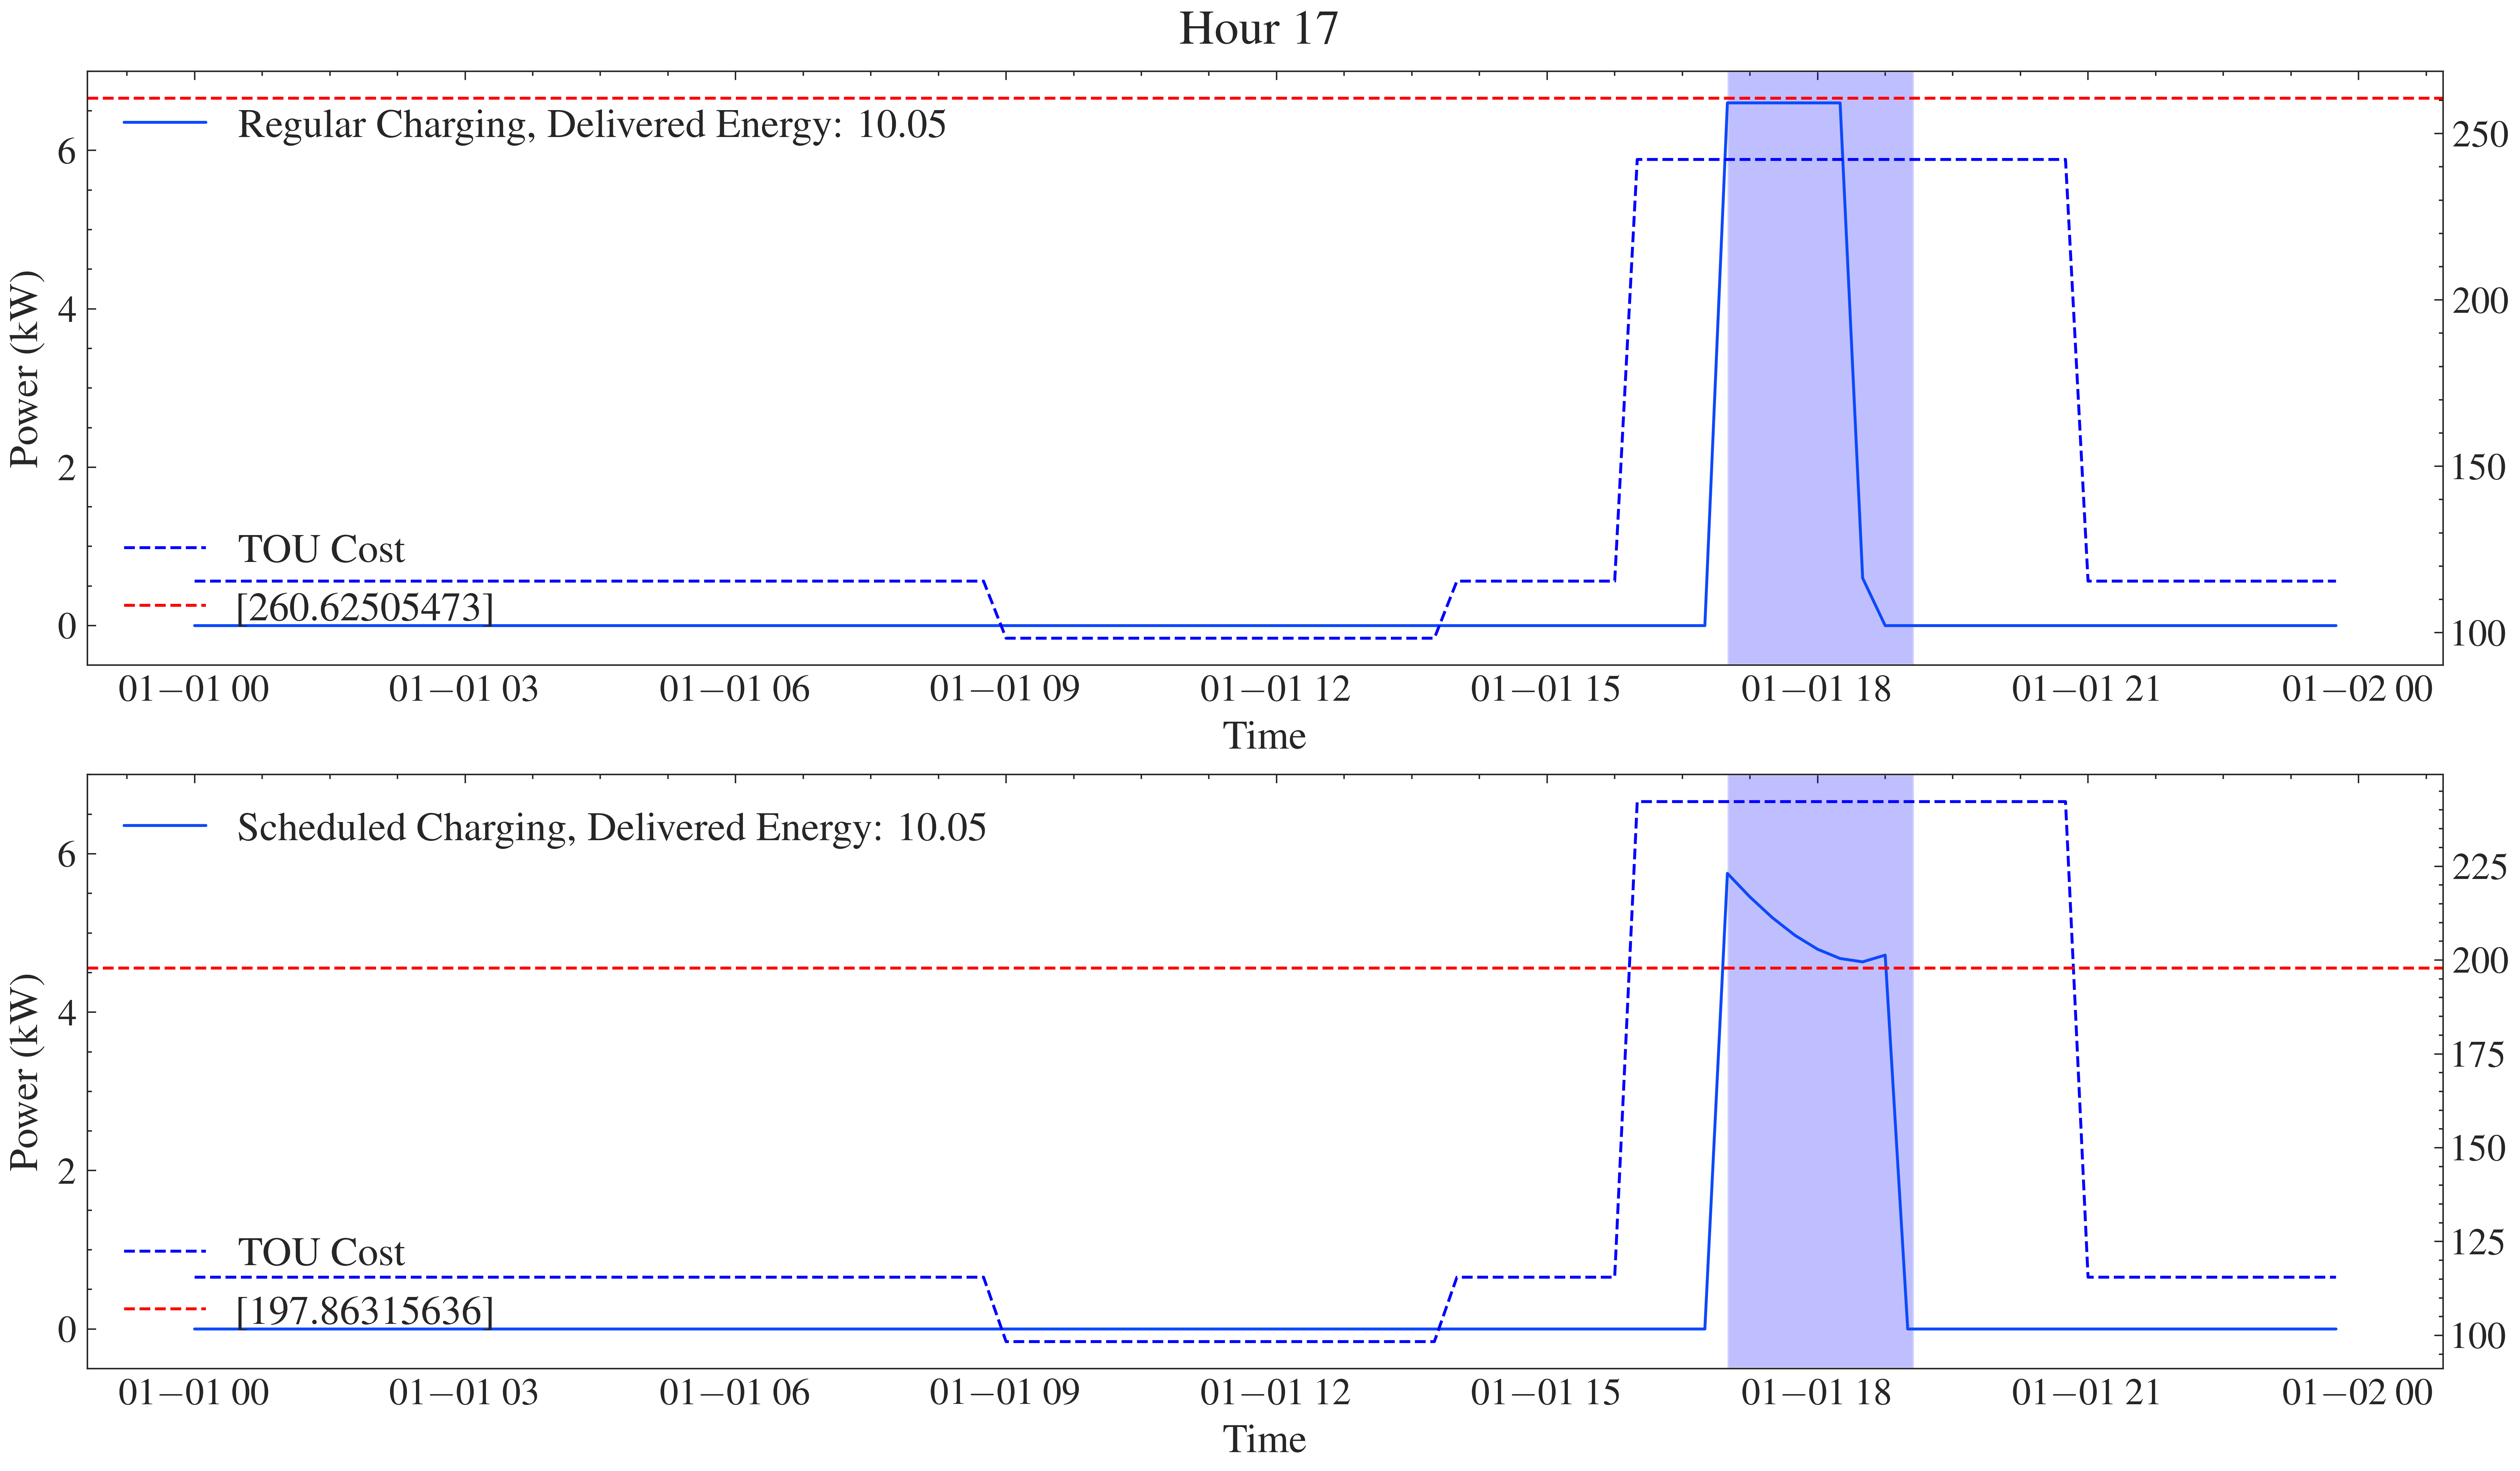

In [156]:
#### CHECK 6 - 7 - 8 - 9 -10 - 11 - 12 - 13 - 14 - 15 - 16 ##### 
arrival_hour = 17
station_pow_max = 6.6
interval_size_hour = 0.25

power = np.array(json.loads(high_powers.loc[arrival_hour,"power_kw"]))
e_need = high_powers.loc[arrival_hour ,"estEnergykWh"]
duration = high_powers.loc[arrival_hour ,"estDurationHrs"]

arrival_interval = int(arrival_hour *steps_in_hr)
duration_interval =  int(duration * 60 / interval_size_minutes)

N_asap = math.ceil((e_need / station_pow_max / eff * int(1 / interval_size_hour)))
N_asap_remainder = (e_need / station_pow_max / eff * int(1 / interval_size_hour)) % 1

high_TOU = TOU_tariff * 6.6

try:
    sch_arr = np.zeros((96,1))
    reg_arr = np.zeros((96,1))  
    timerange = pd.date_range("1/1/2021", periods=96, freq="{}min".format(15))
    sch_arr[arrival_interval:(arrival_interval+duration_interval)] = power.reshape((duration_interval,1))
    reg_arr[arrival_interval:(arrival_interval+N_asap)] = station_pow_max 
    reg_arr[(arrival_interval+N_asap) - 1] = station_pow_max * N_asap_remainder

except: 
    timerange = pd.date_range("1/1/2021", periods=96 * 2, freq="{}min".format(15))
    sch_arr = np.zeros((96*2,1))
    reg_arr = np.zeros((96*2,1))
    sch_arr[arrival_interval:(arrival_interval+duration_interval)] = power.reshape((duration_interval,1))
    reg_arr[arrival_interval:(arrival_interval+N_asap)] = station_pow_max
    reg_arr[(arrival_interval+N_asap) - 1] = station_pow_max * N_asap_remainder
    high_TOU = np.concatenate([high_TOU,high_TOU])


fig,(ax1, ax2) = plt.subplots(2,1,figsize=(12,7) ,)

ax1.plot(timerange, reg_arr, label = "Regular Charging, Delivered Energy: "+str(np.round(np.sum(reg_arr * 0.25),2)))
ax = ax1.twinx()
ax.plot(timerange , high_TOU, label = 'TOU Cost', color = 'blue', ms=0,marker ='X',linestyle = "--")
ax.axhline(high_prices[high_prices['arrHour']==arrival_hour]['reg_centsPerHr'].values  ,linestyle='--',color='red', label = high_prices[high_prices['arrHour']==arrival_hour]['reg_centsPerHr'].values)
ax.legend(loc=3)
ax2.plot(timerange, sch_arr, label = "Scheduled Charging, Delivered Energy: "+str(np.round(np.sum(sch_arr * 0.25),2)))
ax = ax2.twinx()
ax.plot(timerange , high_TOU, label = 'TOU Cost', color = 'blue', ms=0,marker ='X',linestyle = "--")
ax.axhline(high_prices[high_prices['arrHour']==arrival_hour]['sch_centsPerHr'].values , linestyle='--',color='red', label = high_prices[high_prices['arrHour']==arrival_hour]['sch_centsPerHr'].values )
ax.legend(loc=3)
plot_arrival_departure([ax1,ax2], arrival_hour, 0, int(arrival_hour + duration), int(60 * ((arrival_hour + duration) % int(arrival_hour + duration))))

# plot_max_min_power([ax1,ax2],6.6)
for ax in [ax1,ax2]:
    ax.set_ylim(-0.5,7)
    ax.legend(loc=0)
    ax.legend(loc=0)
    ax.set_xlabel("Time")
    ax.set_ylabel("Power (kW)")


fig.suptitle("Hour {}".format(arrival_hour))

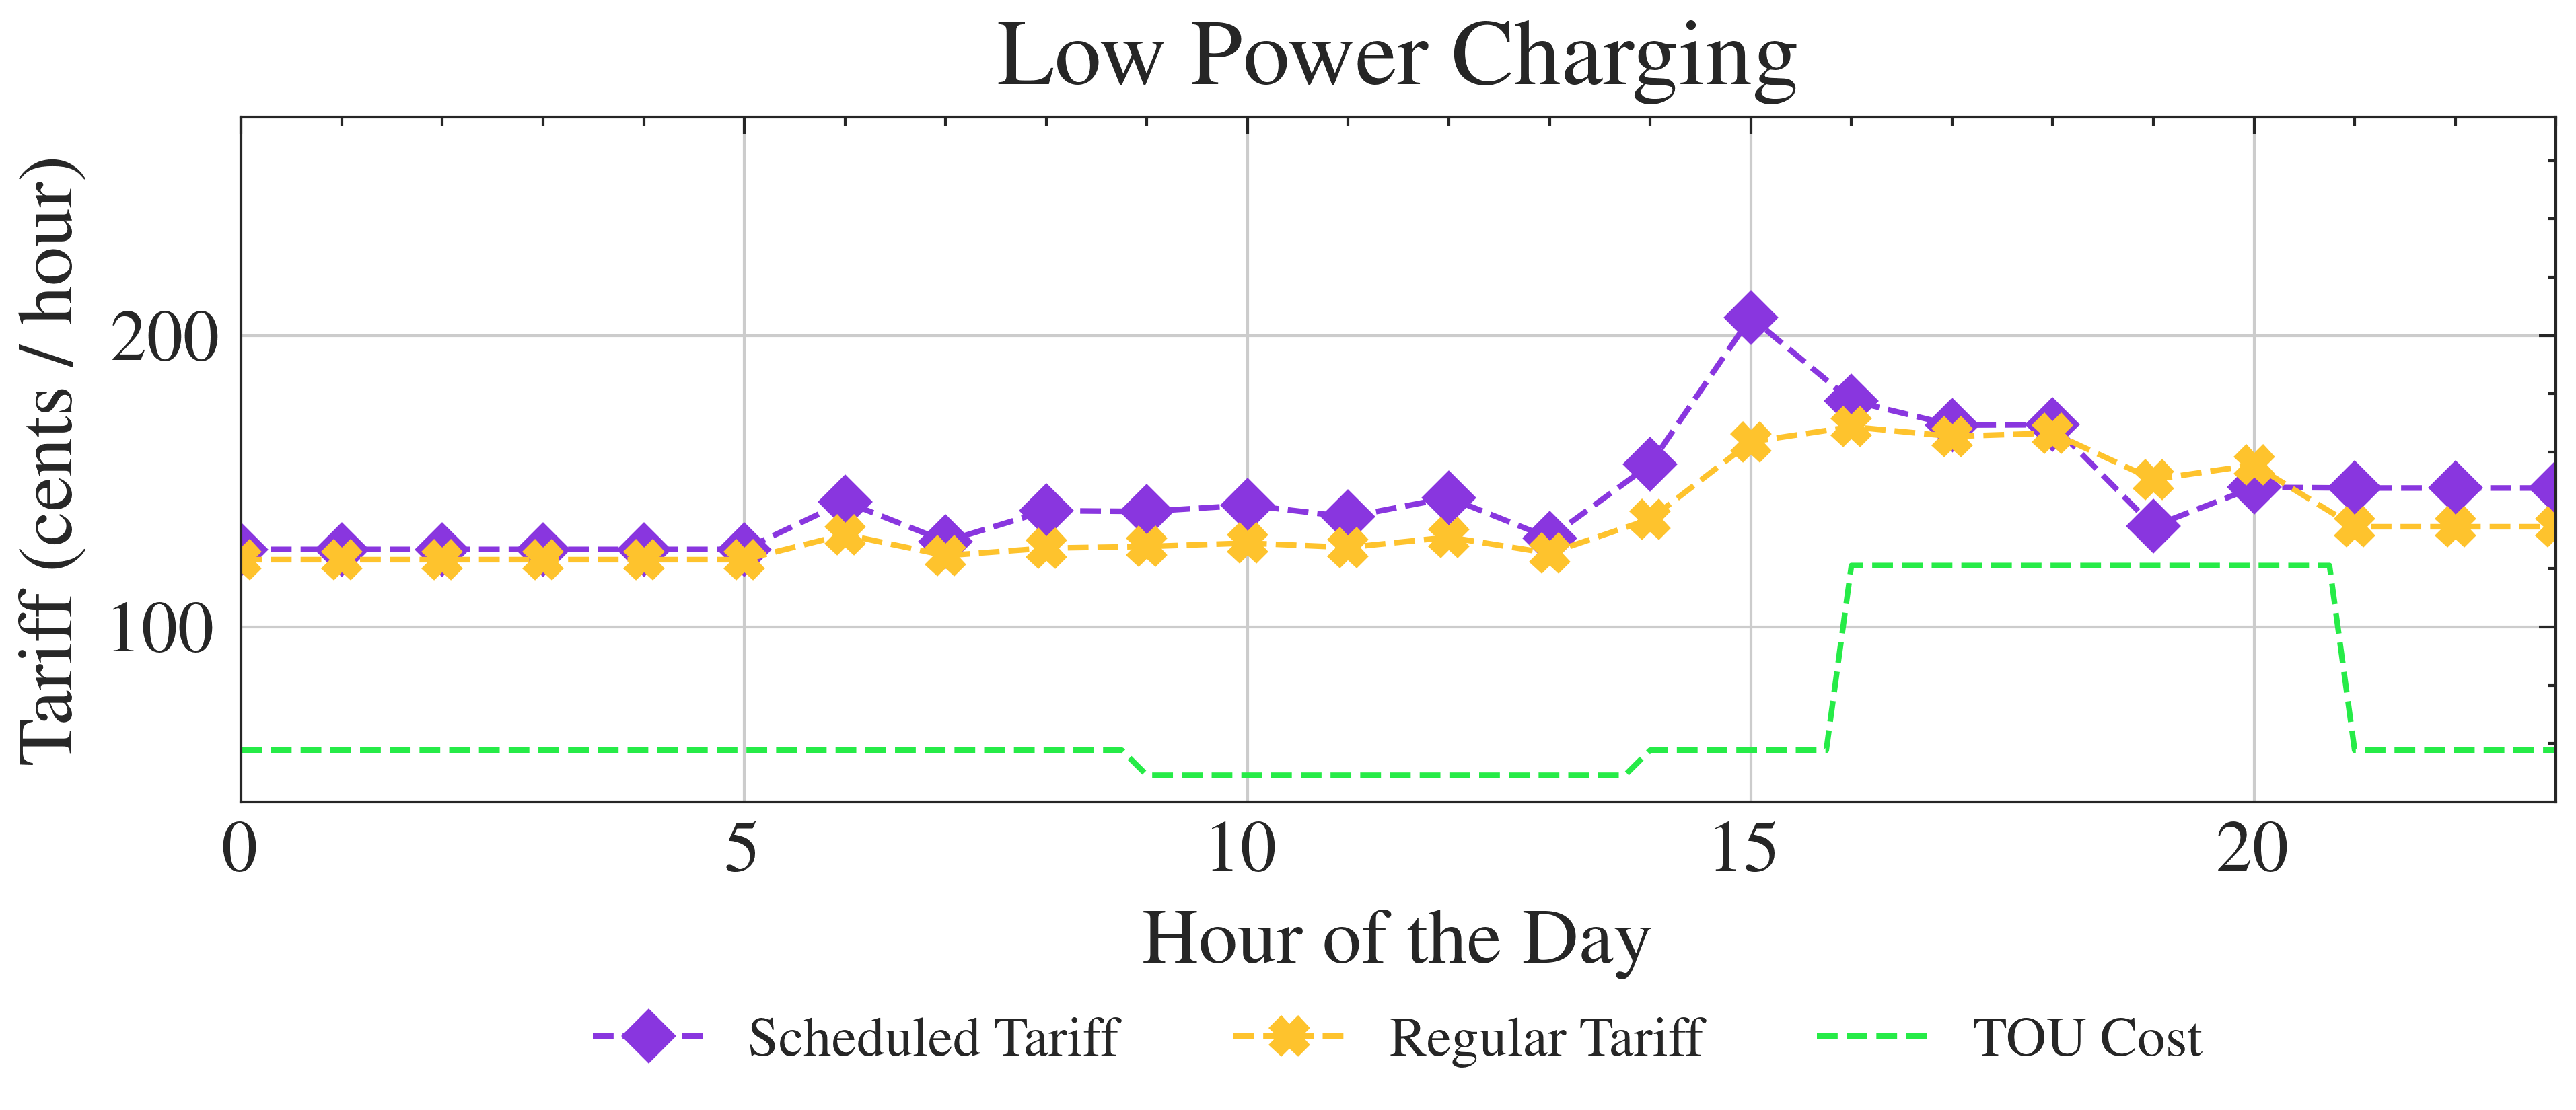

In [157]:
## Plot initial guess vs optimization result 
fig,ax= plt.subplots(1,1,figsize=(w,h))
# Objective Value for each iteration 

arrHour = low_prices['arrHour'].values

low_prices['reg_centsPerHr'].values
low_prices['sch_centsPerHr'].values

ax.plot(arrHour, 
        low_prices['sch_centsPerHr'].values, 
        label = 'Scheduled Tariff',
        marker = 'D',
        linestyle = "--",
        color=high_vis_map[3])
ax.plot(arrHour, low_prices['reg_centsPerHr'].values, 
        label = 'Regular Tariff',
        marker ='X',
        linestyle = "--", 
        color=high_vis_map[4])
ax.plot(np.arange(0,24,0.25), 
        low_TOU, 
        label = 'TOU Cost', 
        ms=0,
        marker ='X',
        linestyle = "--",
       color=high_vis_map[2])

ax.set_ylim(40,275)
ax.set_xlim(0,23)
# ax.margins(0)
ax.grid()
ax.set_xlabel("Hour of the Day")
ax.set_ylabel("Tariff (cents / hour)")
ax.set_title("Low Power Charging")
# ax.set_title("Objective Value")
# ax.legend()
ax.legend(bbox_to_anchor=(0.5, -0.35), loc='center', ncol=3,fontsize=10)
fig.savefig('Figures/fig2b.pdf', dpi=300)

Text(0.5, 0.98, 'Hour 8')

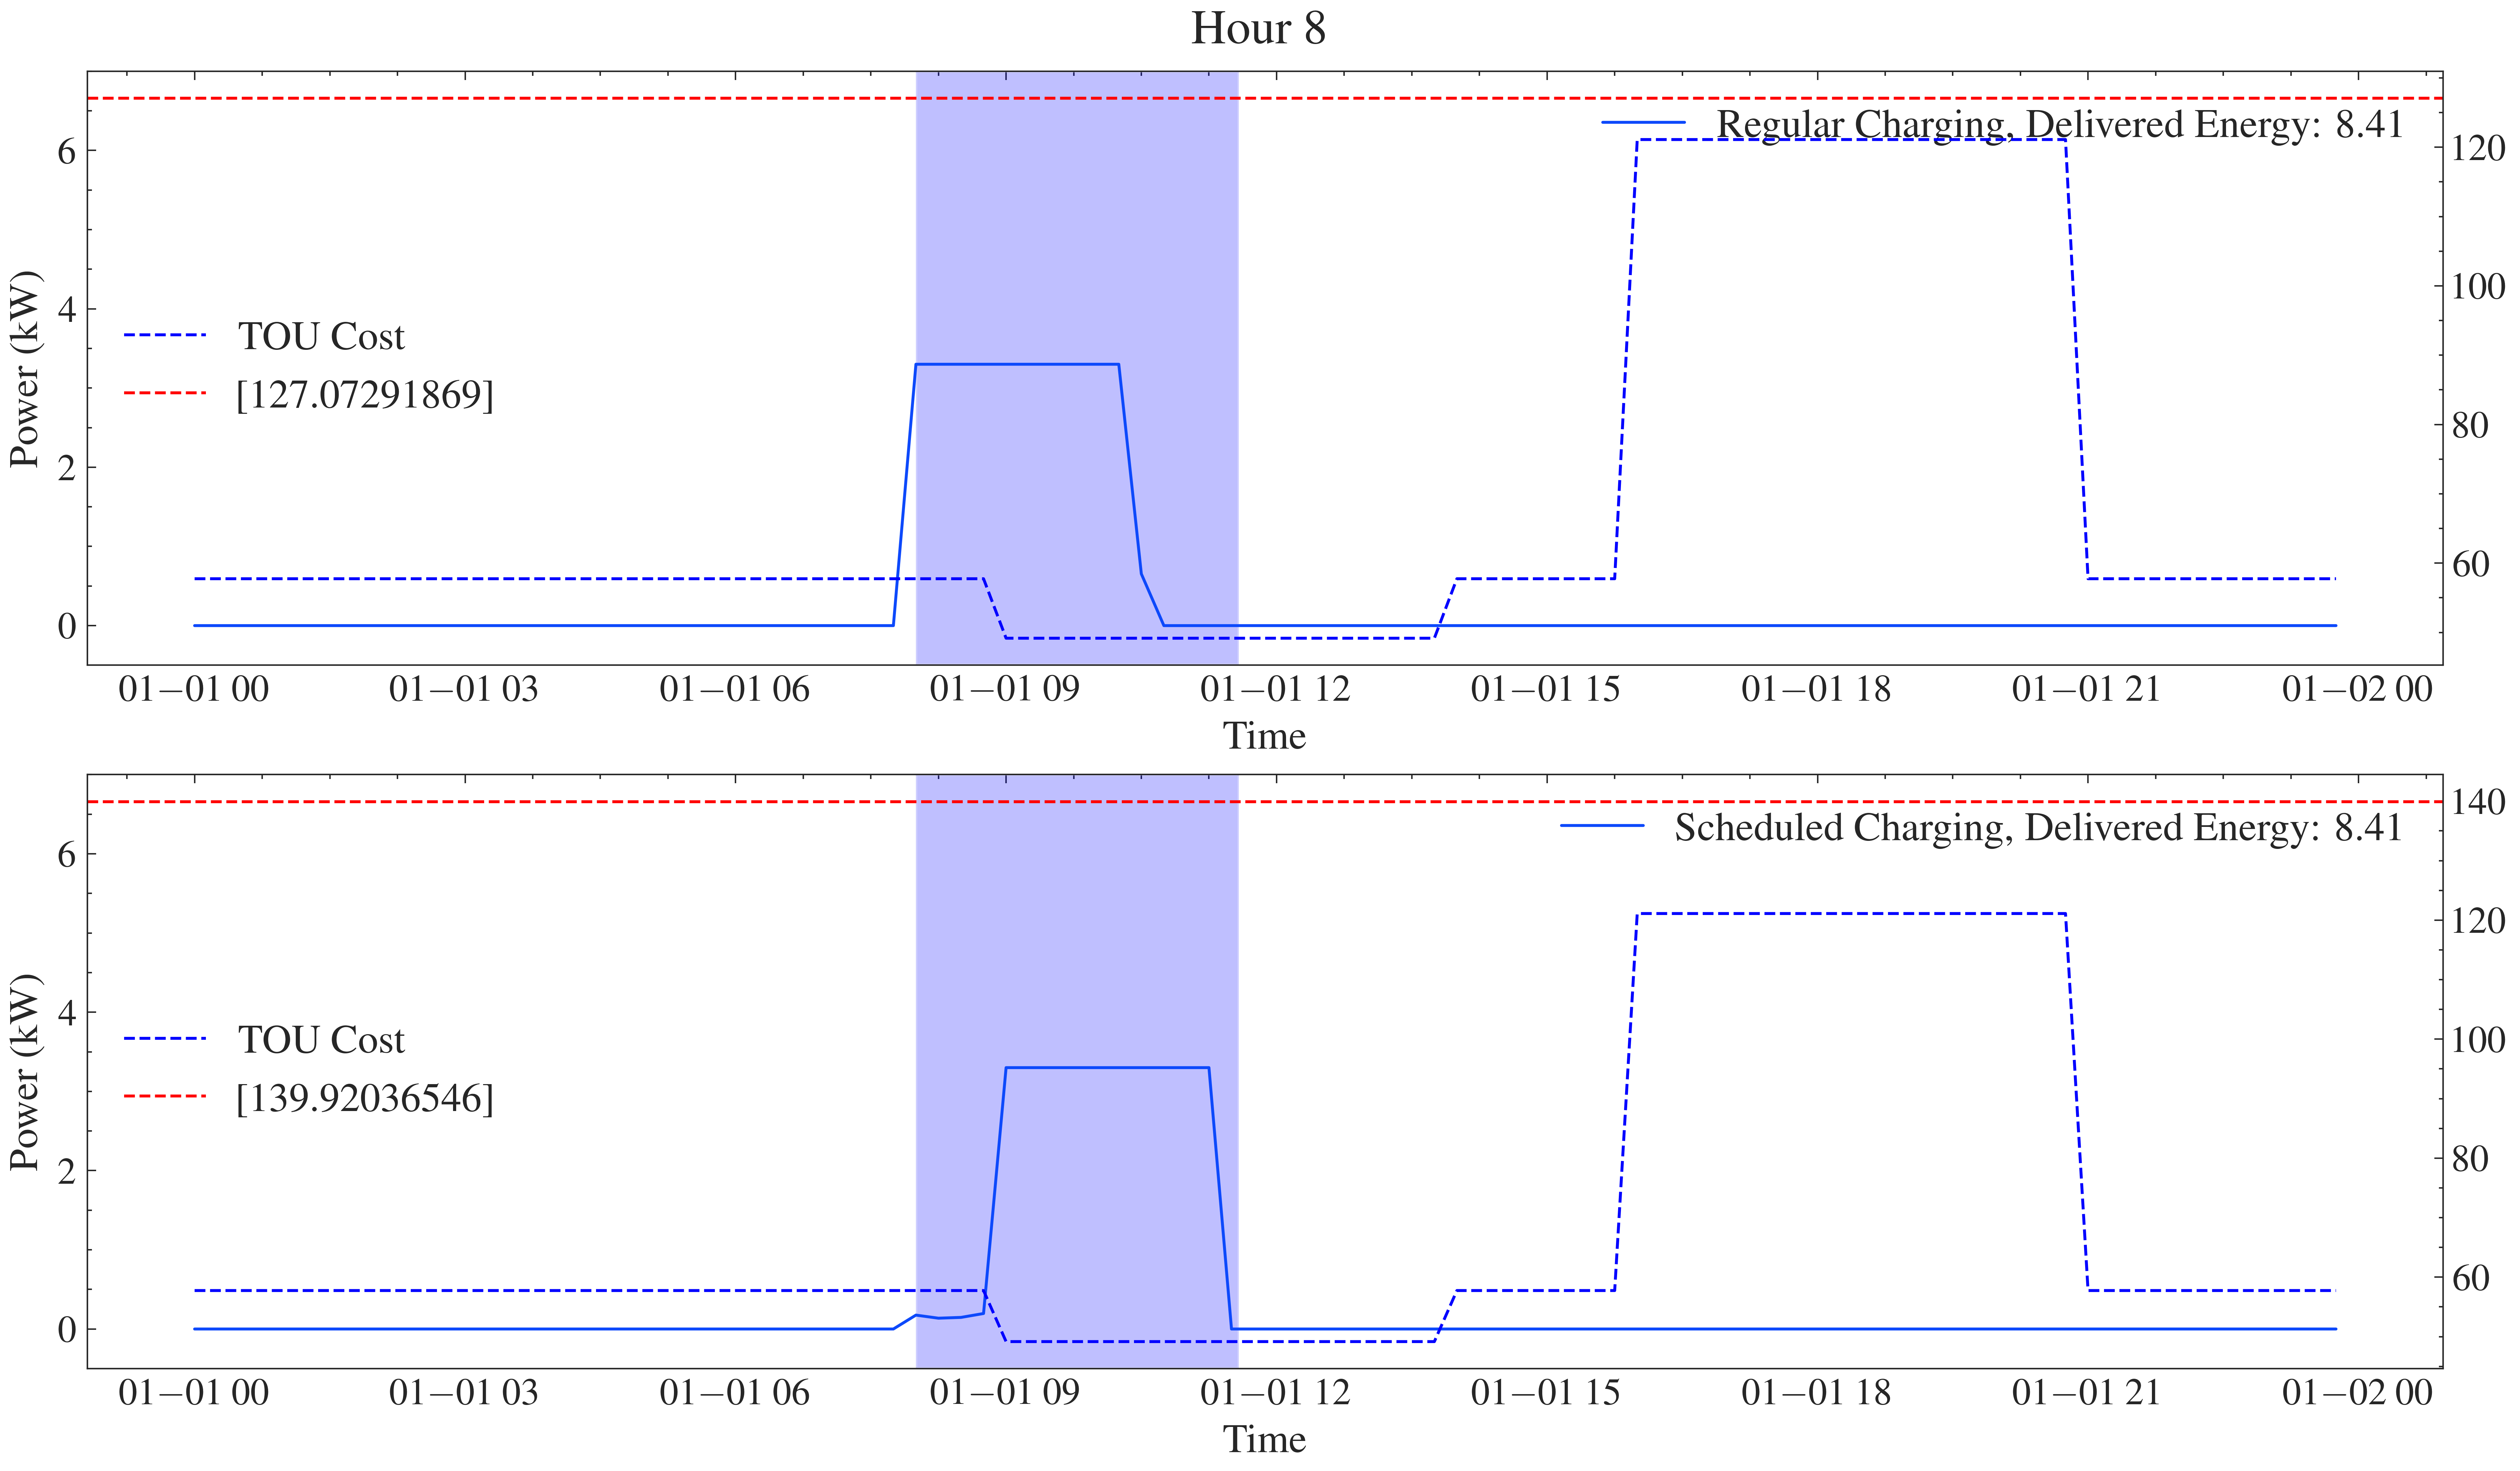

In [158]:
#### CHECK 6 - 7 - 8 - 9 -10 - 11 - 12 - 13 - 14 - 15 - 16 ##### 
arrival_hour = 8
power = np.array(json.loads(low_powers.loc[arrival_hour,"power_kw"]))
station_pow_max = 3.3
e_need = low_powers.loc[arrival_hour ,"estEnergykWh"]
duration = low_powers.loc[arrival_hour ,"estDurationHrs"]

arrival_interval = int(arrival_hour *steps_in_hr)
# duration_interval =  int(np.ceil(duration * 60 / interval_size_minutes))

duration_interval =  int(duration * 60 / interval_size_minutes)
N_asap = math.ceil((e_need / station_pow_max / eff * int(1 / interval_size_hour)))
N_asap_remainder = (e_need / station_pow_max / eff * int(1 / interval_size_hour)) % 1

low_TOU = TOU_tariff * 3.3

try:
    sch_arr = np.zeros((96,1))
    reg_arr = np.zeros((96,1))  
    timerange = pd.date_range("1/1/2021", periods=96, freq="{}min".format(15))
    sch_arr[arrival_interval:(arrival_interval+duration_interval)] = power.reshape((duration_interval,1))
    reg_arr[arrival_interval:(arrival_interval+N_asap)] = station_pow_max 
    reg_arr[(arrival_interval+N_asap) - 1] = station_pow_max * N_asap_remainder

except: 
    timerange = pd.date_range("1/1/2021", periods=96 * 2, freq="{}min".format(15))
    sch_arr = np.zeros((96*2,1))
    reg_arr = np.zeros((96*2,1))
    sch_arr[arrival_interval:(arrival_interval+duration_interval)] = power.reshape((duration_interval,1))
    reg_arr[arrival_interval:(arrival_interval+N_asap)] = station_pow_max
    reg_arr[(arrival_interval+N_asap) - 1] = station_pow_max * N_asap_remainder
    high_TOU = np.concatenate([low_TOU,low_TOU])


fig,(ax1, ax2) = plt.subplots(2,1,figsize=(12,7) ,)

ax1.plot(timerange, reg_arr, label = "Regular Charging, Delivered Energy: "+str(np.round(np.sum(reg_arr * 0.25),2)))
ax = ax1.twinx()
ax.plot(timerange ,low_TOU, label = 'TOU Cost', color = 'blue', ms=0,marker ='X',linestyle = "--")
ax.axhline(low_prices[low_prices['arrHour']==arrival_hour]['reg_centsPerHr'].values  ,linestyle='--',color='red', label = low_prices[low_prices['arrHour']==arrival_hour]['reg_centsPerHr'].values)
ax.legend()
ax2.plot(timerange, sch_arr, label = "Scheduled Charging, Delivered Energy: "+str(np.round(np.sum(sch_arr * 0.25),2)))
ax = ax2.twinx()
ax.plot(timerange , low_TOU, label = 'TOU Cost', color = 'blue', ms=0,marker ='X',linestyle = "--")
ax.axhline(low_prices[low_prices['arrHour']==arrival_hour]['sch_centsPerHr'].values , linestyle='--',color='red', label = low_prices[low_prices['arrHour']==arrival_hour]['sch_centsPerHr'].values )
ax.legend()
plot_arrival_departure([ax1,ax2], arrival_hour, 0, int(arrival_hour + duration), int(60 * ((arrival_hour + duration) % int(arrival_hour + duration))))

# plot_max_min_power([ax1,ax2],6.6)
for ax in [ax1,ax2]:
    ax.set_ylim(-0.5,7)
    ax.legend(loc=0)
    ax.legend(loc=0)
    ax.set_xlabel("Time")
    ax.set_ylabel("Power (kW)")


fig.suptitle("Hour {}".format(arrival_hour))

Observations
hour:
5: Regular charging has more energy delivered
6: 
7: Sch charing has lower power 
8: shifts the load but there is something weird
9: shifts the load but there is something weird
10: lowers the power 
11: lowers the power but wrong? ?
12: same 
13: similar to 12
14: still doing stupid things? Just charge fully. 
15: lowers the power, but also 1 kW more charging
16: lowers the power, but also 0.7 kw more charging 
17: very similar reg sch, lowers the power
18: asap charges more
20: weird shape again, check how the data is read/written 
21: same pattern but sch lower, energy difference

# ANALYSIS 
KPI1: Net Profit (charging service revenue less electric utility costs)

KPI2: Slack time (average time PEV is connected, but not charging)

Slack time = (Total Duration connected [hrs]) - ((Energy delivered [kWh])/( Max chg power [kW] ) )

KPI3: Sessions served (average number of sessions per day or week)

KPI4: Quantify leave rate? 
Compute avg. sessions per week across each test period (@Hassan Obeid  suggestion)
We could compute the number of sessions started as percentage of times people access app (i.e. the conversion rate <--- this is lower-bound on leave rate)

KPI5: Average overstay

Further Analysis 
1. How different the prices would be if we optimized real time for the given arrival - departure - e_need combination? 

Normalized cost and revenue of the sessions 
* Distribution
* Histogram 

Baseline , Optimzie V1 , Optimzie V2 
Scheduled /  Regular 
* Revenue 
Utility Cost
Revenue and Utility cost 
Revenue and utility cost – hourly in the key moments 

dcosid: 2794, 2795, 2796 anomaly


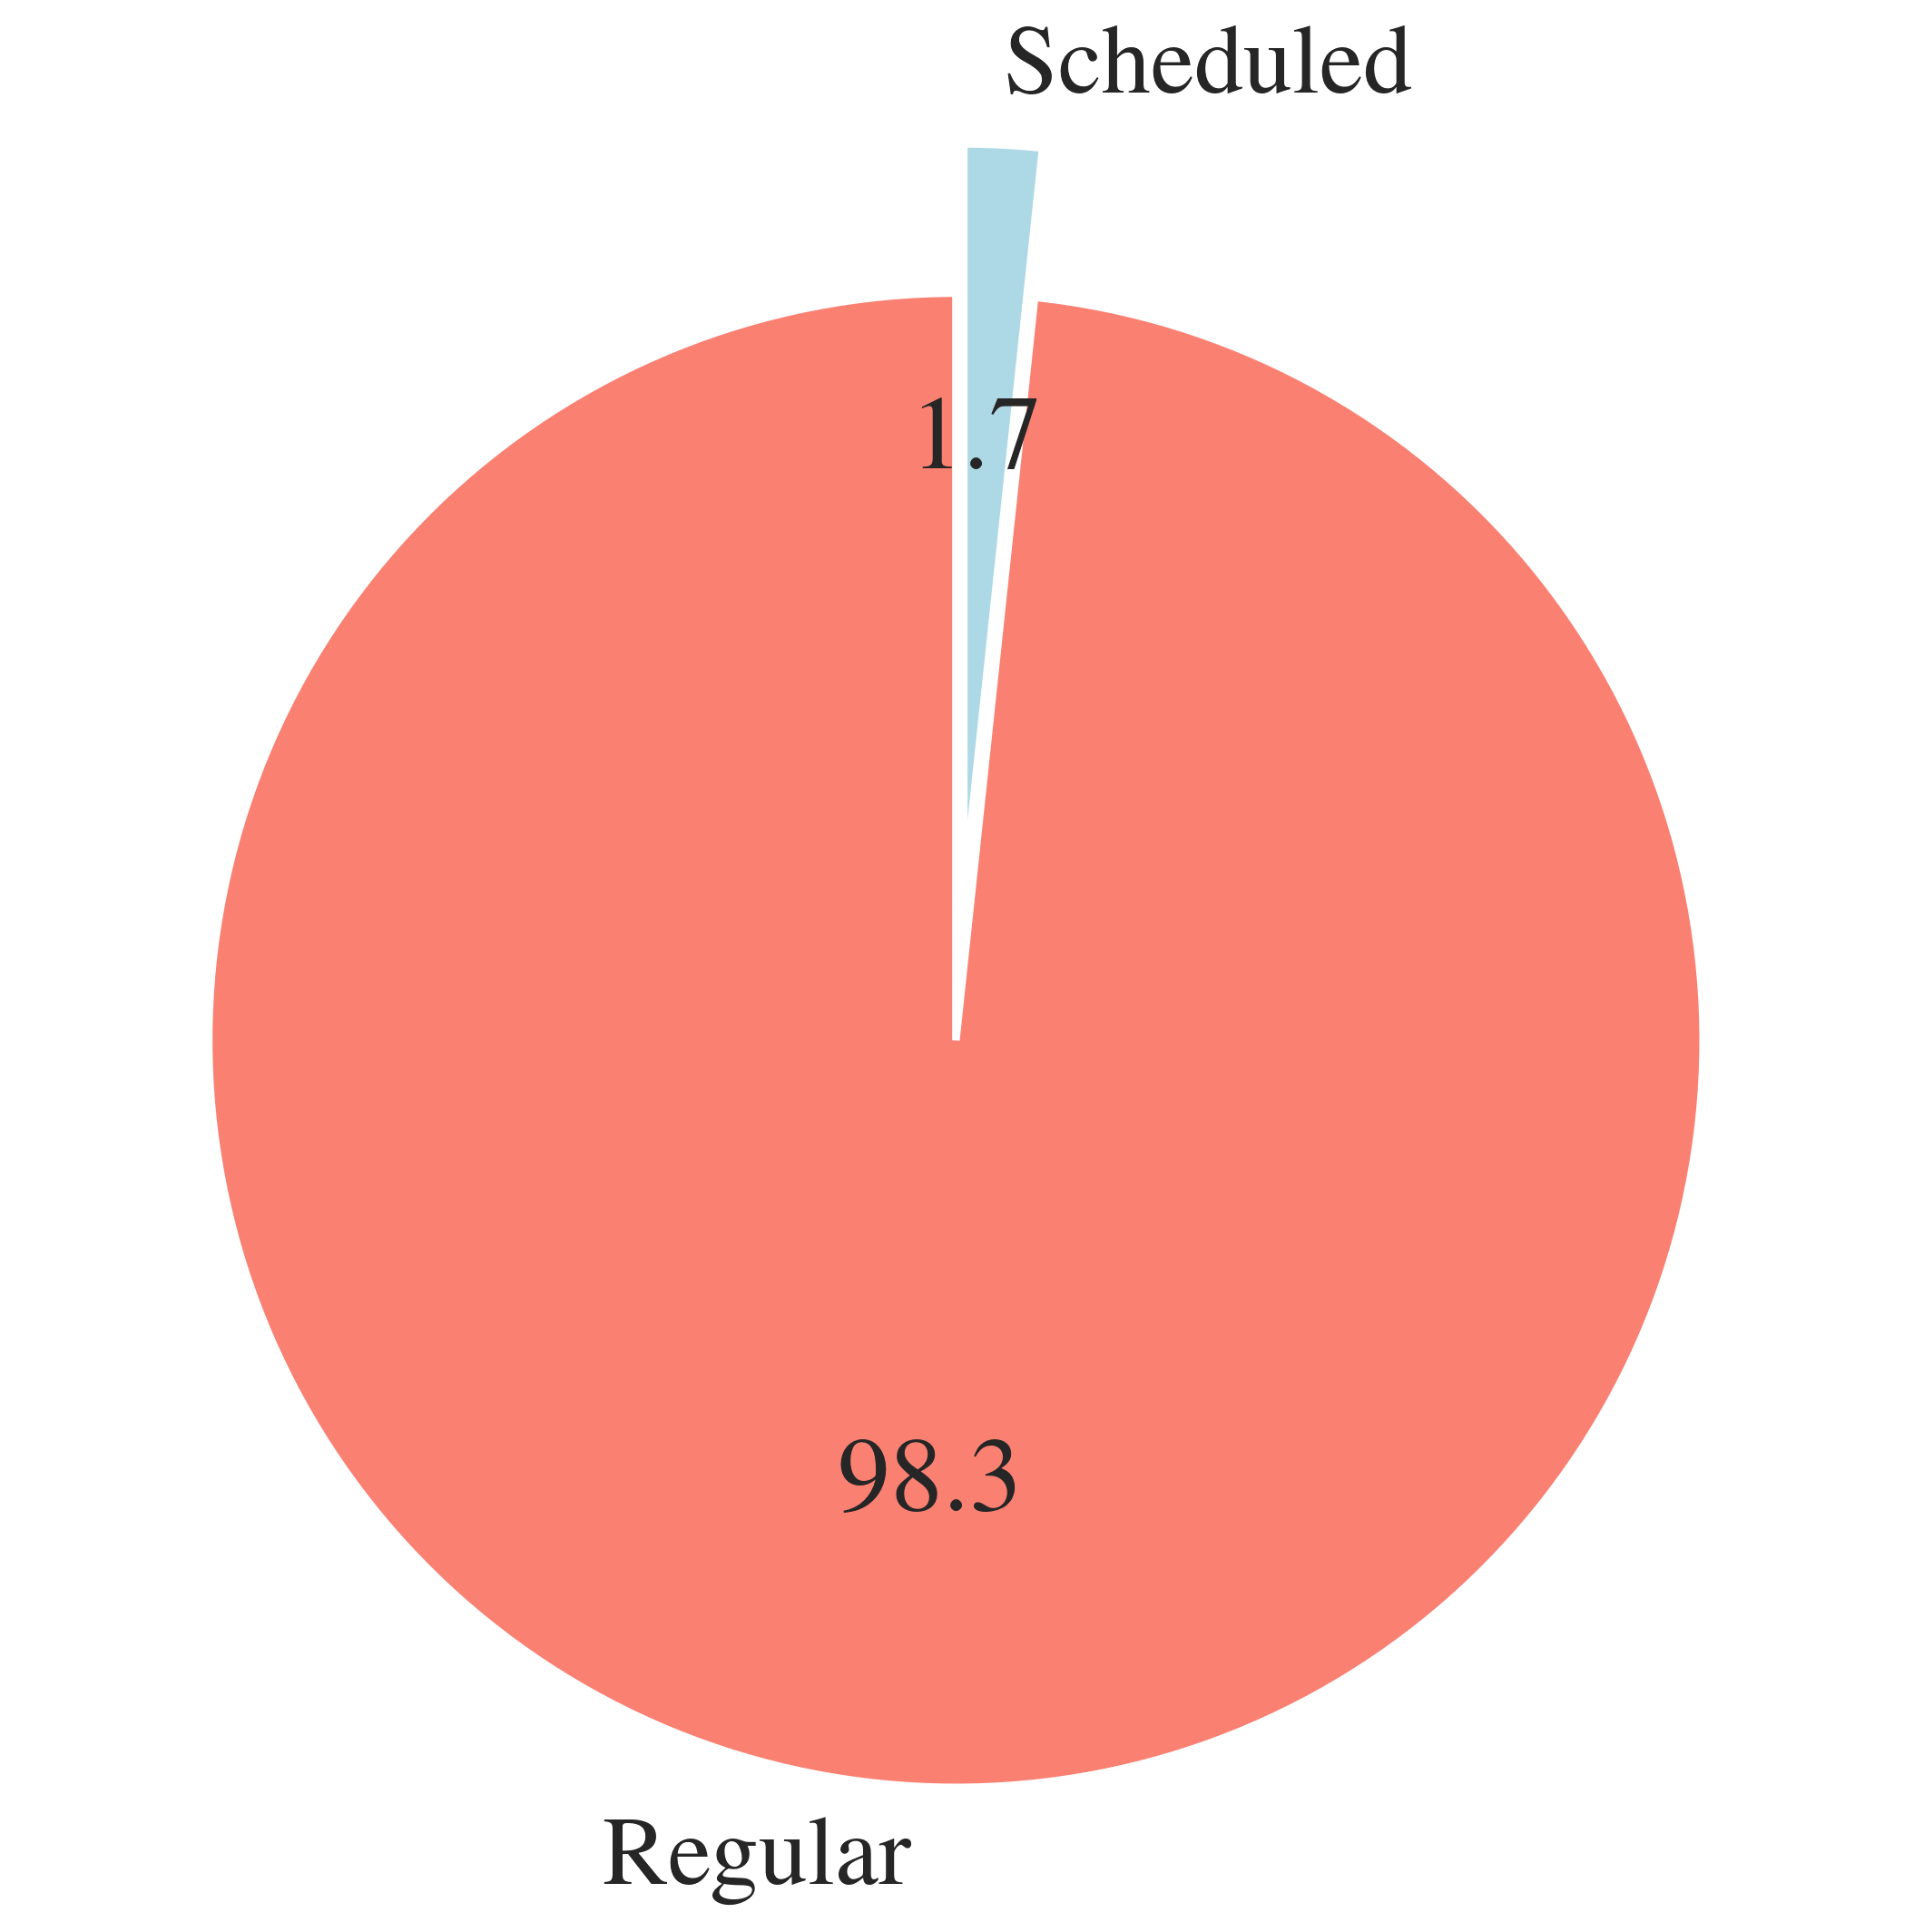

In [159]:

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Regular', 'Scheduled'
sizes = [117, 2]
explode = (0.2, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize=(3.5,3.5
                                 ))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors = ['salmon','lightblue'])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

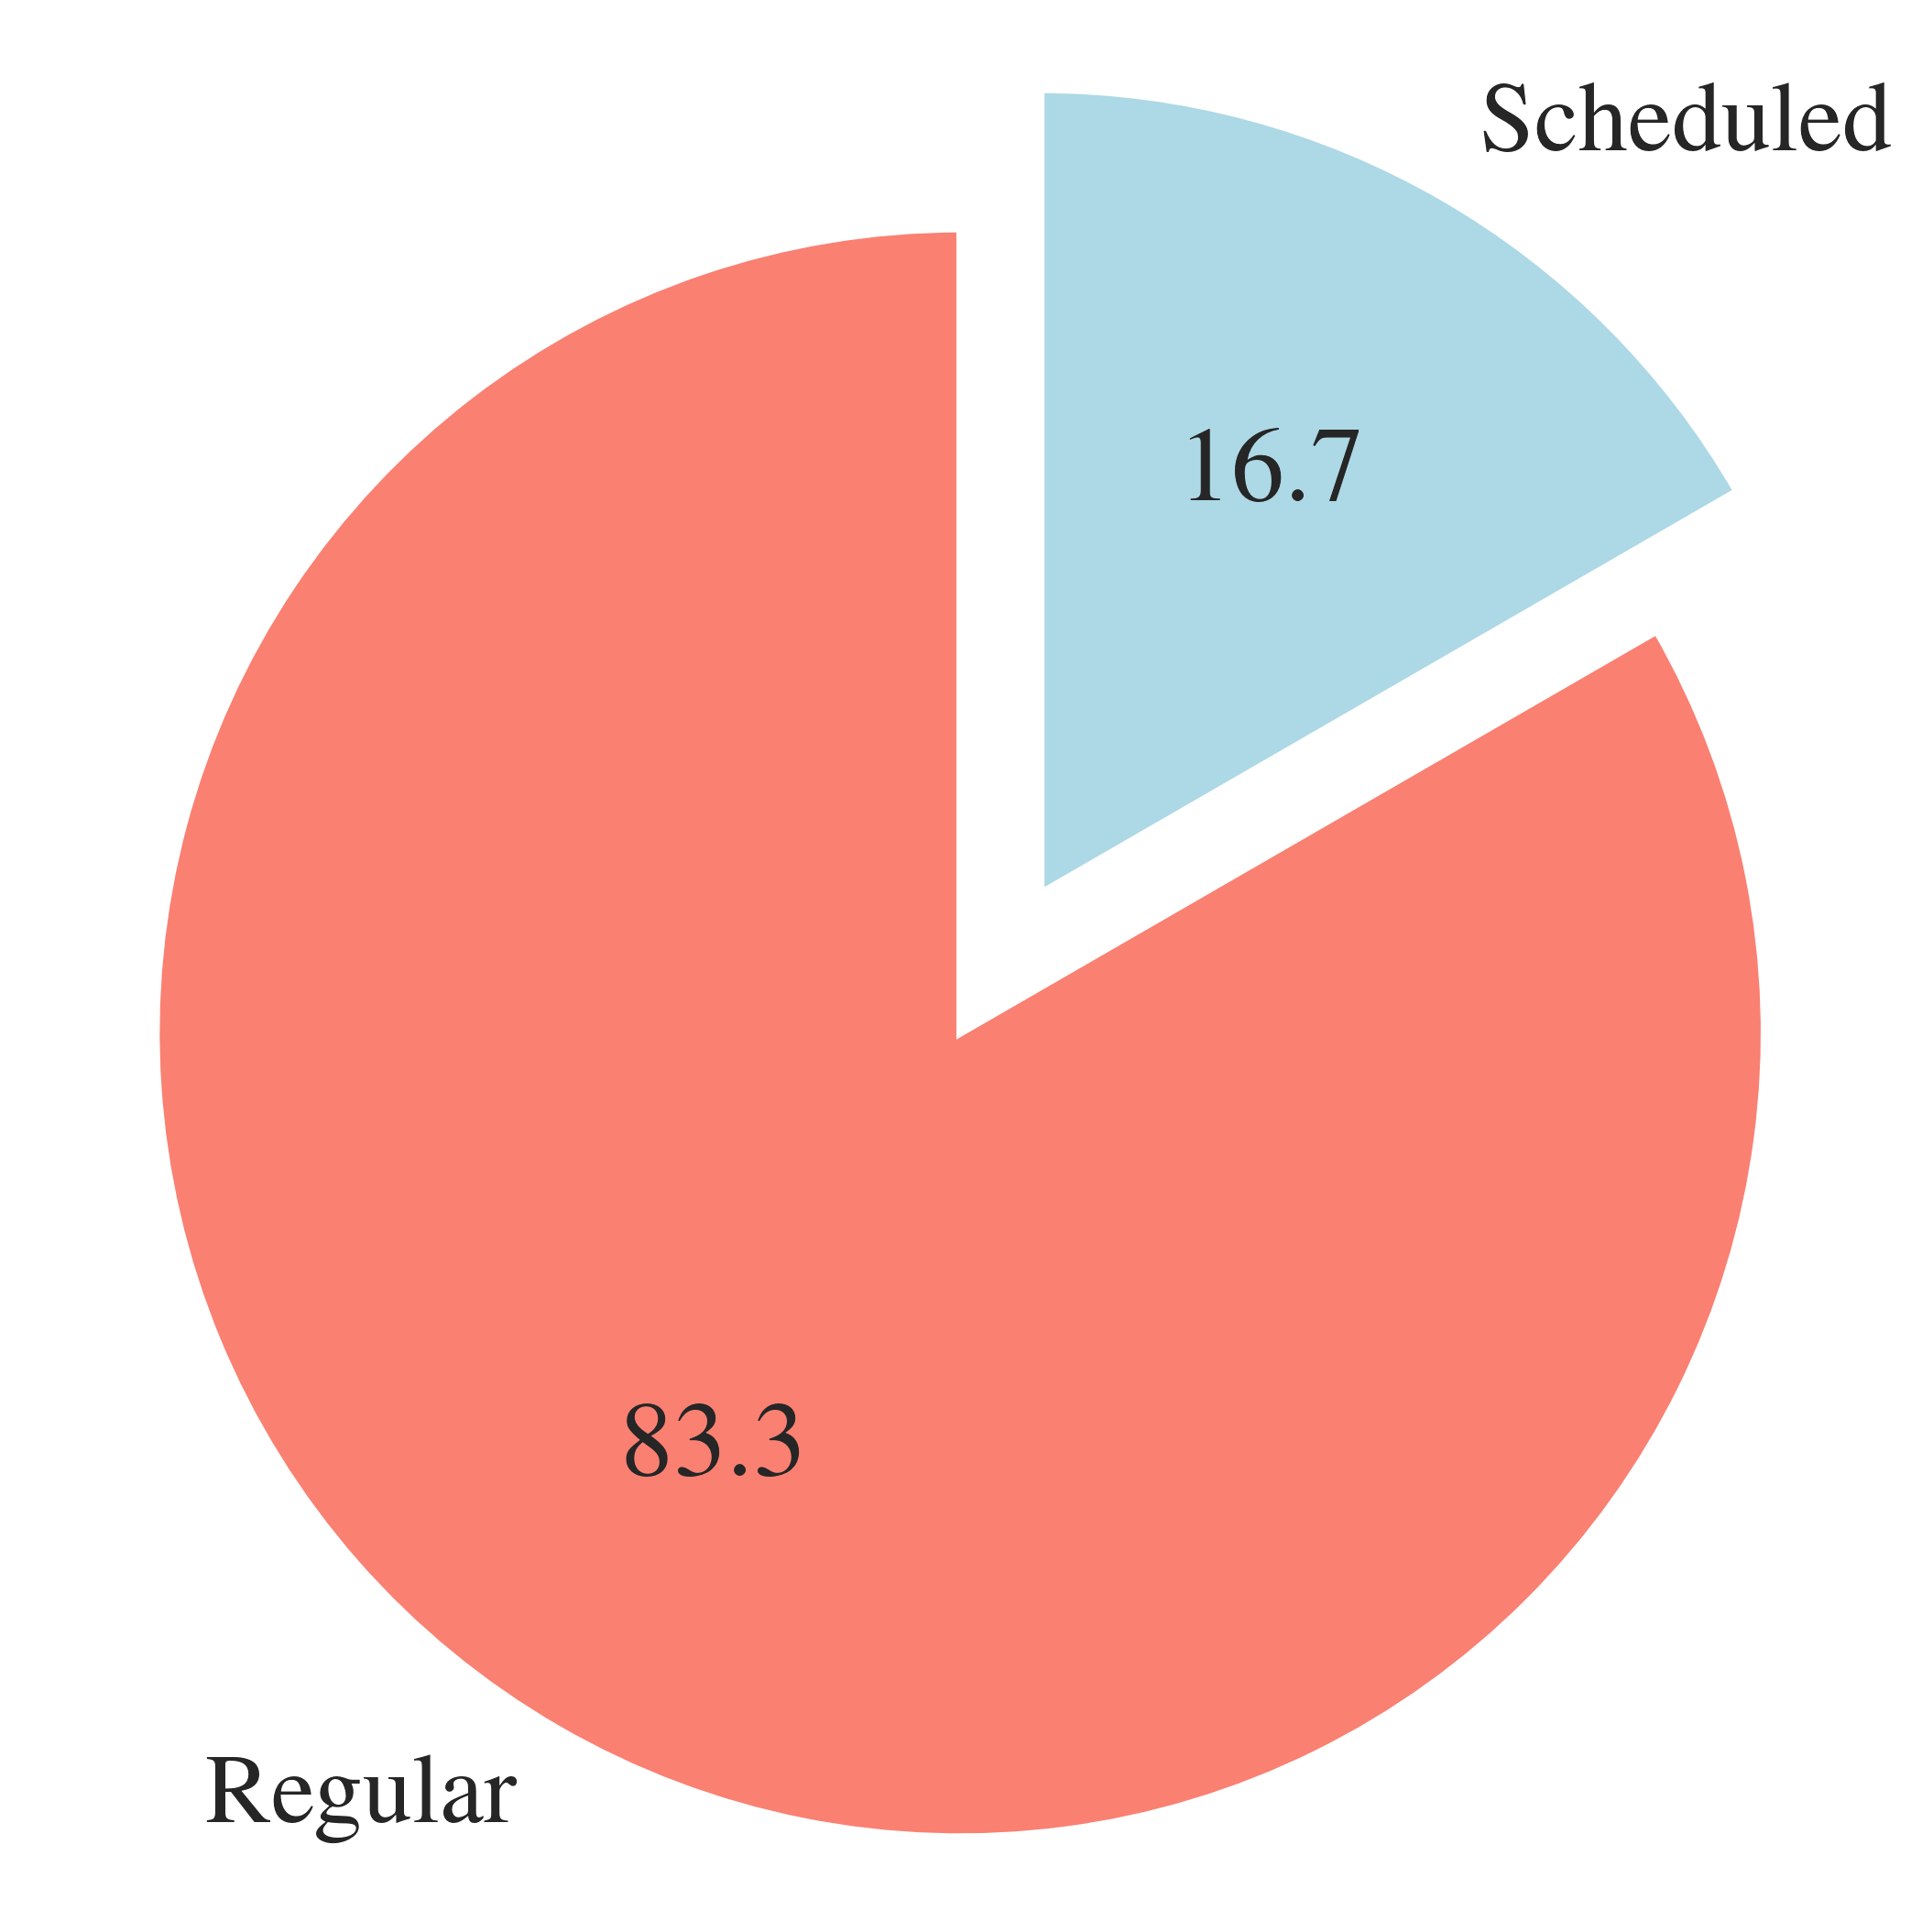

In [160]:

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Regular', 'Scheduled'
sizes = [115, 23]
explode = (0, 0.2)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize=(3.5,3.5))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors = ['salmon','lightblue'])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [161]:
prices[(prices['arrHour'].isin(range(0,24))) & (prices['highPower']==0) ].mean()

Unnamed: 0            23.000000
arrHour               11.500000
reg_centsPerHr       136.354770
sch_centsPerHr       144.596084
sch_overstayPerHr           NaN
sch_centsPerkWh             NaN
highPower              0.000000
estDurationHrs         2.480968
estEnergykWh           5.866729
dtype: float64

In [162]:
# plt.rcParams['figure.constrained_layout.use'] = True
# matplotlib.rcParams.update({'font.size': 15})
# matplotlib.rc('xtick', labelsize=12) 

# matplotlib.rc('ytick', labelsize=12) 

In [163]:
def sessions_TOU(date, interval=5):
    """ 
    TOU dataframe with timestamp index for the given charging sessions date 
    input: date, str    
    """
    tou_index = pd.date_range(start= date , periods=len(TOU_tariff) ,freq="15min" ,tz="US/Pacific")
    tou = pd.DataFrame(index=tou_index, data = {"TOU (cents/kwh)":TOU_tariff }).resample('{}min'.format(interval)).ffill()
    return tou

In [164]:
def session_net_revenue(session_df, interval=5):
    """ 
    There are multiple ways of calculating the revenue. 
    1. cents / kwh * max rate : ((tou * max_rate) - tariff) * duration  = 
    2. cents / kwh * rate : ((tou) - tariff/rate) * power = 
    3. calculate cost and revenue separetely. 
    Cost = (tou * charging power ) 
    Revenue_A = (tariff * duration) 
    Revenue_B = estCost? whats that?

    """
    cost = session_df['Charging Cost (cents)'].values
    revenue = session_df['Charging Revenue (cents)'].values
    overstay = session_df['Overstay Penalty (cents)'].values
    return np.nansum(revenue + overstay) - cost 

def session_cost(session_df, interval = 5 ):
    cost = (session_df["TOU (cents/kwh)"] * (session_df["power_w"] / 1000) * (interval/ 60)).sum()
    return cost 
def session_revenue(session_df):
    choice = session_df["choice"] [0]

    if choice == "REGULAR":
        tariff = session_df["reg_centsPerHr"][0]
    elif choice == "SCHEDULED":
        tariff = session_df["sch_centsPerHr"][0]
    else:
        raise "Error"
    revenue = tariff * session_df['connectedDuration_Hrs'][0]

    return revenue

def calculate_probability(z_reg, z_sch):
    u_reg =  0.3411 -0.0184*(z_sch - z_reg)*.5
    u_sch = 0.0184*(z_sch - z_reg)*.5
    u_leave = -1. + 0.005*(np.mean([z_sch, z_reg]))

#     print(u_leave, u_sch, u_reg)
    denom = np.exp(u_reg) + np.exp(u_sch) + np.exp(u_leave)

    p_reg = np.exp(u_reg) / denom
    p_sch = np.exp(u_sch) / denom
    p_leave = np.exp(u_leave) / denom

#     print(p_reg, p_sch, p_leave, np.sum([p_reg, p_sch, p_leave]))
    return p_reg, p_sch, p_leave 


In [165]:
# convert_to_high_power = phaseIII[((phaseIII['reg_centsPerHr'] > 200) & (phaseIII['peakPower_kW_irl'] < 5))]['dcosId'].unique()
# convert_to_low_power = phaseIII[((phaseIII['reg_centsPerHr'] < 200) & (phaseIII['peakPower_kW_irl'] > 5))]['dcosId'].unique()
convert_to_high_power  = [2251, 2241, 2230, 2244, 2266, 2221, 2225, 2223, 2313, 2232]
convert_to_low_power = [2301, 2307, 2324, 2354, 2398, 2368, 2319, 2375, 2332]

In [166]:
# powers
## What if analysis? 
# Distribution of vehicle power rate, models etc. 
def extract_optimized_powers(session_df, powers_df, row, interval = 15):
    arrHour = session_df.loc[row,'connectTime'].hour

#     vehicle_power_rate_kw = session_df.loc[row,'vehicle_maxChgRate_W'] / 1000
    vehicle_power_rate_kw = session_df.loc[row,'peakPower_kW_irl']
    dcosId = session_df.loc[row,'dcosId']
    station_power_rate_kw = 6.6 
    charging_rate_kw = min(vehicle_power_rate_kw, station_power_rate_kw)
    
    
    if charging_rate_kw >= 6.6:
        session_power = powers_df[powers_df['highPower'] == 1].reset_index(drop=True)
    else:
        session_power = powers_df[powers_df['highPower'] == 0].reset_index(drop=True)
    
    ### some are shown wrong prices 
    if dcosId in convert_to_high_power:
        session_power  =  powers_df[powers_df['highPower'] == 1].reset_index(drop=True)
        ### some are shown wrong prices 
    if dcosId in convert_to_low_power:
        session_power  =  powers_df[powers_df['highPower'] == 0].reset_index(drop=True)

    start = session_df.loc[row,'connectTime'].floor("1H")
    power_kw= json.loads(session_power.loc[arrHour,"power_kw"]) 
    ts_index = pd.date_range(start= start , periods=len(power_kw), freq="{}min".format(interval) ,tz="US/Pacific")
    session_pow = pd.DataFrame(index = ts_index, data = {"power_w":np.round(np.array(power_kw) * 1000,2)})
    duration_hours =  session_power.loc[arrHour, 'estDurationHrs']
    return session_pow, duration_hours


In [167]:
def extract_session_powers(session_lst, interval=5):
    """ 
    FORMER VERSION
    Input: session_lst, type: string 
    session dataframes power data for single session. 
    Return: 
    df of power (W) indexed with timestamp (US/Pacific)
    5 min intervals, rounded to 5 min floor
    """
    session_lst =session_lst[1:-1].split("}, {") 
    sessions_powers = []
    sessions_timestamp = []
    for elem in session_lst:
        # 0 for power 
        sessions_powers.append(elem.split(",")[0].split("'power_W': Decimal('")[-1].split("')")[0])
        # 1 for timestamp
        sessions_timestamp .append(elem.split(",")[1].split("'timestamp': Decimal('")[-1].split("')")[0])

    session_pow = pd.DataFrame(index =pd.to_datetime(pd.Series(sessions_timestamp),unit='s').dt.floor('{}min'.format(interval)) , 
                                data = {"power_w":sessions_powers})
    session_pow = session_pow.tz_localize("utc").tz_convert("US/Pacific")
    session_pow['power_w'] = session_pow['power_w'].astype(float)
    return session_pow 

def extract_session_powers(session_lst, interval=5):
    session_lst = json.loads(session_lst)
    sessions_powers = []
    sessions_timestamp = []
    for ts_power in session_lst:
        sessions_powers.append(float(ts_power["M"]['power_W']["N"]))
        sessions_timestamp.append(float(ts_power["M"]['timestamp']["N"]))
    session_pow = pd.DataFrame(index =pd.to_datetime(pd.Series(sessions_timestamp),unit='s').dt.floor('{}min'.format(interval)) , 
                                data = {"power_w":sessions_powers})
    session_pow = session_pow.tz_localize("utc").tz_convert("US/Pacific")
    session_pow['power_w'] = session_pow['power_w'].astype(float)
    return session_pow

In [168]:
# How to store the data? 
# How to know when the vehicle arrived? 
# Sessions 
# average overstay 
# best is a dataframe for each charging session 

def extract_session_data(df,row, interval = 5):

    """ Input: DataFrame of historical sessions 
        Everything in 5 min intervals 
    """
    
    start_interval =df.loc[row,"connectTime"].floor('5min') 
    end_interval =df.loc[row,"lastUpdate"].floor('5min') 
    duration_periods = int(df.loc[row,"DurationHrs"] * 60 / interval)
    # Create a dataframe with index from connectTime to disconnectTime time. Round down to nearest 15 minutes? 

    if start_interval < phase3_start:
        session_pow =  extract_session_powers(df.loc[row,"power"])
        assert (session_pow["power_w"].sum() * (interval/60)) / 1000 > 0, "Baseline Power Timestamp Mismatch"
        index = pd.date_range(start= start_interval , end =  end_interval,freq="{}min".format(interval) ,tz="US/Pacific")
    else: 
        start_interval =df.loc[row,"connectTime"].floor('1H') 

        session_pow, est_duration_hours =  extract_optimized_powers(df , powers, row , interval = 15)
        
        session_pow = session_pow.resample('{}min'.format(interval)).ffill()
        duration_periods = int(est_duration_hours * 60 / interval)
        index = pd.date_range(start= start_interval , periods =  duration_periods, freq="{}min".format(interval) ,tz="US/Pacific")
        session_pow_irl =  extract_session_powers(df.loc[row,"power"])
        

         

    

    session_df = pd.DataFrame(index=index, columns = ["userId",  'reg_centsPerHr', 'sch_centsPerHr', 'sch_centsPerOverstayHr', "vehicle_maxChgRate_W","" ,"connectionStatus", "chargingStatus","overstayStatus","power_w"])


    
    assert session_pow.index[0] >= session_df.index[0], "Charging strats before connection {} >= {}".format(session_pow.index,session_df.index )

    # power_w column must be null when not charging 
    session_df["power_w"] =session_pow
    session_df["userId"] = df.loc[row,"userId"]
    session_df["dcosId"] = df.loc[row,"dcosId"]
    session_df["choice"] = df.loc[row,"choice"] 
    session_df["reg_centsPerHr"] = df.loc[row,"reg_centsPerHr"] 
    session_df["sch_centsPerHr"] = df.loc[row,"sch_centsPerHr"] 
    session_df["sch_centsPerOverstayHr"] = df.loc[row,"sch_centsPerOverstayHr"] 
    session_df["vehicle_maxChgRate_W"] = df.loc[row,"vehicle_maxChgRate_W"] 
    session_df["connectionStatus"] = 1
    session_df["chargingStatus"] = (~session_df["power_w"].isnull()).astype(int)
    session_df["overstayStatus"] = 0
    session_df["TOU (cents/kwh)"] = sessions_TOU(start_interval.date())["TOU (cents/kwh)"]
    session_df["DurationHrs"] = df.loc[row,"DurationHrs"]
    if start_interval < phase3_start:
        session_df['connectedDuration_Hrs'] = (df.loc[row,'lastUpdate'] - df.loc[row,'connectTime']).seconds / 3600 
    else: 
        session_df['connectedDuration_Hrs'] = est_duration_hours
    
    try:
        session_df['Energy_IRL'] =(float(session_pow_irl.sum()) * (interval/60)) / 1000
    except: 
        session_df['Energy_IRL'] =(float(session_pow.sum()) * (interval/60)) / 1000
    return session_df
# def slack_time(session_df, interval = 5):
#     return len(session_df[(session_df['connectionStatus'] == 1) & (session_df['chargingStatus'] == 0) ]) * interval

def slack_time(data):
    """ 
    Average duration vehicle is not charging, flexibility in charging 
    duration - (e_need / rate)
    connectedDuration_Hrs : expected duration for phaseIII, real duration for baseline
    
    """
    
    # used to be duration_hrs
    return data['connectedDuration_Hrs'] - ((data['Total Energy Delivered (kWh)']) / data['possible_maxChgRate_kW'])


def slack_time_irl(data):
    """ 
    Average duration vehicle is not charging, flexibility in charging 
    duration - (e_need / rate)
    """
    # used to be duration_hrs
    return data['DurationHrs'] - ((data['Energy_IRL']) / data['possible_maxChgRate_kW'])


In [169]:
sessions = pd.read_csv(results_path)
# sessions.sort_values(by='connectTime').tail(20)

In [170]:
### Calculate all as baseline scenario 

# prices = pd.read_excel(prices_path)
# powers = pd.read_csv(powers_path)

baseline_start = pd.Timestamp(year=2022, month=2, day=14, hour=0)
baseline_end =  pd.Timestamp(year=2022, month=3, day=8, hour=23)
phase3_start =  pd.Timestamp(year=2022, month=3, day=9, hour=0)
phase3_end =   pd.Timestamp(year=2022, month=4, day=9, hour=23)

sessions = pd.read_csv(results_path)
try: 
    sessions.drop(columns = ['slrpPaymentId','user_email'],inplace=True)
except:
    print("Columns already dropped")

try: 
    results.drop(columns = ['slrpPaymentId','user_email'],inplace=True)
except:
    print("Columns already dropped")

phase_III_df_list = []
baseline_df_list = []

sessions['connectTime']  = pd.to_datetime(sessions['connectTime'] )
sessions['startChargeTime']  = pd.to_datetime(sessions['startChargeTime'] )
sessions['Deadline']  = pd.to_datetime(sessions['Deadline'] )
sessions['lastUpdate']  = pd.to_datetime(sessions['lastUpdate'])
user_maxChgRate = sessions[['userId','peakPower_W']].groupby('userId').max()

df = sessions[(sessions['connectTime'] >= baseline_start)] ## Read all data from the beginning of the phase 3 
df = df[~df['userId'].isin([1010])]
df = df[~df['dcosId'].isin([2083,2118])]
df.reset_index(drop=True,inplace=True)
# powers, timestamps = sessions_info(df)

df['timeToStart (s)'] = (df['startChargeTime'] - df['connectTime']).dt.seconds

def calculate_overstay(subset):
    subset['Overstay'] = (subset['Deadline'] - subset['lastUpdate'])
    subset['temp_0'] = pd.Timedelta(days=0,seconds=0)
    subset['Overstay'] = subset[['Overstay','temp_0']].max(axis=1)
    subset['Overstay (hr)'] =subset['Overstay'].dt.seconds / 3600
    subset.drop(columns = ['Overstay','temp_0'],inplace=True)
    subset['Overstay Penalty (cents)'] = subset['sch_centsPerOverstayHr'] * subset['Overstay (hr)'] 
    return subset

interval = 5
for row in list(df.index):
    if df.loc[row,'peakPower_W'] > 0:
        user_peak_power = user_maxChgRate.loc[df.loc[row,'userId'],'peakPower_W'] / 1000
        
        df.loc[row,'peakPower_kW_irl'] = user_peak_power
        
        if math.isnan(df.loc[row,"sch_centsPerHr"]):
            # prices are not shown here 
            if df.loc[row,"connectTime"].floor('5min') < phase3_start:
                df.loc[row,"sch_centsPerHr"] = 200
                df.loc[row,"reg_centsPerHr"] = 150
            else: 
                arrHour = df.loc[row, 'connectTime'].hour
                if user_peak_power > 5:
                    df.loc[row,"reg_centsPerHr"]  = float(prices[(prices['highPower'] == 1) & (prices['arrHour'] == arrHour) ]['reg_centsPerHr'])
                    df.loc[row,"sch_centsPerHr"] = float(prices[(prices['highPower'] == 1) & (prices['arrHour'] == arrHour) ]['sch_centsPerHr'])
                else: 
                    df.loc[row,"reg_centsPerHr"]  = float(prices[(prices['highPower'] == 0) & (prices['arrHour'] == arrHour) ]['reg_centsPerHr'])
                    df.loc[row,"sch_centsPerHr"] = float(prices[(prices['highPower'] == 0) & (prices['arrHour'] == arrHour) ]['sch_centsPerHr'])
                



        session_df = extract_session_data(df,row)
        #assert not math.isnan(df.loc[row,"sch_centsPerHr"]) , print(row)
        
        
        
        df.loc[row, "Charging Cost (cents)"] = session_cost(session_df).sum()
        
        df.loc[row, "Charging Revenue (cents)"] = session_revenue(session_df)
       
        df.loc[row, "Total Energy Delivered (kWh)"] = (session_df["power_w"].sum() * (interval/60)) / 1000
        df.loc[row,'Energy_IRL'] = session_df['Energy_IRL'].values[0]
        
        df.loc[row, "connectedDuration_Hrs"] = session_df['connectedDuration_Hrs'].mean()
#         df.loc[row, "Total Energy Delivered (kWh)"] = (session_df["power_w"].sum() * (interval/60)) / 1000
        df.loc[row, "DepartureTime"] = list(session_df.index)[-1]
        df.loc[row, "ArrivalTime"] = list(session_df.index)[0]
        
        df.loc[row, "P_sch"], df.loc[row, "P_reg"], df.loc[row, "P_leave"]= np.round(calculate_probability(df.loc[row,'reg_centsPerHr'],  df.loc[row,'sch_centsPerHr']),2)

        assert df.loc[row, "Total Energy Delivered (kWh)"] > 0 
        
        df.loc[row, 'connectedNotStarted (N)'] = (session_df['chargingStatus'].values == 1).argmax()
        df.loc[row,'peakPower_kW'] = session_df['power_w'].max()
        
        ## Assume start charging when connected
        
        # df.loc[row, "KPI-2, Slack Time (mins)"] = slack_time(session_df)
        # We can know this only with 5 min intervals ?
        # df.loc[row, "KPI-3, Overstay "]

        # df.loc[row, "KPI-1, Net Revenue"] = session_net_revenue(session_df)
        if df.loc[row,"connectTime"].floor('5min') < phase3_start:
            baseline_df_list.append(session_df)
        else: 
            phase_III_df_list.append(session_df)
            
        
df = calculate_overstay(df)
df['vehicle_maxChgRate_kW']=df['vehicle_maxChgRate_W'] / 1000 # What they reported 
# df['peakPower_kW']=df['peakPower_W'] / 1000
df['station_maxChgRate_kW'] = 6.6
# print("Station max power = ", df['peakPower_kW'].max())

### Identify Wrong User Power Rate Inputs
# df['inferred_vehicle_maxChgRate_kW'] = df.fillna(-1)[['peakPower_kW','peakPower_kW_irl']].max(axis=1)

# df = df.drop(columns=['inferred_vehicle_maxChgRate_kW']).merge(user_maxChgRate.reset_index(drop=False), on = 'userId')
df['possible_maxChgRate_kW'] = df[['station_maxChgRate_kW','peakPower_kW_irl']].min(axis=1)
df["KPI-1, Net Revenue"] = (df['Charging Revenue (cents)'] ) - df['Charging Cost (cents)']
df["KPI-1, Net Revenue (w/Overstay)"] = (df['Charging Revenue (cents)'] + df['Overstay Penalty (cents)']) - df['Charging Cost (cents)']
df["KPI-2, Slack Time (hr)"] = slack_time(df)
df["KPI-2, Slack Time_IRL (hr)"] = slack_time_irl(df)
# slack_time_irl(data)
df = df[df['peakPower_W']>0]

Columns already dropped


In [171]:
# df[['cumEnergy_Wh',"Total Energy Delivered (kWh)","Test"]].sort_values(by="Test")

In [172]:
## Arrival Departure Distributions
df['ArrivalTime'] = pd.to_datetime(df['ArrivalTime'] ).dt.floor("1H")
df['DepartureTime'] = pd.to_datetime(df['DepartureTime'] ).dt.floor("1H")

In [173]:
df['ArrivalTime'] = df['ArrivalTime'].dt.hour + df['ArrivalTime'].dt.minute / 60
df['DepartureTime'] = df['DepartureTime'].dt.hour + df['DepartureTime'].dt.minute / 60

In [174]:
df['ArrivalPeriod'] = 0
df['DeparturePeriod'] = 0 

In [175]:
def label_tariff_periods(data, column,new_column):
    
    index = data[(data[column]>=16) & (data[column]<21)].index 
    data.loc[index,new_column] = 'Peak'

    index = data[(data[column]>=21)].index 
    data.loc[index,new_column] = 'Off-Peak'
    index = data[(data[column]<9)].index 
    data.loc[index,new_column] = 'Off-Peak'
    index = data[(data[column]>=14) & (data[column]<16)].index 
    data.loc[index,new_column] = 'Off-Peak'
    index = data[(data[column]>=9) & (data[column]<14)].index 
    data.loc[index,new_column] = 'Super Off-Peak'
     
    return data

In [176]:
df = label_tariff_periods(df, 'ArrivalTime', 'ArrivalPeriod')
df = label_tariff_periods(df, 'DepartureTime', 'DeparturePeriod')

In [177]:
df['duration_bin'] = np.round(df['connectedDuration_Hrs'] * 2) / 2

In [178]:

print(baseline_start.weekday(), phase3_start.weekday())

# baseline_first_week_start = baseline_start + pd.Timedelta(days=2)
# baseline_first_week_end = baseline_first_week_start + pd.Timedelta(days=7)
# phase_3_first_week_end = phase3_start + pd.Timedelta(days=7)

# baseline_first_week_start = baseline_start + pd.Timedelta(days=2)
# baseline_second_week_end = baseline_first_week_start + pd.Timedelta(days=14)
# phase_3_second_week_end = phase3_start + pd.Timedelta(days=14)

# baseline = df[(df['connectTime'] >= baseline_first_week_start) & (df['connectTime'] < baseline_second_week_end )]
# phaseIII = df[(df['connectTime'] >= phase3_start) & (df['connectTime'] < phase_3_second_week_end )]

baseline = df[(df['connectTime'] >= baseline_start) & (df['connectTime'] < phase3_start )]
phaseIII = df[(df['connectTime'] >= phase3_start) & (df['connectTime'] <= phase3_end )]
# baseline = baseline.drop(index=[209,266])

df.loc[list(baseline.index),"Test"] = "Baseline"
df.loc[list(phaseIII.index),"Test"] = "Phase III"
df['Weekday']=df['connectTime'].dt.weekday


subset = df[~df['Test'].isnull()]
# #SESSIONS BY DOW --> PLOT THIS 


0 2


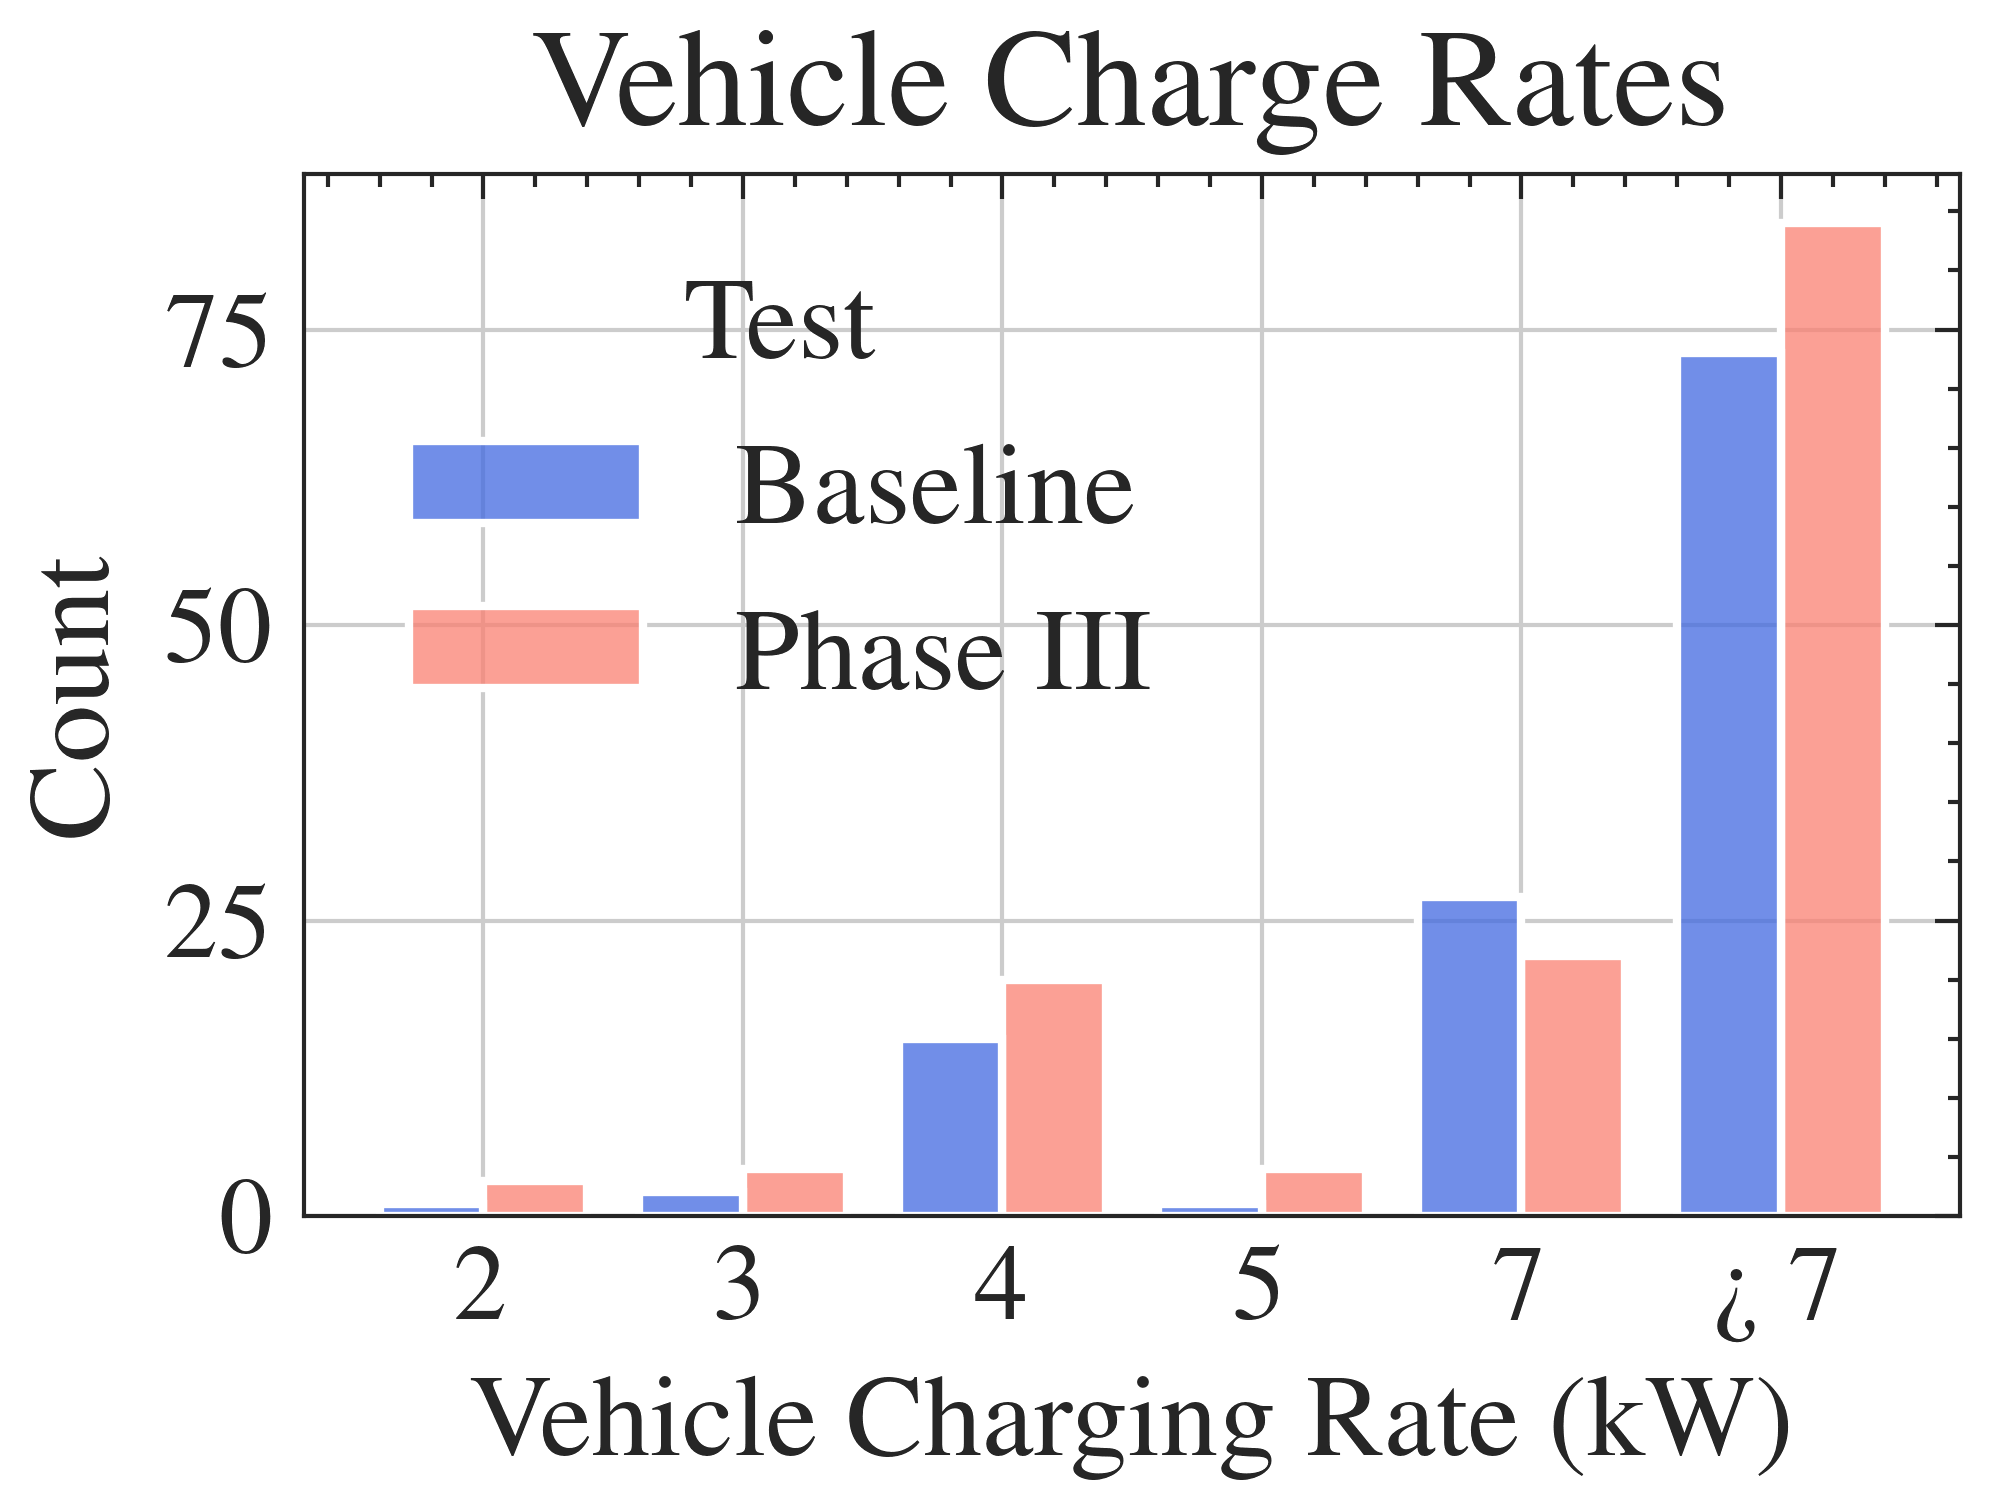

In [179]:
## Vehicle Charge Rates
subset["rate"] = subset["vehicle_maxChgRate_kW"] 
subset['rate'] = np.ceil(subset['rate']).astype(int)
subset = subset.sort_values(by=['rate'])
subset.loc[list(subset[subset["vehicle_maxChgRate_kW"] > 7].index),"rate"] = " > 7"
subset['rate'] = subset['rate'].astype(str)

ax =sns.histplot(subset, x="rate",  hue='Test', color='red', multiple="dodge", shrink=.8,palette=["royalblue", "salmon"])
ax.set_title("Vehicle Charge Rates")
ax.set_xlabel("Vehicle Charging Rate (kW)")
ax.grid()

Text(0.5, 0, 'Weekday')

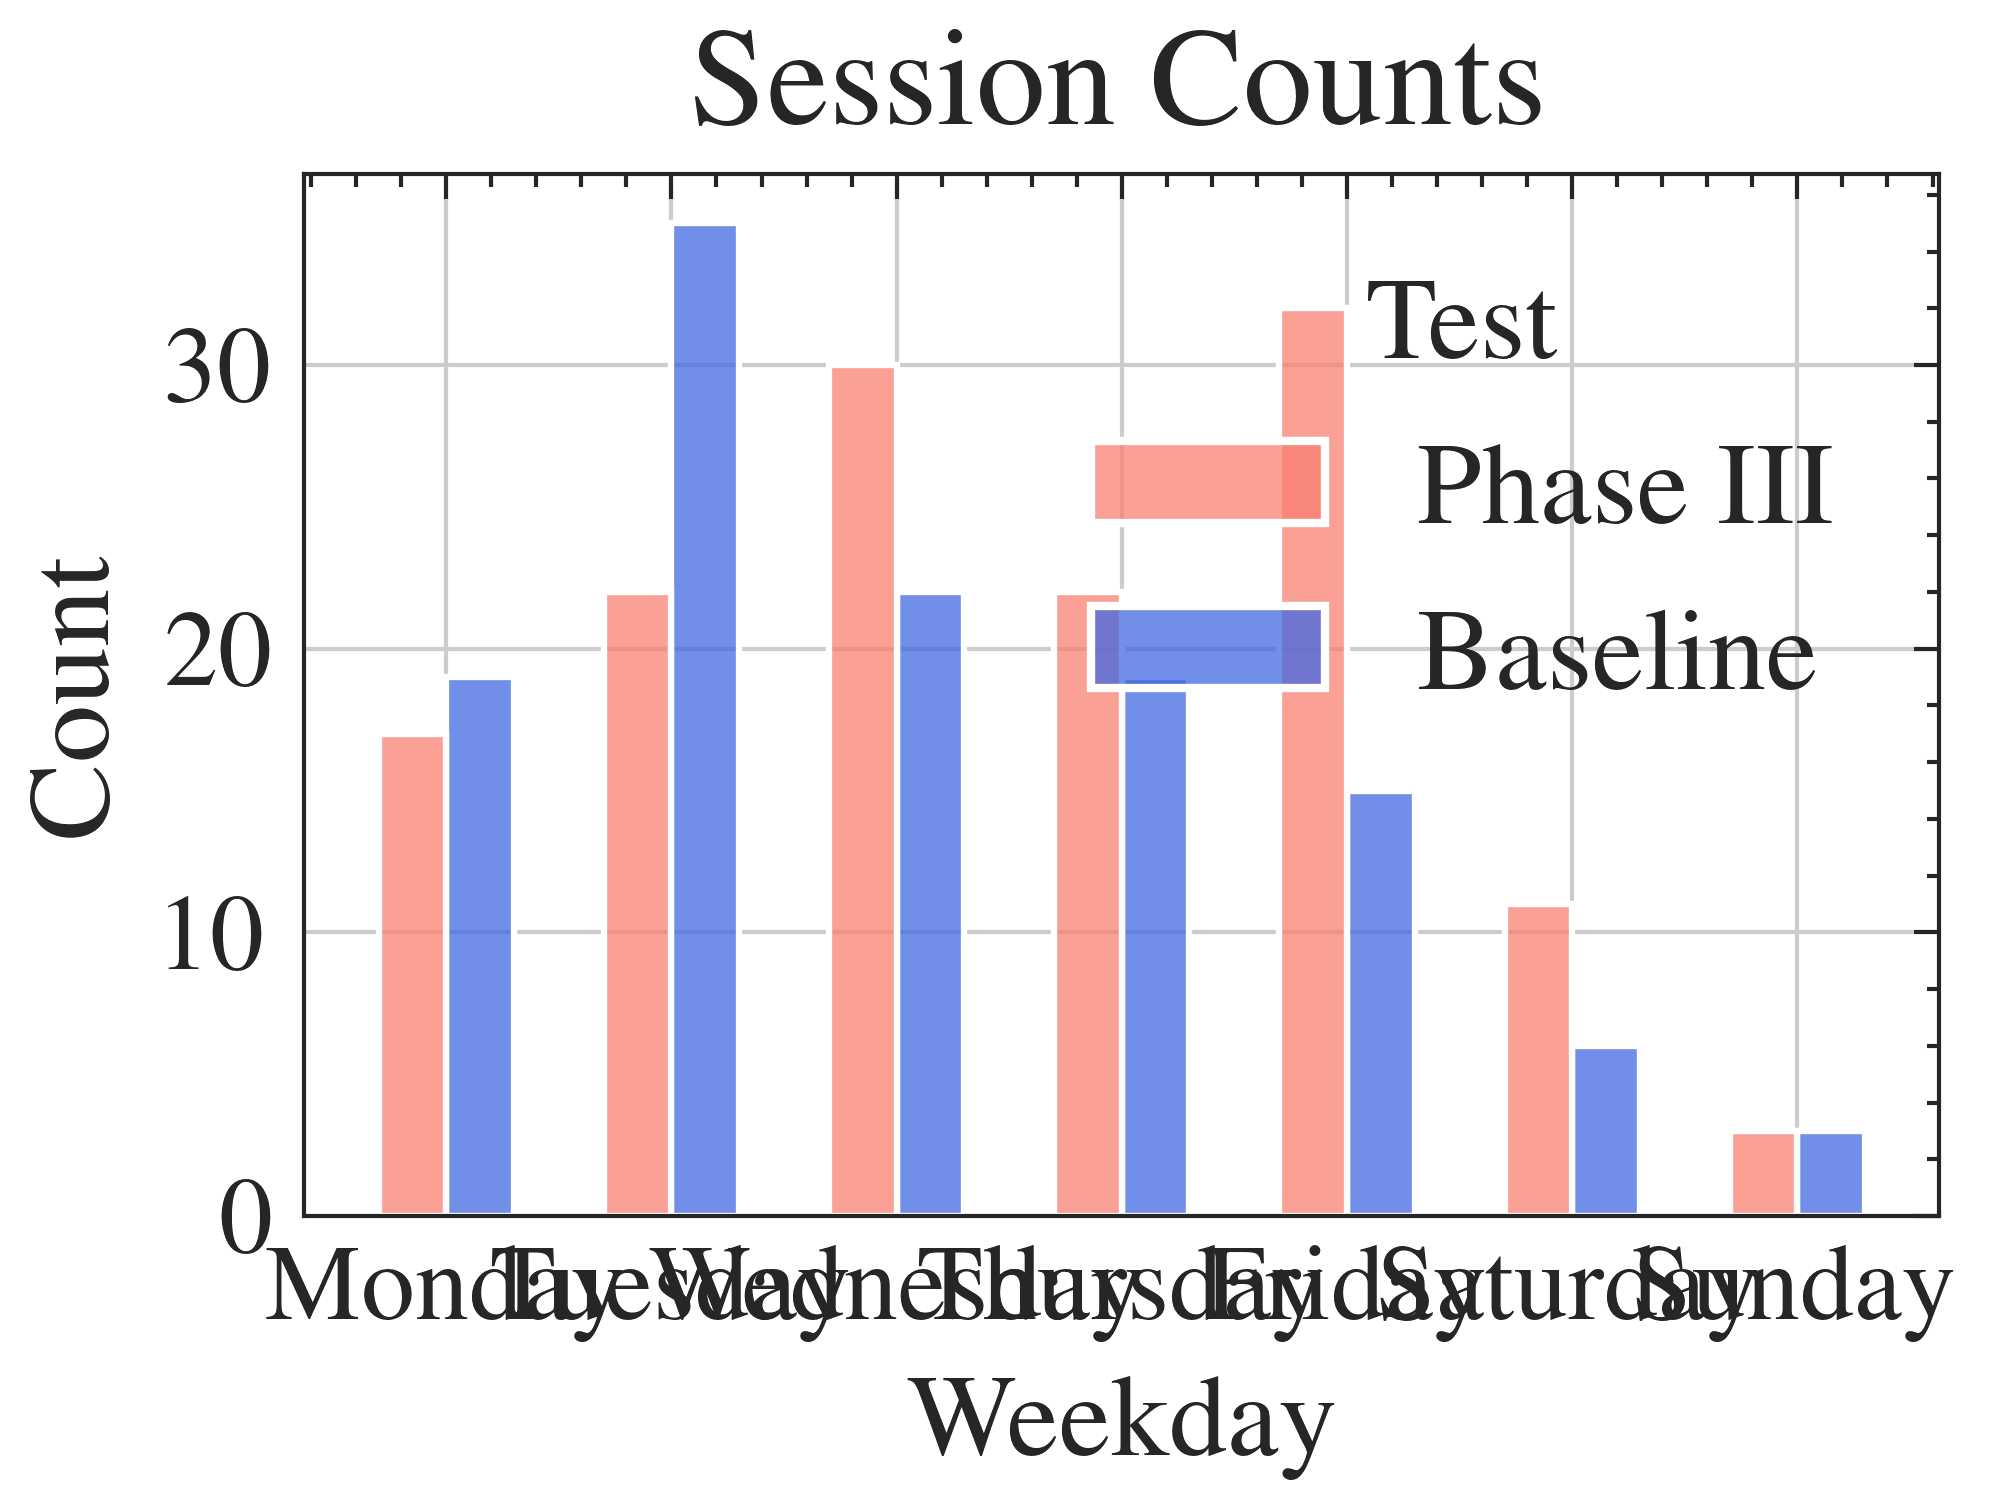

In [180]:
# Sessions countr bar plots 

# h = sns.displot(subset, x="peakPower_kW",  hue='Test', color='red')
# h.set_titles("Vehicle Charge Rates")
# session_counts.reset_index(drop=False, inplace=True)
subset['Weekday'] = subset['connectTime'].dt.weekday
subset = subset.sort_values(by="Test", ascending=False)
subset = subset.sort_values(by="Weekday")


subset["Weekday"] = subset["Weekday"].replace({0:"Monday",1:"Tuesday",2:"Wednesday", 3:"Thursday",4:"Friday",5:"Saturday",6:"Sunday"})

ax = sns.histplot(subset, x="Weekday", hue='Test', color='red', multiple="dodge", shrink=.6, palette=["salmon","royalblue"])
ax.set_title("Session Counts")
ax.grid()
ax.set_xlabel("Weekday")

In [181]:
phaseIII['Level'] = 'High'
phaseIII['Level (kW)'] = 6.6
idx = phaseIII['possible_maxChgRate_kW'] < 6
phaseIII.loc[(phaseIII[idx]).index, 'Level'] = 'Low'
phaseIII.loc[(phaseIII[idx]).index, 'Level (kW)'] = 3.3



baseline['Level'] = 'High'
baseline.loc[(baseline[baseline['possible_maxChgRate_kW'] < 6]).index, 'Level'] = 'Low'

# phaseIII = phaseIII[phaseIII['Level']=='High']
# baseline = baseline[baseline['Level']=='High']

baseline['date'] = baseline['connectTime'].dt.floor(freq='1d')
phaseIII['date'] = phaseIII['connectTime'].dt.floor(freq='1d')

baseline_daily = baseline.groupby(["date","choice","Level"]).sum()
phaseIII_daily = phaseIII.groupby(["date","choice","Level"]).sum()

phaseIII_daily["Sessions Count"] = phaseIII.groupby(["date","choice","Level"]).count()['userId']
baseline_daily["Sessions Count"] = baseline.groupby(["date","choice","Level"]).count()['userId']




In [182]:
# print(phaseIII['reg_centsPerHr'].values.mean(), phaseIII['sch_centsPerHr'].values.mean())
print("Baseline Charges")
print("REG SCH")
print(baseline['reg_centsPerHr'].values.mean(), baseline['sch_centsPerHr'].values.mean())
print("Phase III Charges:High Level")
print("REG SCH")
idx = (phaseIII['Level']=='High')
print(phaseIII[idx]['reg_centsPerHr'].values.mean(), phaseIII[idx]['sch_centsPerHr'].values.mean())

print("Phase III Charges:Low Level")
print("REG SCH")
idx = (phaseIII['Level']=='Low')

print(phaseIII[idx]['reg_centsPerHr'].values.mean(), phaseIII[idx]['sch_centsPerHr'].values.mean())

Baseline Charges
REG SCH
150.0 200.0
Phase III Charges:High Level
REG SCH
222.85585694765862 205.0024419694115
Phase III Charges:Low Level
REG SCH
152.2519320256792 160.51287284760497


In [183]:
(baseline['DurationHrs']- ((baseline['cumEnergy_Wh']/1000) / baseline['possible_maxChgRate_kW'])).mean(),baseline['KPI-2, Slack Time (hr)'].mean()

(1.2647254357615012, 1.3446095874861825)

In [184]:
(phaseIII['DurationHrs']- ((phaseIII['cumEnergy_Wh']/1000) / phaseIII['possible_maxChgRate_kW'])).mean(),phaseIII['KPI-2, Slack Time (hr)'].mean()

(1.0931567296327218, 1.1873973155423327)

REGULAR MEAN: 1.0583560588518264
SCHEDULED MEAN: 1.265647010894551


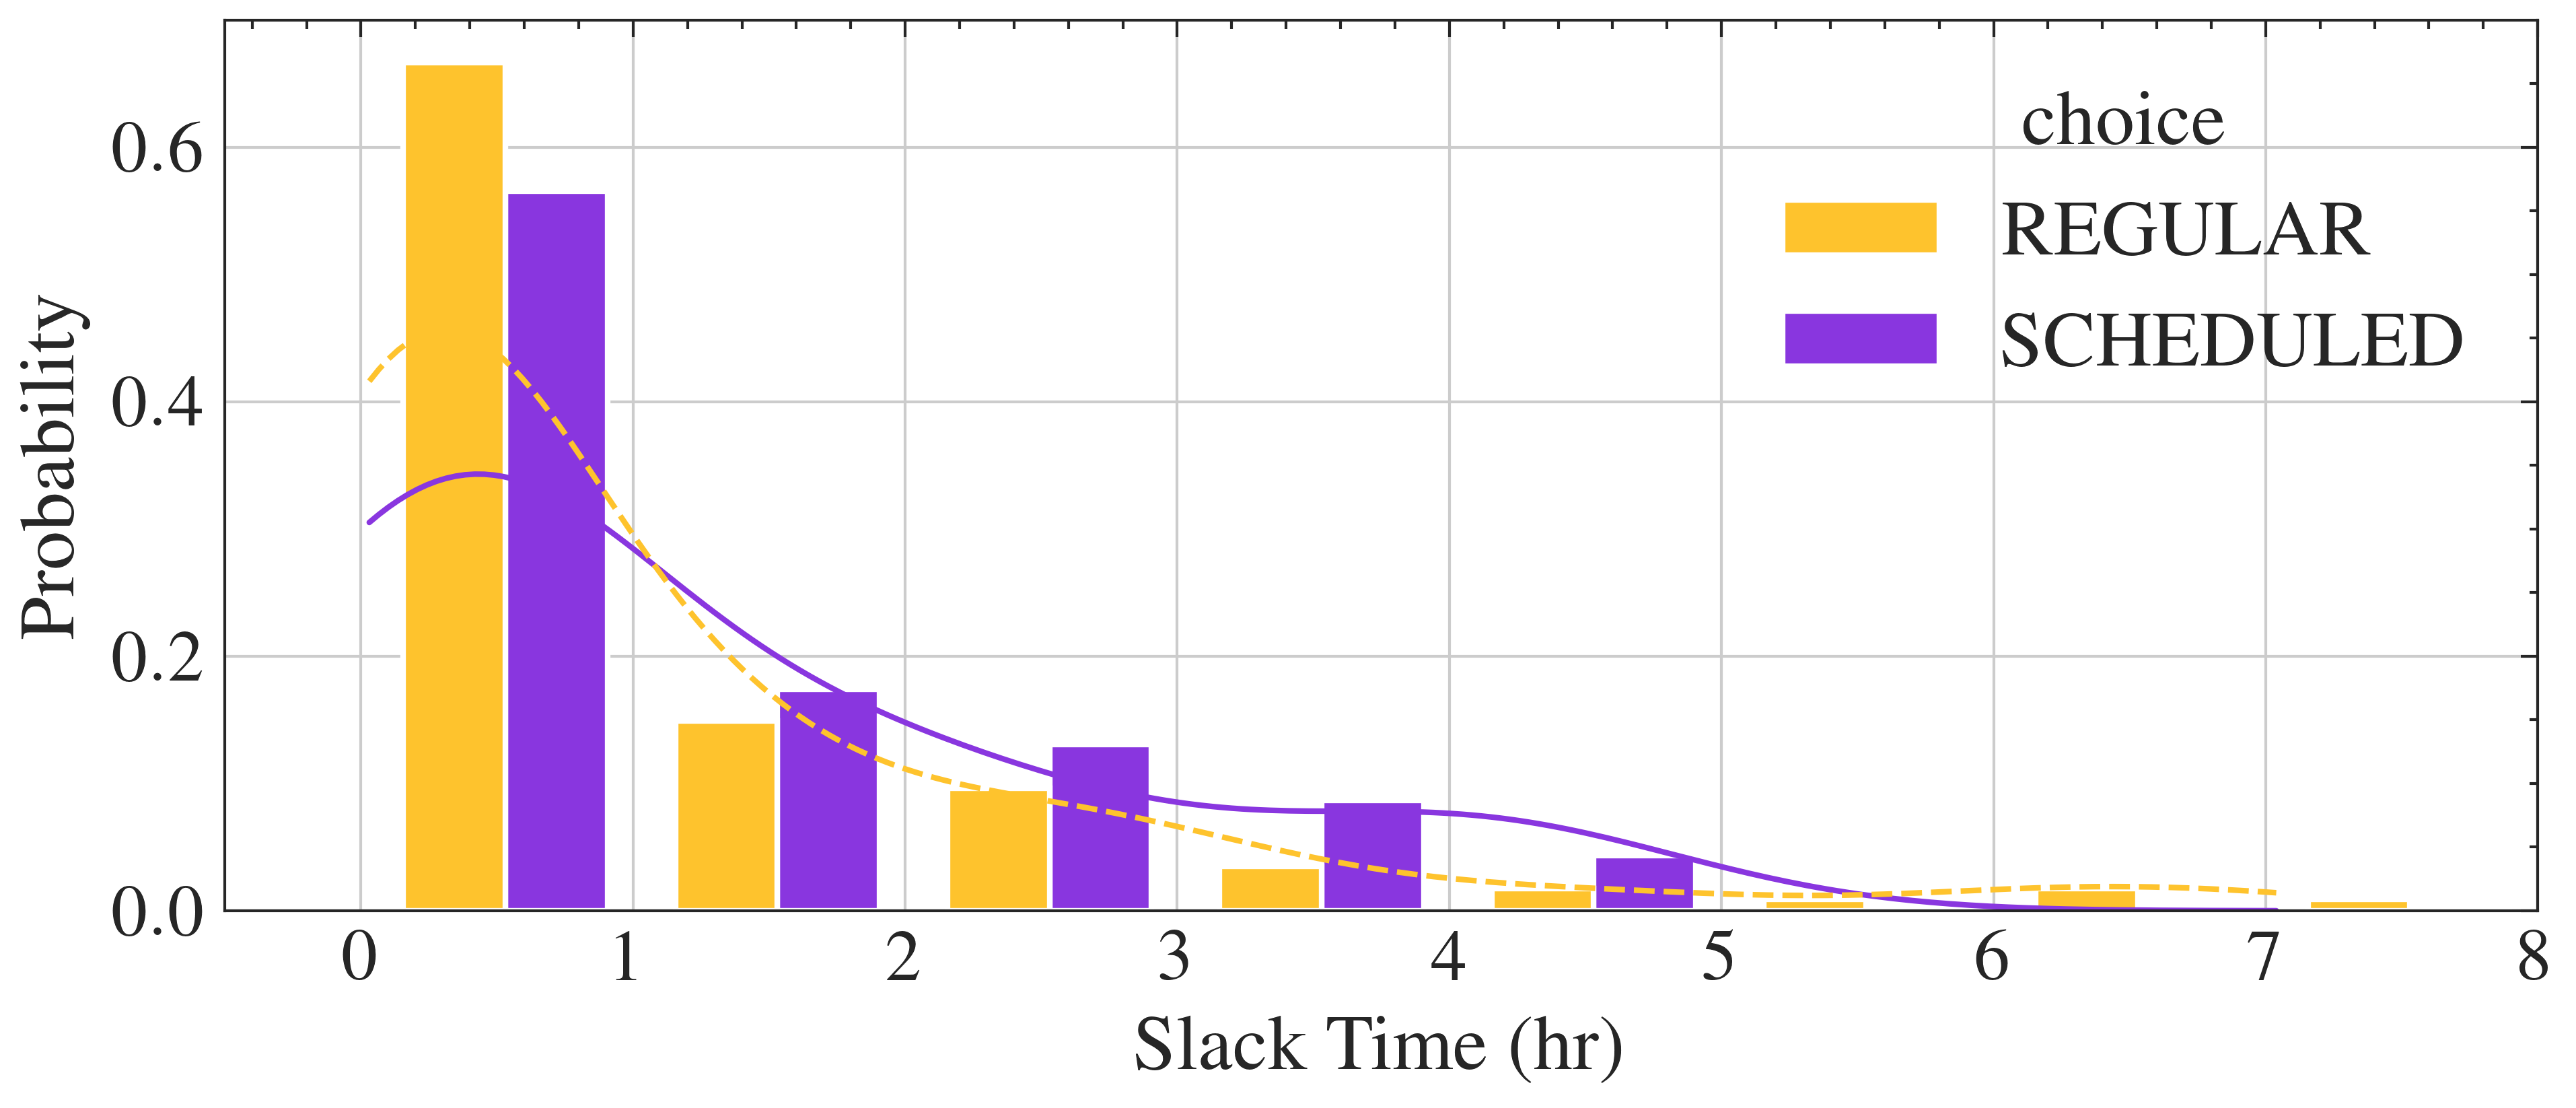

In [280]:
fig,ax = plt.subplots(1,1,figsize=( w,h))
# ax=axes[0]
phaseIII['KPI-2, Slack Time (hr)']  =  (phaseIII['DurationHrs']- ((phaseIII['cumEnergy_Wh']/1000) / phaseIII['possible_maxChgRate_kW']))
sns.histplot(phaseIII, x='KPI-2, Slack Time (hr)', kde=True,
                     stat="probability", 
                     common_norm=False,binwidth=1,
                     hue="choice",palette = {"REGULAR":high_vis_map[4],"SCHEDULED":high_vis_map[3]},
#                      element="poly",
                     multiple="dodge",
                        alpha=1, shrink=0.75,legend=True, ax=ax), # or violin, rug)

ax.set_ylabel('Probability')
ax.set_xlabel('Slack Time (hr)')
# ax.set_xlabel('KPI-2, Slack Time')
# ax.margins(0)
print("REGULAR MEAN:", phaseIII[phaseIII['choice']=='REGULAR']['KPI-2, Slack Time (hr)'].mean())
print("SCHEDULED MEAN:",phaseIII[phaseIII['choice']=='SCHEDULED']['KPI-2, Slack Time (hr)'].mean())
ax.grid(True)
ax.set_xlim(-0.5,8)
# ax=axes[1]
# baseline['KPI-2, Slack Time (hr)']= (baseline['DurationHrs']- ((baseline['cumEnergy_Wh']/1000) / baseline['possible_maxChgRate_kW']))
# print("REGULAR MEAN:", baseline[baseline['choice']=='REGULAR']['KPI-2, Slack Time (hr)'].mean())
# print("SCHEDULED MEAN:",baseline[baseline['choice']=='SCHEDULED']['KPI-2, Slack Time (hr)'].mean())

# sns.histplot(baseline, x='KPI-2, Slack Time (hr)', kde=True,
#                      stat="probability", 
#                      common_norm=False,binwidth=0.5,
# #                      element="poly",
#                      multiple="dodge", 
#                         alpha=0.5, shrink=0.75,legend=True, ax=ax), # or violin, rug)
# ax.set_ylabel('Probability')
# ax.set_xlabel('Slack Time (hr)')
# ax.legend().set_title('')
# ax.legend()
plt.savefig("Figures/slack_time.pdf", transparent=True)
# ax.grid(True)

In [269]:
high_vis_map

['#0d49fb', '#e6091c', '#26eb47', '#8936df', '#fec32d', '#25d7fd']

In [186]:
phaseIII['KPI-2, Slack Time (hr)'].max()

7.038833939393939

In [187]:
phaseIII.groupby('choice').mean()['connectedDuration_Hrs']
baseline.groupby('choice').mean()['connectedDuration_Hrs']

choice
REGULAR      3.928324
SCHEDULED    1.842500
Name: connectedDuration_Hrs, dtype: float64

In [188]:
print(phaseIII.groupby('choice').mean()["Total Energy Delivered (kWh)"])
baseline.groupby('choice').mean()["Total Energy Delivered (kWh)"]

choice
REGULAR      14.623308
SCHEDULED    18.154828
Name: Total Energy Delivered (kWh), dtype: float64


choice
REGULAR      14.344985
SCHEDULED    10.080000
Name: Total Energy Delivered (kWh), dtype: float64

In [189]:
phaseIII_daily['Mean Cost ($/kWh)'] = phaseIII_daily['Charging Cost (cents)'] / ( phaseIII_daily['Total Energy Delivered (kWh)']/ 1000)
baseline_daily['Mean Cost ($/kWh)'] = baseline_daily['Charging Cost (cents)'] / ( baseline_daily['cumEnergy_Wh']/ 1000)

phaseIII_daily['Mean Revenue ($/kWh)'] = phaseIII_daily['Charging Revenue (cents)'] / ( phaseIII_daily['Total Energy Delivered (kWh)']/ 1000)
baseline_daily['Mean Revenue ($/kWh)'] = baseline_daily['Charging Revenue (cents)'] / ( baseline_daily['cumEnergy_Wh']/ 1000)

phaseIII_daily['Mean Cost per Session ($/session)'] = phaseIII_daily['Charging Cost (cents)'] / ( phaseIII_daily['Sessions Count']/ 1000)
baseline_daily['Mean Cost per Session ($/session)'] = baseline_daily['Charging Cost (cents)'] / ( baseline_daily['Sessions Count']/ 1000)

phaseIII_daily['Mean Revenue per Session ($/session)'] = phaseIII_daily['Charging Revenue (cents)'] / ( phaseIII_daily['Sessions Count']/ 1000)
baseline_daily['Mean Revenue per Session ($/session)'] = baseline_daily['Charging Revenue (cents)'] / ( baseline_daily['Sessions Count']/ 1000)


In [190]:
print((phaseIII['Charging Cost (cents)'] / 100).sum() / (phaseIII['cumEnergy_Wh']/ 1000).sum(), (baseline['Charging Cost (cents)'] / 100).sum() /   ( baseline['cumEnergy_Wh']/ 1000).sum())
print((phaseIII['Charging Revenue (cents)'] / 100).sum() / ( phaseIII['cumEnergy_Wh']/ 1000).sum(), (baseline['Charging Revenue (cents)'] / 100).sum() /   ( baseline['cumEnergy_Wh']/ 1000).sum())

0.18347388739321271 0.19472586493054667
0.5299719144127589 0.42341065986413573


In [191]:

phaseIII_daily.reset_index(drop=False,inplace=True)
baseline_daily.reset_index(drop=False,inplace=True)

In [192]:
# baseline[baseline['connectedNotStarted (N)'] > 8]['connectedNotStarted (N)'] * 5

5.0313638575084285 5.031363857508428
5.256918687269901 5.2569186872699


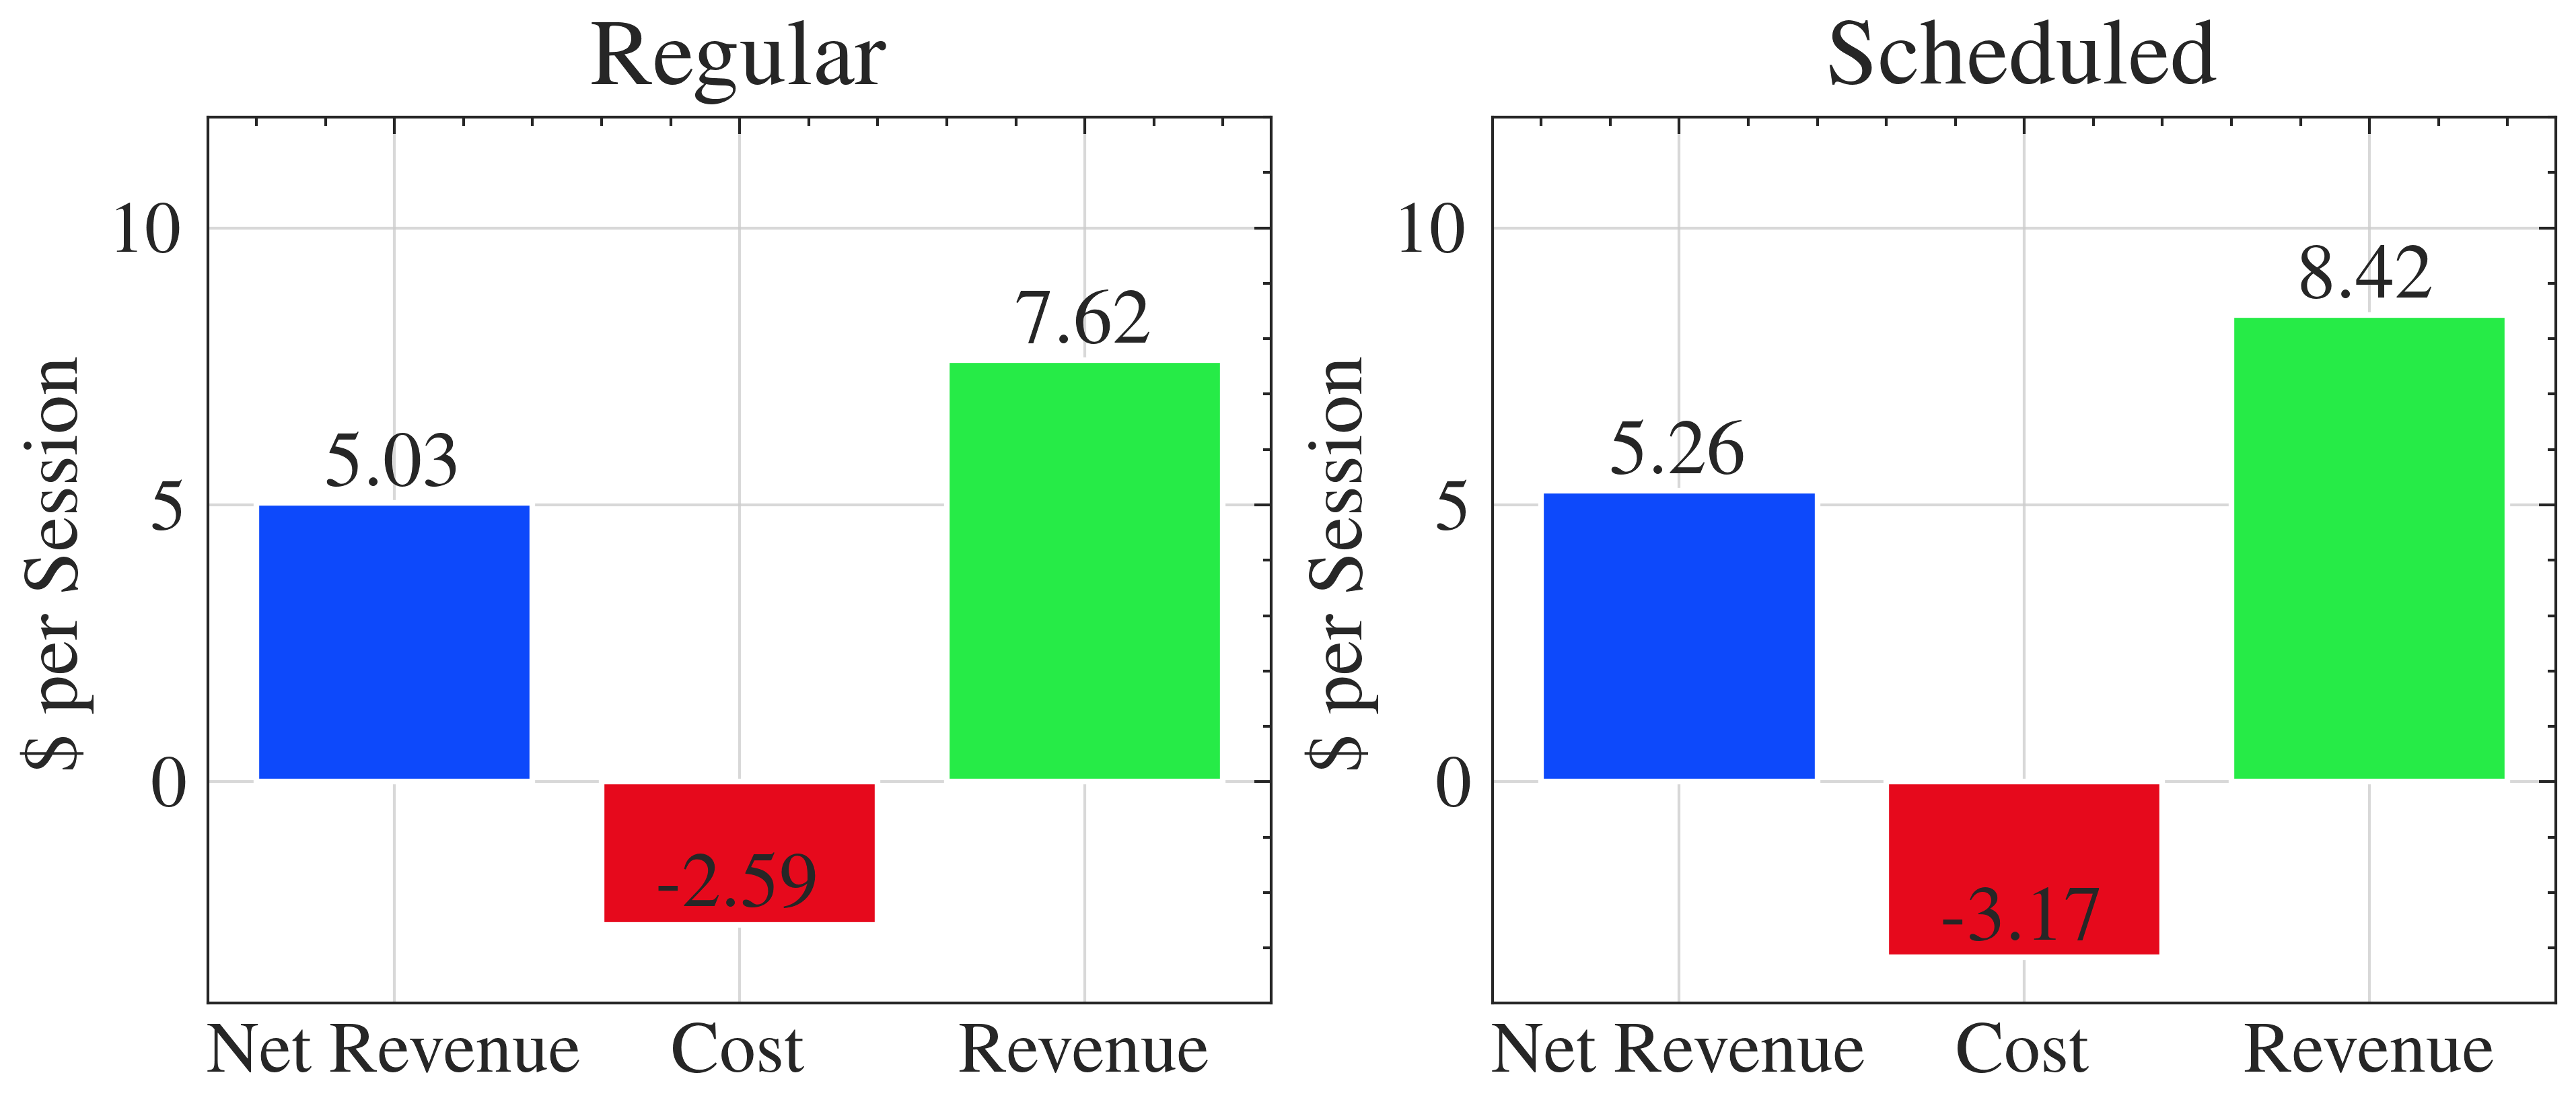

In [193]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
fig,(axes) = plt.subplots(1,2,figsize=(w,h), constrained_layout=True)
# Create dataset
ax = axes[0]

p3_reg_sessions = len((phaseIII[(phaseIII['choice'] =='REGULAR')]))
p3_sch_sessions = len((phaseIII[(phaseIII['choice'] =='SCHEDULED')]))


net_revenue = (phaseIII[(phaseIII['choice'] =='REGULAR') ]['KPI-1, Net Revenue'].sum() / 100) / p3_reg_sessions
cost = (phaseIII[(phaseIII['choice'] =='REGULAR') ]['Charging Cost (cents)'].sum() / 100)  /  p3_reg_sessions
revenue = (phaseIII[(phaseIII['choice'] =='REGULAR') ]['Charging Revenue (cents)'].sum() / 100)  /  p3_reg_sessions
print(net_revenue,revenue -cost)

height = [revenue-cost, - cost, revenue]
bars = ('Net Revenue', 'Cost', 'Revenue')
x_pos = np.arange(len(bars))

ax.set_title("Regular")
ax.grid(alpha = 0.75)
ax.bar(bars, height, color = high_vis_map[0:3])
ax.set_ylim(-4, 12)
ax.set_ylabel("\$ per Session")
# ax.set_xtick_labels(x_pos, bars)
rects = ax.patches

# # Make some labels.
labels = np.round(np.array(height),2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height , label, ha="center", va="bottom")

net_revenue = (phaseIII[(phaseIII['choice'] =='SCHEDULED') ]['KPI-1, Net Revenue'].sum() / 100) / p3_sch_sessions
cost = (phaseIII[(phaseIII['choice'] =='SCHEDULED') ]['Charging Cost (cents)'].sum() / 100)  /  p3_sch_sessions
revenue = (phaseIII[(phaseIII['choice'] =='SCHEDULED') ]['Charging Revenue (cents)'].sum() / 100)  /  p3_sch_sessions

# # Create bars

ax = axes[1]
ax.set_title("Scheduled")

height = [revenue-cost, - cost, revenue]

print(net_revenue,revenue-cost)
bars = ('Net Revenue', 'Cost', 'Revenue')
x_pos = np.arange(len(bars))
ax.grid(alpha = 0.75)
ax.bar(bars, height, color = high_vis_map[0:3])
ax.set_ylim(-4, 12)
ax.set_ylabel("\$ per Session")

rects = ax.patches

# Make some labels.
labels = np.round(np.array(height),2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height , label, ha="center", va="bottom")

# # Create names on the x-axis
# # Show graphic
# # plt.show()
# plt.savefig("per_session_by_choice_profits.pdf", transparent=True)



In [194]:
phaseIII.columns

Index(['dcosId', 'choice', 'connectTime', 'cumEnergy_Wh', 'Deadline',
       'defaultDeadline', 'Duration', 'DurationHrs', 'energyReq_Wh', 'estCost',
       'lastUpdate', 'peakPower_W', 'power', 'reg_centsPerHr', 'regular',
       'sch_centsPerHr', 'sch_centsPerKwh', 'sch_centsPerOverstayHr',
       'scheduled', 'siteId', 'startChargeTime', 'stationId', 'userId',
       'vehicle_maxChgRate_W', 'vehicle_model', 'timeToStart (s)',
       'peakPower_kW_irl', 'Charging Cost (cents)', 'Charging Revenue (cents)',
       'Total Energy Delivered (kWh)', 'Energy_IRL', 'connectedDuration_Hrs',
       'DepartureTime', 'ArrivalTime', 'P_sch', 'P_reg', 'P_leave',
       'connectedNotStarted (N)', 'peakPower_kW', 'Overstay (hr)',
       'Overstay Penalty (cents)', 'vehicle_maxChgRate_kW',
       'station_maxChgRate_kW', 'possible_maxChgRate_kW', 'KPI-1, Net Revenue',
       'KPI-1, Net Revenue (w/Overstay)', 'KPI-2, Slack Time (hr)',
       'KPI-2, Slack Time_IRL (hr)', 'ArrivalPeriod', 'DeparturePe

1.3446095874861825 1.0931567296327218
1.0583560588518264


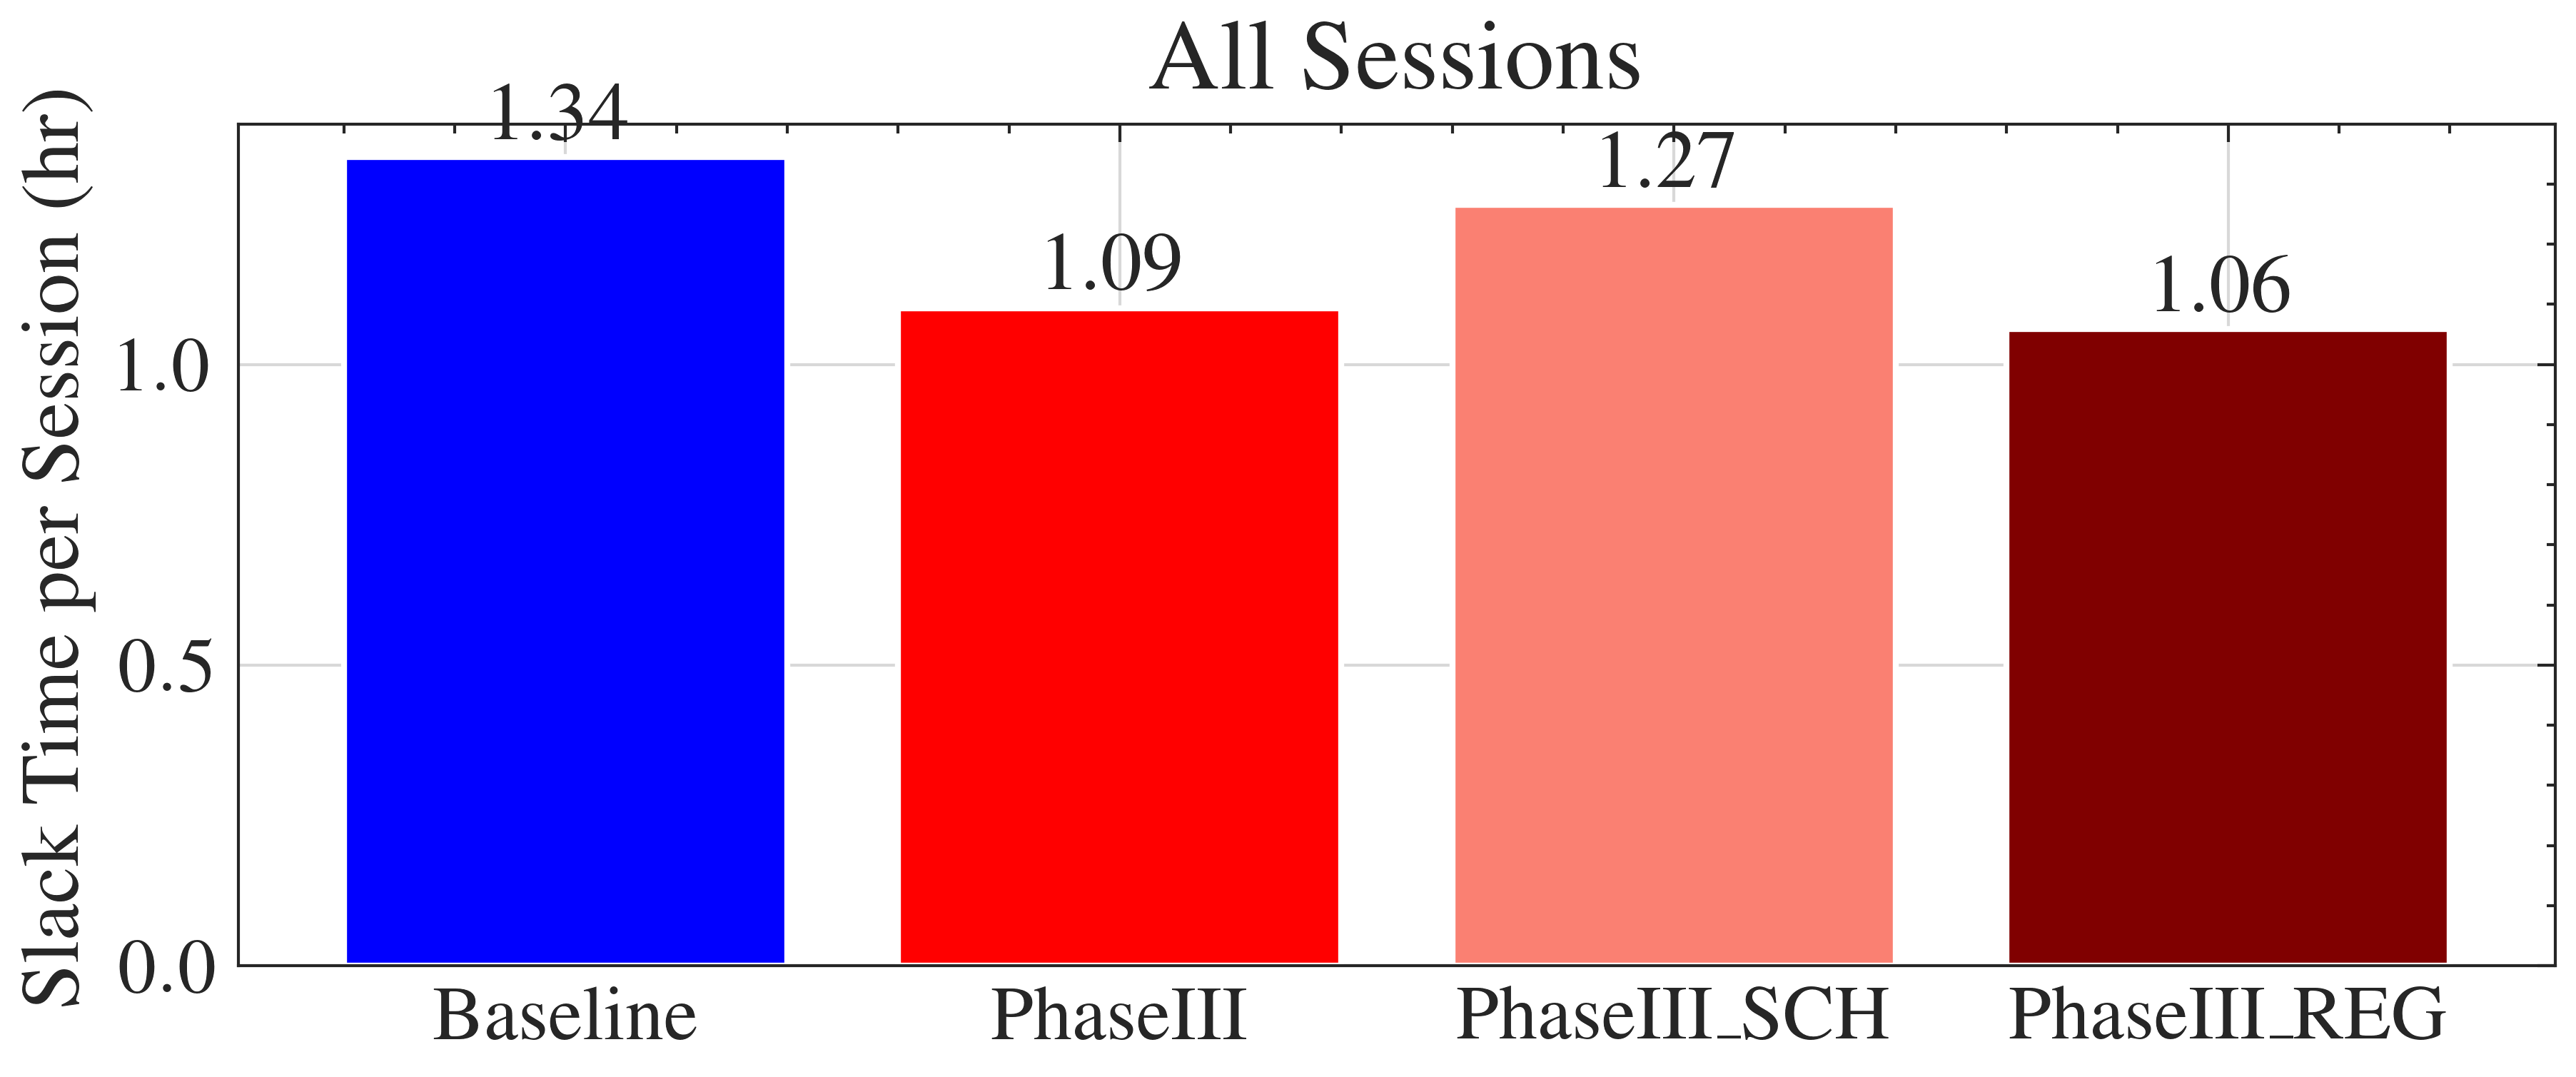

In [120]:
param = 'KPI-2, Slack Time (hr)'
fig,ax = plt.subplots(1,figsize=(6,2.5), constrained_layout=True)

p3_slack = phaseIII[phaseIII['connectedNotStarted (N)']  >= 0][param].sum() / len(phaseIII[phaseIII['connectedNotStarted (N)']  >= 0])
b_slack = baseline[baseline['connectedNotStarted (N)']  >= 0][param].sum() / len(baseline[baseline['connectedNotStarted (N)']  >= 0])

p3_slack_sch = phaseIII[(phaseIII['connectedNotStarted (N)']  >= 0) &(phaseIII['choice'] =='SCHEDULED') ][param].sum() / p3_sch_sessions
p3_slack_reg = phaseIII[(phaseIII['connectedNotStarted (N)']  >= 0) &(phaseIII['choice'] =='REGULAR') ][param].sum() / p3_reg_sessions
print(b_slack,p3_slack)

height = [b_slack, p3_slack, p3_slack_sch, p3_slack_reg]
bars = ('Baseline', 'PhaseIII', 'PhaseIII_SCH', 'PhaseIII_REG')
ax.set_title("All Sessions")
ax.grid(alpha = 0.75)
ax.bar(bars, height, color = ['blue','red','salmon','maroon'])
ax.set_ylim(0, 1.4)
ax.set_ylabel("Slack Time per Session (hr)")

rects = ax.patches

# Make some labels.
labels = np.round(np.array(height),2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height , label, ha="center", va="bottom")

print(height)



In [121]:
high_vis_map

['#0d49fb', '#e6091c', '#26eb47', '#8936df', '#fec32d', '#25d7fd']

[16.36251639130434, -13.932737231884056, 30.295253623188398]
[21.702644048849017, -11.491749331458331, 33.194393380307346]


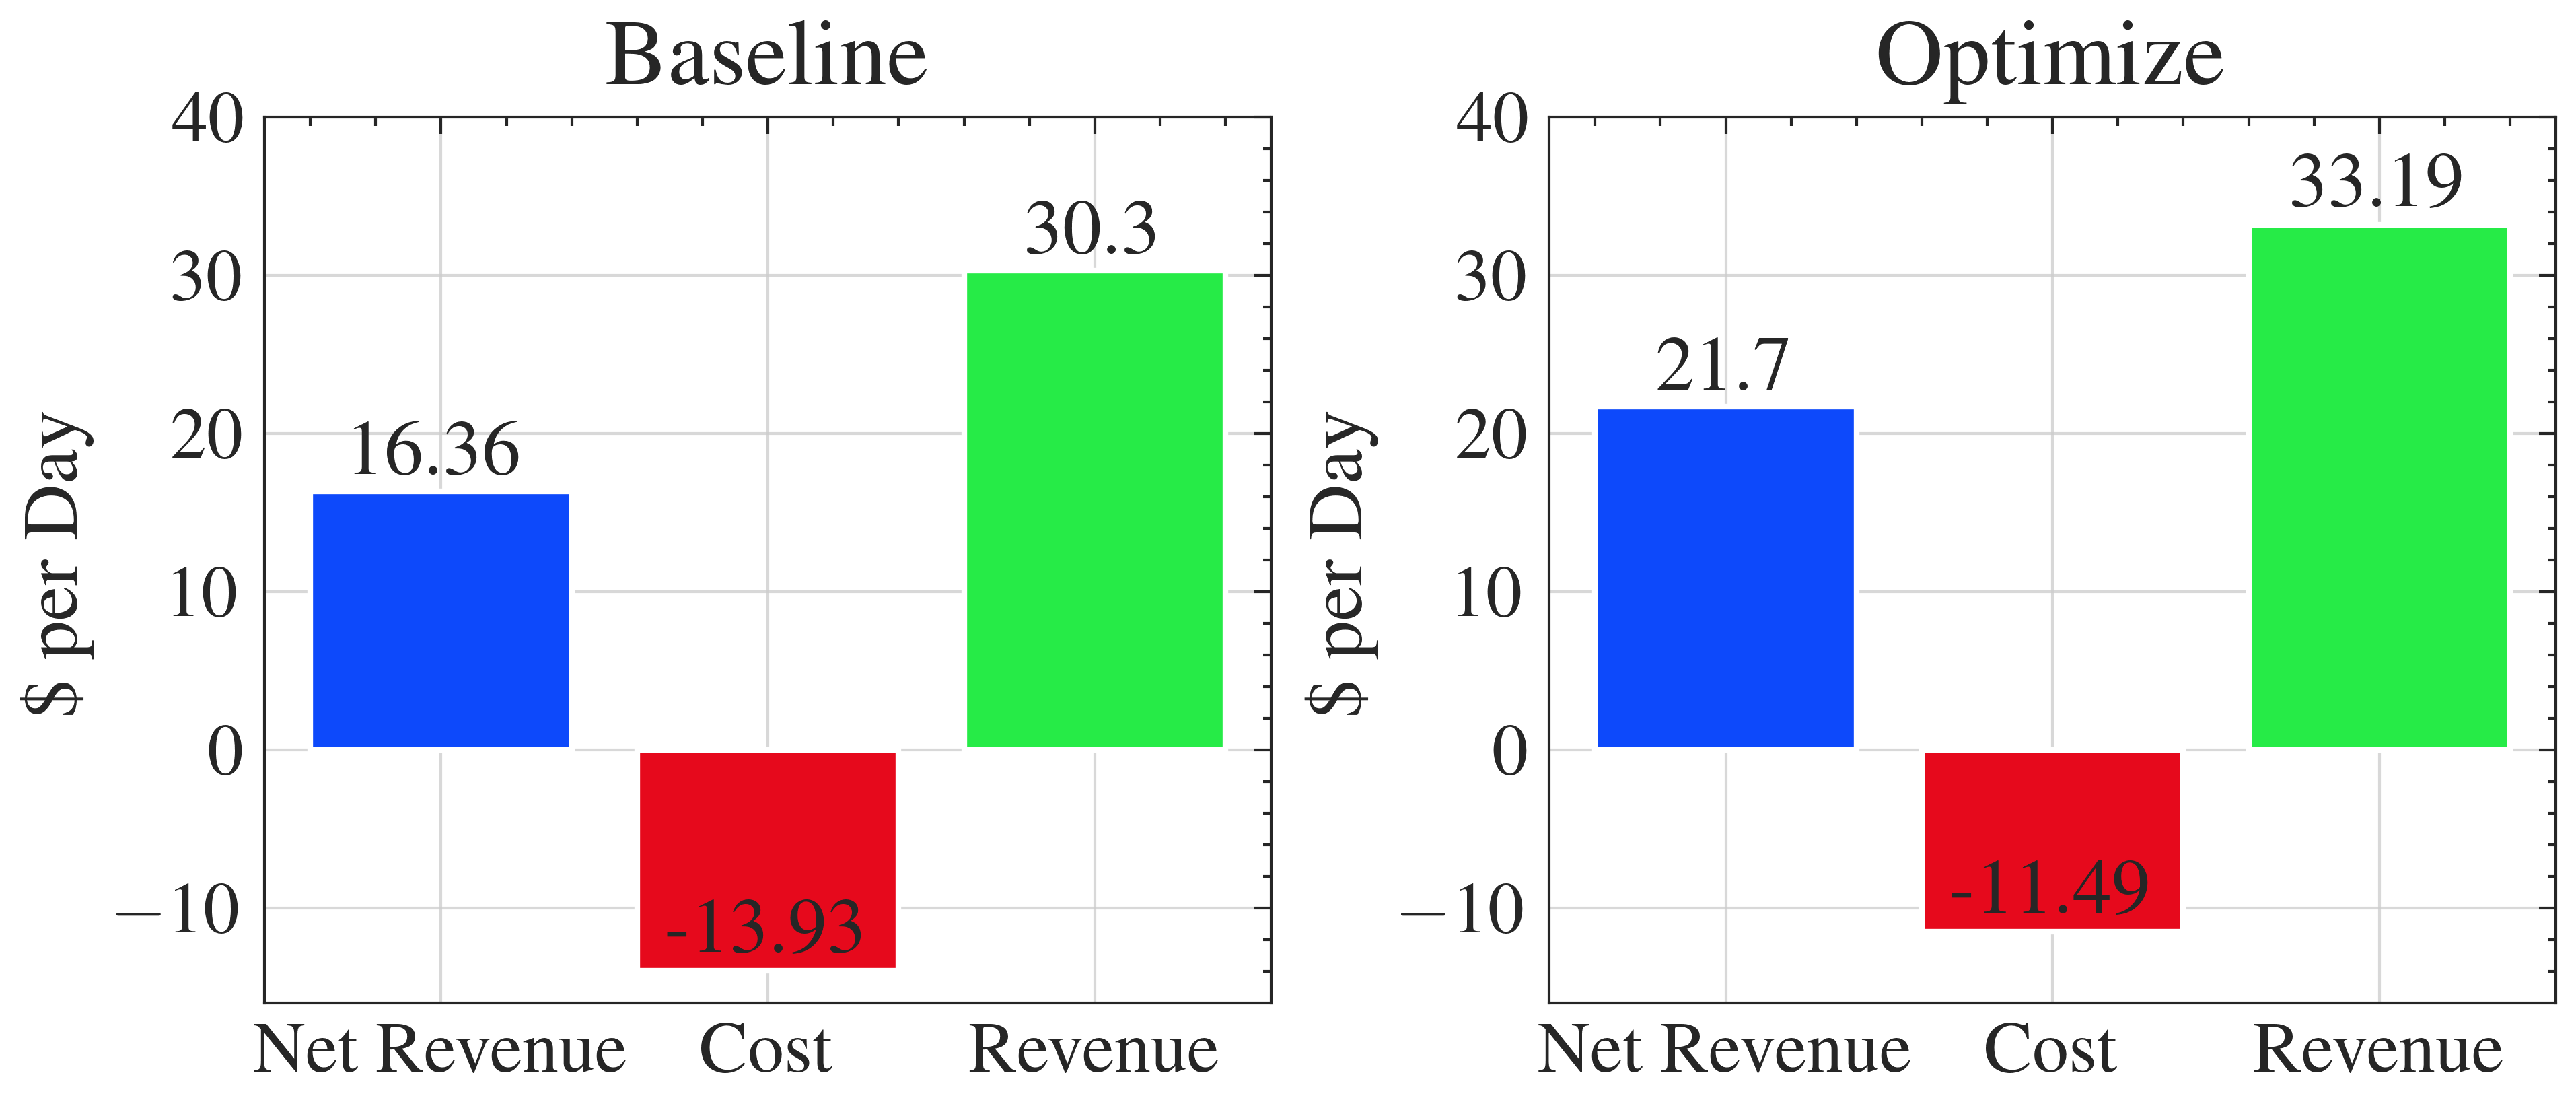

In [122]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
fig,(axes) = plt.subplots(1,2,figsize=(w,h), constrained_layout=True)
# Create dataset
ax = axes[0]
net_revenue = (baseline['KPI-1, Net Revenue'].sum() / 100) /23
cost = (baseline['Charging Cost (cents)'].sum() / 100) / 23
revenue = (baseline['Charging Revenue (cents)'].sum() /100) / 23

height = [revenue - cost, - cost, revenue]
print(height)
 
bars = ('Net Revenue', 'Cost', 'Revenue')
x_pos = np.arange(len(bars))

ax.set_title("Baseline")
ax.grid(alpha = 0.75)
ax.bar(bars, height, color = high_vis_map[0:3])

ax.set_ylim(-16, 40)

ax.set_ylabel("\$ per Day")
# ax.set_xtick_labels(x_pos, bars)

net_revenue = (phaseIII['KPI-1, Net Revenue'].sum() / 100) /  32
cost = (phaseIII['Charging Cost (cents)'].sum() / 100)  /  32
revenue = (phaseIII['Charging Revenue (cents)'].sum() / 100)  / 32
rects = ax.patches

# Make some labels.
labels = np.round(np.array(height),2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height , label, ha="center", va="bottom")

# Create bars

ax = axes[1]
ax.set_title("Optimize")

height = [revenue- cost, - cost, revenue]
bars = ('Net Revenue', 'Cost', 'Revenue')
x_pos = np.arange(len(bars))
ax.grid(alpha = 0.75)
ax.bar(bars, height, color = high_vis_map[0:3])
ax.set_ylim(-16, 40)
ax.set_ylabel("\$ per Day")
# Create names on the x-axis
print(height)
rects = ax.patches

# Make some labels.
labels = np.round(np.array(height),2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height , label, ha="center", va="bottom")

# Show graphic
# plt.show()
plt.savefig("Figures/per_day_profits.pdf", transparent=True)

In [252]:
phaseIII

dcosId   choice         connectTime  cumEnergy_Wh Deadline  \
0      2289  REGULAR 2022-03-22 15:39:06         14529      NaT   
1      2321  REGULAR 2022-03-29 16:58:04         19276      NaT   
2      2371  REGULAR 2022-04-06 11:58:57          1028      NaT   
3      2251  REGULAR 2022-03-16 06:27:25          4128      NaT   
4      2330  REGULAR 2022-03-30 15:54:19         12615      NaT   
..      ...      ...                 ...           ...      ...   
262    2343  REGULAR 2022-04-01 12:07:17          6463      NaT   
267    2258  REGULAR 2022-03-17 08:46:54           106      NaT   
268    2377  REGULAR 2022-04-06 15:49:58          6496      NaT   
270    2215  REGULAR 2022-03-09 08:59:37          8546      NaT   
272    2388  REGULAR 2022-04-08 11:59:04          4916      NaT   

         defaultDeadline         Duration  DurationHrs  energyReq_Wh  \
0    2022-03-23T15:45:00  0 days 04:26:19      4.43861           NaN   
1    2022-03-29T22:00:00  0 days 03:01:47      3.02972           NaN   
2    2022-04-06T15:45:00  0 days 00:20:35      0.34305           NaN   
3    2022-03-16T08:00:00  0 days 01:32:34      1.54277           NaN   
4    1969-12-31T16:00:00  0 days 02:05:41      2.09472           NaN   
..                   ...              ...          ...           ...   
262  2022-04-01T19:30:00  0 days 02:22:14      2.37055           NaN   
267  2022-03-18T09:00:00  0 days 00:03:15      0.05416           NaN   
268  2022-04-06T19:30:00  0 days 02:13:59      2.23305           NaN   
270  2022-03-09T17:00:00  0 days 04:24:08      4.40222           NaN   
272  2022-04-08T15:30:00  0 days 00:50:52      0.84777           NaN   

      estCost  ... KPI-1, Net Revenue  KPI-1, Net Revenue (w/Overstay)  \
0     6.22580  ...         151.078587                       151.078587   
1     8.37727  ...         193.015799                       193.015799   
2     0.93568  ...         386.052700                       386.052700   
3     4.03296  ...         287.671622                       287.671622   
4         NaN  ...         242.659629                              NaN   
..        ...  ...                ...                              ...   
262   3.60542  ...         460.892556                       460.892556   
267   0.64083  ...        1148.709329                      1148.709329   
268   4.16221  ...         232.458837                       232.458837   
270  10.31695  ...         933.612665                       933.612665   
272   2.42445  ...         461.587128                       461.587128   

    KPI-2, Slack Time (hr)  KPI-2, Slack Time_IRL (hr)   ArrivalPeriod  \
0                 1.277383                    1.141323        Off-Peak   
1                 0.109114                   -0.097717            Peak   
2                 0.119377                    0.096713  Super Off-Peak   
3                 0.349362                    0.271063        Off-Peak   
4                 0.183356                    0.058407        Off-Peak   
..                     ...                         ...             ...   
262               0.467429                    0.383825  Super Off-Peak   
267               0.038099                    0.020612        Off-Peak   
268               0.320211                    0.196095        Off-Peak   
270               3.107372                    3.058685        Off-Peak   
272               0.102922                    0.034639  Super Off-Peak   

     DeparturePeriod  duration_bin  Level  Level (kW)       date  
0               Peak           2.5    Low         3.3 2022-03-22  
1               Peak           3.0   High         6.6 2022-03-29  
2           Off-Peak           4.0    Low         3.3 2022-04-06  
3           Off-Peak           2.0    Low         3.3 2022-03-16  
4               Peak           2.5   High         6.6 2022-03-30  
..               ...           ...    ...         ...        ...  
262             Peak           4.0    Low         3.3 2022-04-01  
267   Super Off-Peak 

0.06208333333333333
[16.36251639130434, -13.932737231884056, 30.295253623188398]
[24.770873215515685, -11.491749331458331, 33.194393380307346]


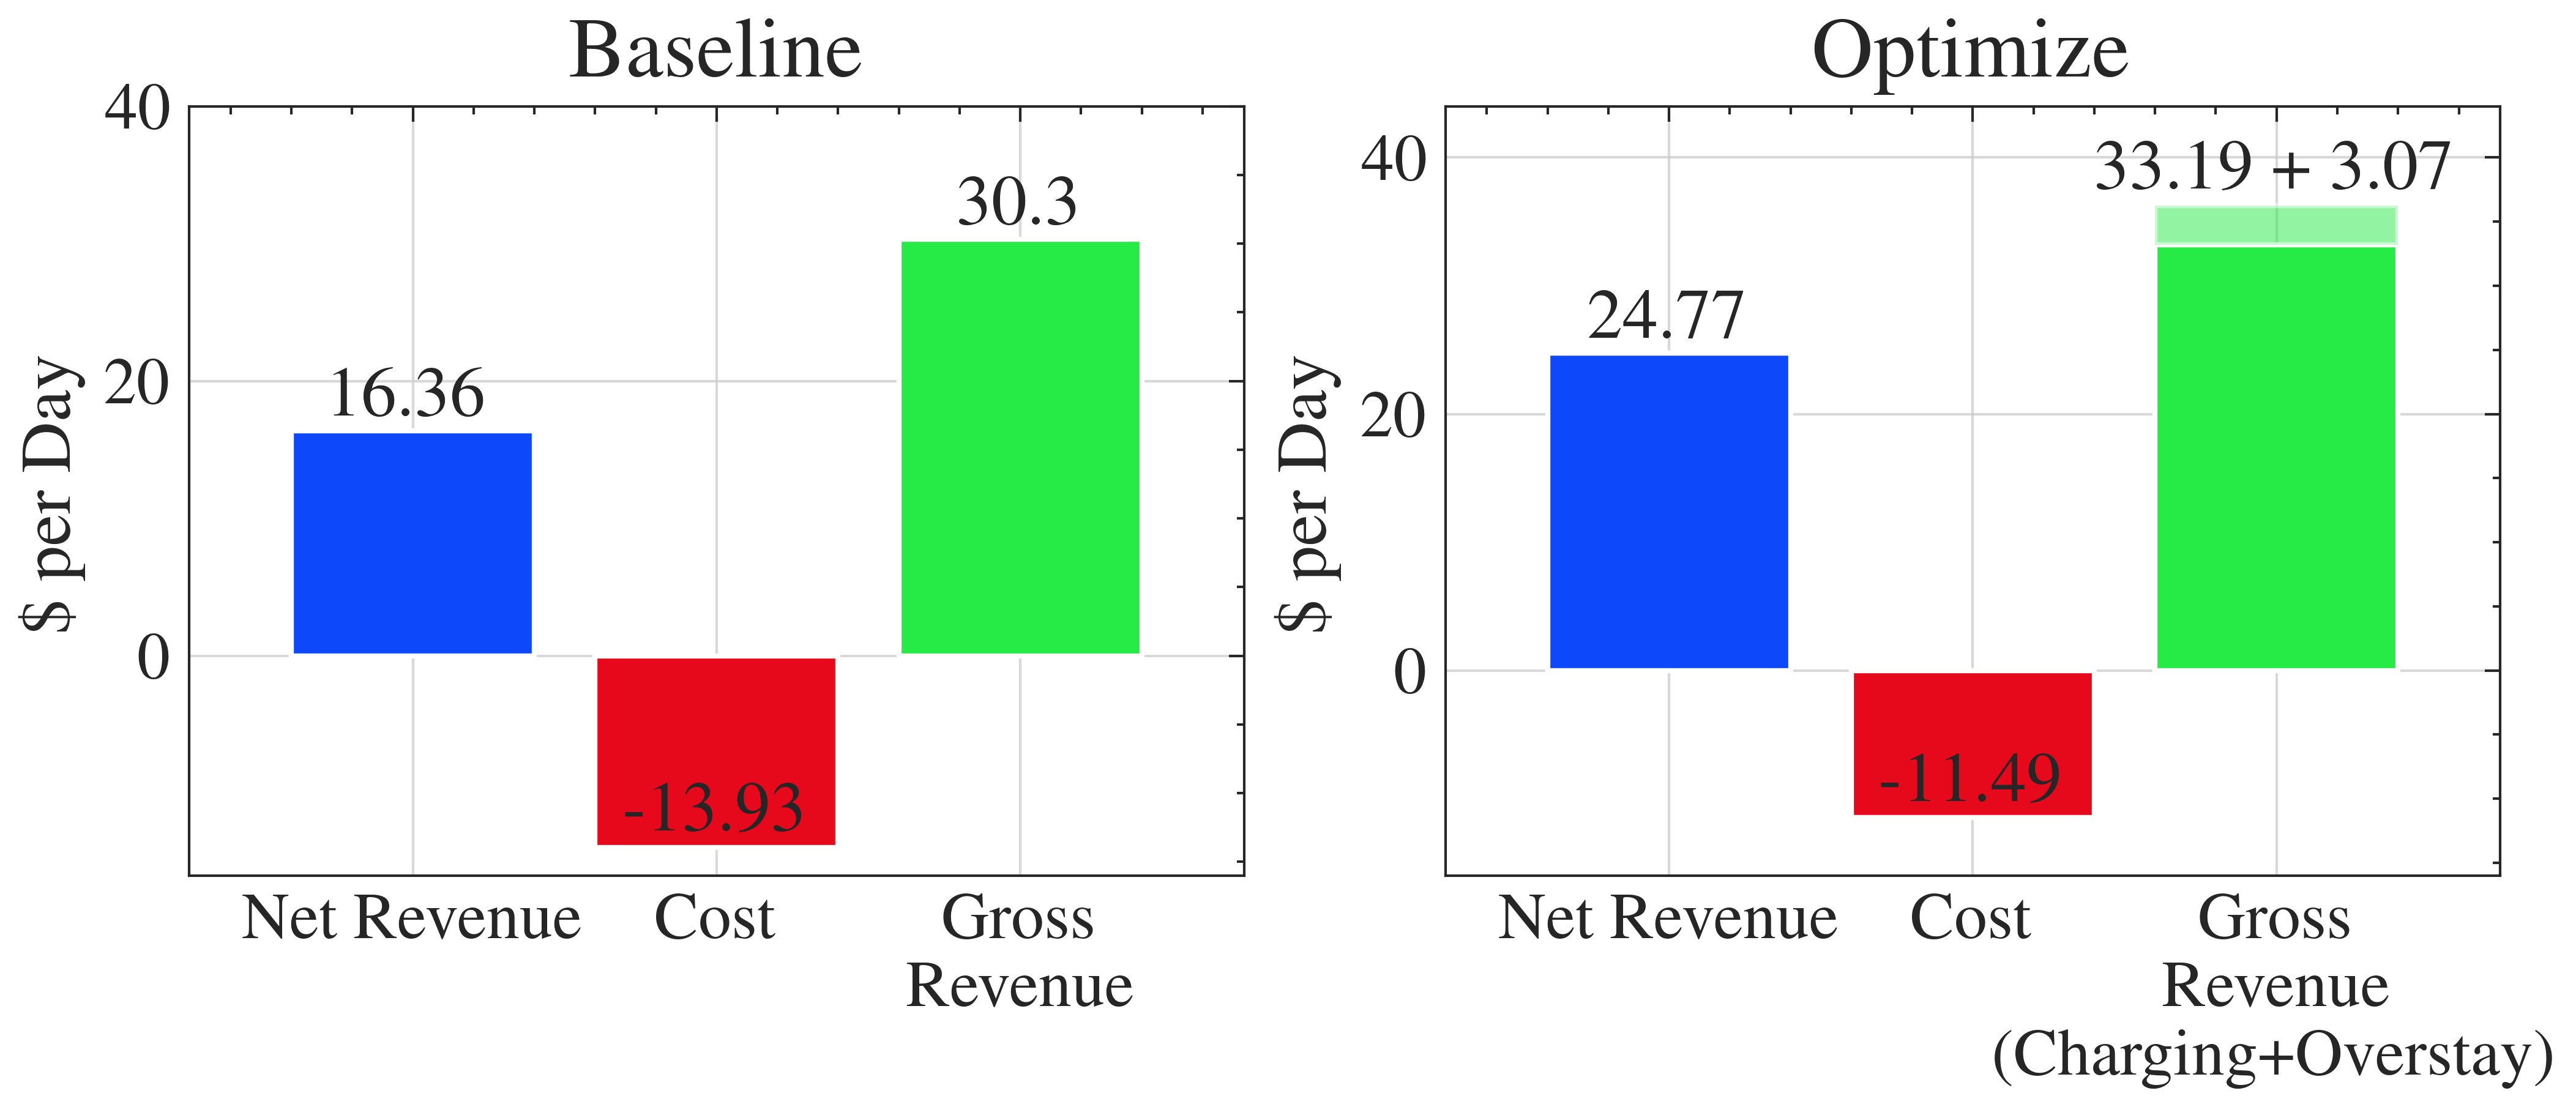

In [289]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
fig,(axes) = plt.subplots(1,2,figsize=(w*1.1,h*1.1), constrained_layout=True)
# Create dataset
ax = axes[0]
# net_revenue = (baseline['KPI-1, Net Revenue'].sum() / 100) /23
cost = (baseline['Charging Cost (cents)'].sum() / 100) / 23
revenue = (baseline['Charging Revenue (cents)'].sum() /100) / 23
overstay_rev = (baseline['Overstay Penalty (cents)'].sum() / 100)  / 32
print(overstay_rev)
height = [revenue - cost, - cost, revenue]
print(height)
 
bars = ('Net Revenue', 'Cost', 'Gross\nRevenue')
x_pos = np.arange(len(bars))

ax.set_title("Baseline")
ax.grid(alpha = 0.75)
ax.bar(bars, height, color = high_vis_map[0:4])
# ax.bar(bars, [0,0,overstay_rev], bottom=height, color = high_vis_map[0:4],alpha=0.25)
ax.set_ylim(-16, 40)
ax.margins(0.12,0)
ax.set_ylabel("\$ per Day")
# ax.set_xtick_labels(x_pos, bars)

# Make some labels.
labels = np.round(np.array(height),2)
rects = ax.patches
for rect, label in list(zip(rects, labels)):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height , label, ha="center", va="bottom")
# rect,label = list(zip(rects, labels))[-1]
# height = rect.get_height()
# ax.text(rect.get_x() + rect.get_width() / 2,height + overstay_rev, "{} + {}".format(label,np.round(overstay_rev,2)), ha="center", va="bottom")
# Create bars



ax = axes[1]
# net_revenue = (phaseIII['KPI-1, Net Revenue'].sum() / 100) /  32
cost = (phaseIII['Charging Cost (cents)'].sum() / 100)  /  32
revenue = (phaseIII['Charging Revenue (cents)'].sum() / 100)  / 32
overstay_rev = (phaseIII['Overstay Penalty (cents)'].sum() / 100)  / 32
rects = ax.patches
ax.set_title("Optimize")

height = [revenue - cost+ overstay_rev, - cost, revenue]
bars = ('Net Revenue', 'Cost', 'Gross\nRevenue\n(Charging+Overstay)')
x_pos = np.arange(len(bars))
ax.grid(alpha = 0.75)
ax.bar(bars, height, color = high_vis_map[0:4])
ax.bar(bars, [0,0,overstay_rev], bottom=height,color = high_vis_map[0:4],alpha=0.5)

ax.set_ylim(-16, 44)
ax.margins(0.12,0)
ax.set_ylabel("\$ per Day")
# Create names on the x-axis
print(height)
rects = ax.patches

# Make some labels.
labels = np.round(np.array(height),2)

for rect, label in list(zip(rects, labels))[:-1]:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2,height, label, ha="center", va="bottom")
rect,label = list(zip(rects, labels))[-1]
height = rect.get_height()
ax.text(rect.get_x() + rect.get_width() / 2,height + overstay_rev , "{} + {}".format(label,np.round(overstay_rev,2)), 
        ha="center", 
        va="bottom")
# Show graphic
# plt.show()
plt.savefig("Figures/per_day_profits.pdf", transparent=True)


### 2. Normalize by Energy 


In [124]:
# plt.style.use(['science','ieee','high-vis'])
# plt.rcParams['font.size'] = 13

In [125]:
baseline_powers = pd.concat(baseline_df_list)
baseline_powers = baseline_powers[baseline_powers['dcosId'].isin(baseline['dcosId'].unique())]
baseline_powers = baseline_powers.reset_index(drop=False)
baseline_powers['Hour'] = baseline_powers['index'].dt.hour
baseline_powers = label_tariff_periods(baseline_powers,'Hour','Charging Period')
baseline_powers ['energy_kwh'] = baseline_powers ['power_w'] * (5 / 60) / 1000

phase_III_powers = pd.concat(phase_III_df_list)
phase_III_powers = phase_III_powers[phase_III_powers['dcosId'].isin(phaseIII['dcosId'].unique())]
phase_III_powers= phase_III_powers.reset_index(drop=False)
phase_III_powers['Hour'] = phase_III_powers['index'].dt.hour
phase_III_powers = label_tariff_periods(phase_III_powers,'Hour','Charging Period')
phase_III_powers ['energy_kwh'] =phase_III_powers ['power_w'] * (5 / 60) / 1000

baseline_powers ['power_w']  =baseline_powers ['power_w'].fillna(0)
phase_III_powers ['power_w']  = phase_III_powers ['power_w'].fillna(0)
len((phase_III_powers[(phase_III_powers['index'].dt.weekday < 5)]['index'].dt.date).unique())
p3_days = len((phase_III_powers['index'].dt.date).unique())
p3_wdays = len((phase_III_powers[(phase_III_powers['index'].dt.weekday < 5)]['index'].dt.date).unique())
b_days = len((baseline_powers['index'].dt.date).unique())
b_wdays = len((baseline_powers[(baseline_powers['index'].dt.weekday < 5)]['index'].dt.date).unique())
print(p3_days, p3_wdays, b_days, b_wdays)

30 23 24 18


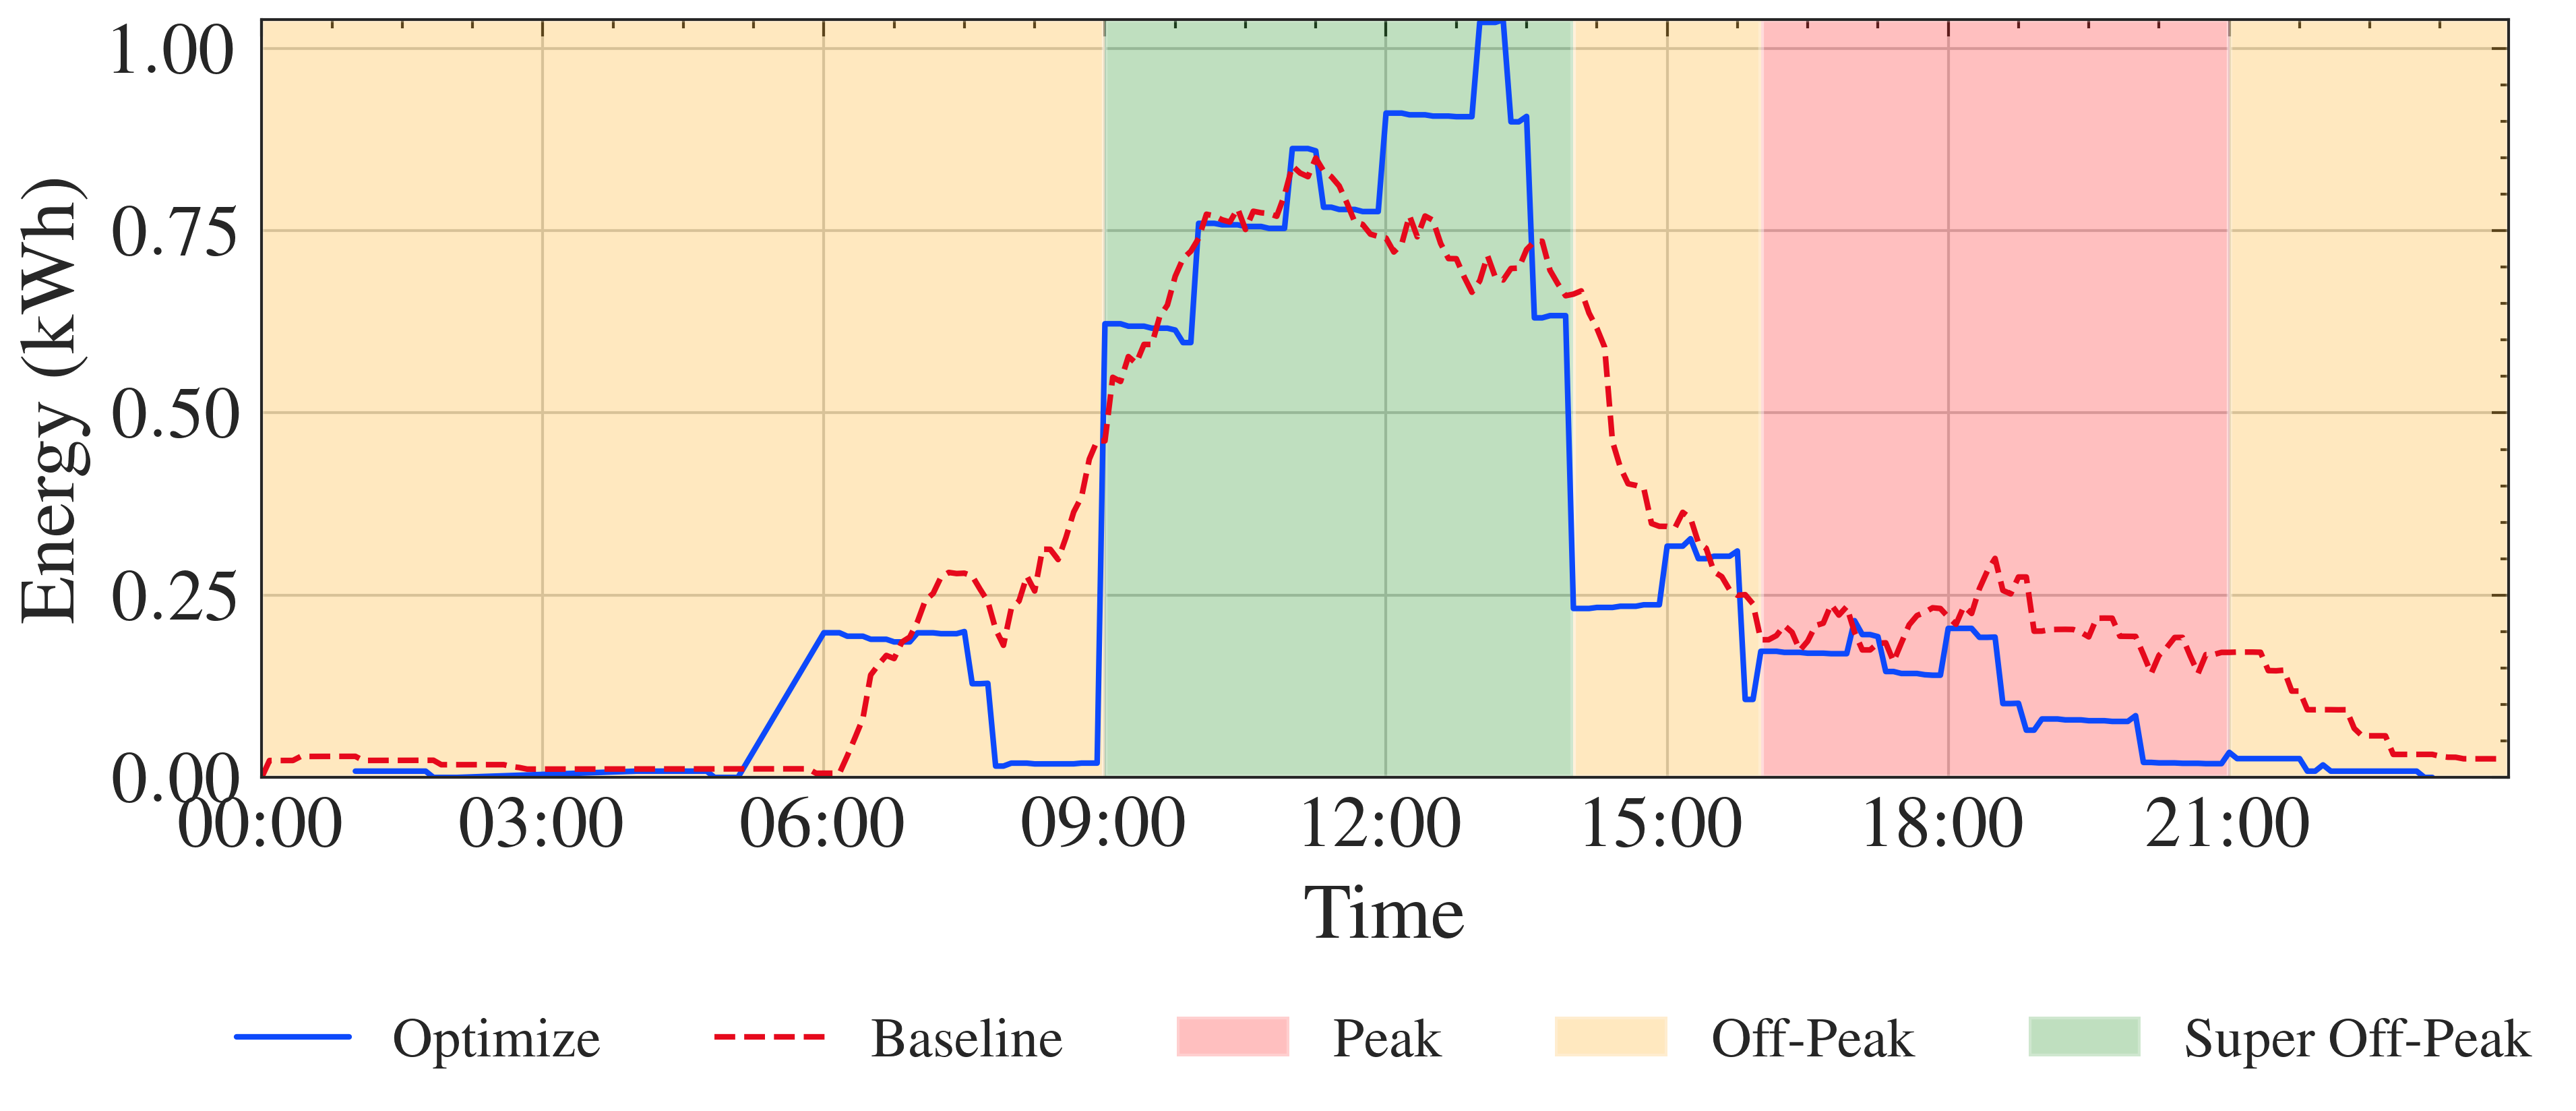

In [126]:
fig,(ax) = plt.subplots(1,1,figsize=(w,h), constrained_layout=True)

plot = phase_III_powers.reset_index(drop=False)
plot['Time'] = plot['index'].dt.time
plot['energy_kwh'] = plot['power_w'] * (5 / 60) / 1000
(
plot.groupby('Time').sum()['energy_kwh']/32).plot(label = 'Optimize', ax=ax)

# val = plot.groupby('Time').sum()['energy_kwh']/30
# std = plot.groupby('Time').std()['energy_kwh']

# ax.fill_between(val.index, val, val+std, alpha = 0.5, color ='red')
# ax.fill_between(val.index, val, val-std, alpha = 0.5, color = 'red')



plot = baseline_powers.reset_index(drop=False)
plot['Time'] = plot['index'].dt.time
plot['energy_kwh'] = plot['power_w'] * (5 / 60) / 1000

# all_data = plot.groupby('Time').sum()['energy_kwh']

(plot.groupby('Time').sum()['energy_kwh'] /22).plot(label = 'Baseline', color = high_vis_map[1],ax=ax)

# val = plot.groupby('Time').sum()['energy_kwh']/22
# std = plot.groupby('Time').std()['energy_kwh']

# ax.fill_between(val.index, val, val+std, alpha = 0.5, color ='black')
# ax.fill_between(val.index, val, val-std, alpha = 0.5, color = 'black')

ax.grid(True)

import datetime
ax.axvspan(datetime.time(16, 0), datetime.time(21, 0), facecolor='red', alpha=0.25,label = 'Peak')
ax.axvspan(datetime.time(21, 0), datetime.time(23, 59), facecolor='orange', alpha=0.25)
ax.axvspan(datetime.time(0, 0), datetime.time(9, 0), facecolor='orange', alpha=0.25)
ax.axvspan(datetime.time(14, 0), datetime.time(16, 0), facecolor='orange', alpha=0.25, label = 'Off-Peak')
ax.axvspan(datetime.time(9, 0), datetime.time(14, 0), facecolor='g', alpha=0.25, label='Super Off-Peak')
ax.margins(0)
# ax.grid(True)

ax.set_xlabel("Time")
ax.legend(bbox_to_anchor=(1, 0.5), loc='center left', ncol=1)
ax.set_xticks([datetime.time(i,0) for i in np.arange(0,24,3)])
ax.set_ylabel('Energy (kWh)')
# ax.set_title('Average Hourly Energy Delivered')
ax.legend(bbox_to_anchor=(0.5, -0.35), loc='center', ncol=5,fontsize=10)
# plt.savefig("energy_delivered.pdf", transparent=True)
fig.savefig('Figures/e_delivered.pdf', dpi=300)
plt.show()



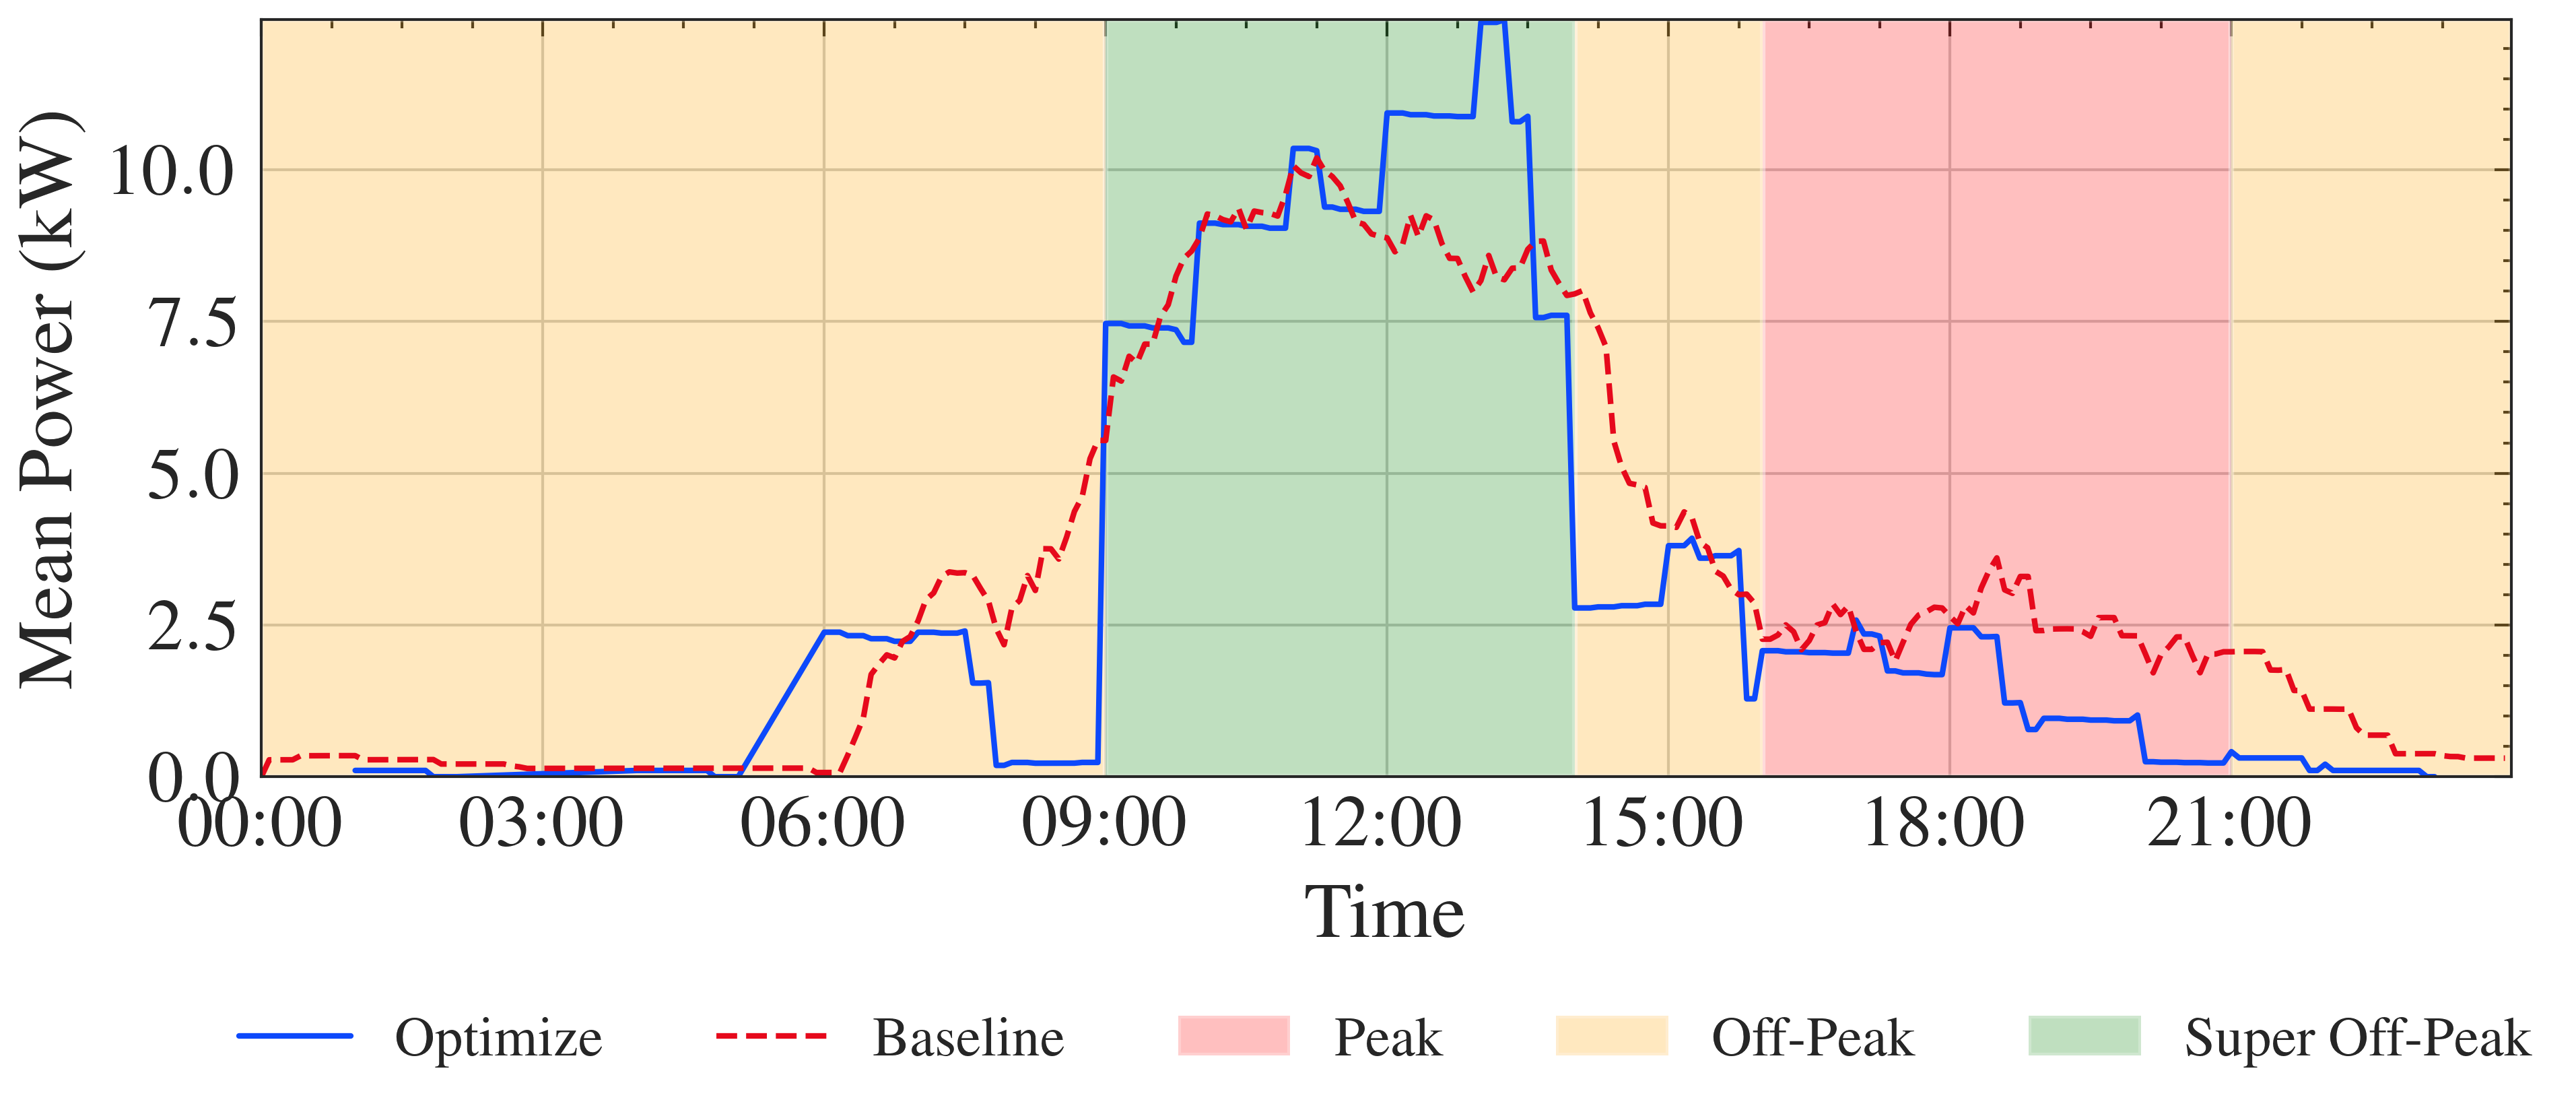

In [127]:
fig,(ax) = plt.subplots(1,1,figsize=(w,h), constrained_layout=True)

plot = phase_III_powers.reset_index(drop=False)
plot['Time'] = plot['index'].dt.time
plot['power_kW'] = plot['power_w'] / 1000
(plot.groupby('Time').sum()['power_kW']/32).plot(label = 'Optimize', ax=ax, 
                                                 color=high_vis_map[0])

# val = plot.groupby('Time').sum()['energy_kwh']/30
# std = plot.groupby('Time').std()['energy_kwh']

# ax.fill_between(val.index, val, val+std, alpha = 0.5, color ='red')
# ax.fill_between(val.index, val, val-std, alpha = 0.5, color = 'red')



plot = baseline_powers.reset_index(drop=False)
plot['Time'] = plot['index'].dt.time
plot['power_kW'] = plot['power_w'] / 1000

# all_data = plot.groupby('Time').sum()['energy_kwh']

(plot.groupby('Time').sum()['power_kW'] /22).plot(label = 'Baseline',
                                                  color=high_vis_map[1],
                                                  ax=ax)

# val = plot.groupby('Time').sum()['energy_kwh']/22
# std = plot.groupby('Time').std()['energy_kwh']

# ax.fill_between(val.index, val, val+std, alpha = 0.5, color ='black')
# ax.fill_between(val.index, val, val-std, alpha = 0.5, color = 'black')

ax.grid(True)

import datetime
ax.axvspan(datetime.time(16, 0), datetime.time(21, 0), facecolor='red', alpha=0.25,label = 'Peak')
ax.axvspan(datetime.time(21, 0), datetime.time(23, 59), facecolor='orange', alpha=0.25)
ax.axvspan(datetime.time(0, 0), datetime.time(9, 0), facecolor='orange', alpha=0.25)
ax.axvspan(datetime.time(14, 0), datetime.time(16, 0), facecolor='orange', alpha=0.25, label = 'Off-Peak')
ax.axvspan(datetime.time(9, 0), datetime.time(14, 0), facecolor='g', alpha=0.25, label='Super Off-Peak')
ax.margins(0)
# ax.grid(True)

ax.set_xlabel("Time")
ax.legend(bbox_to_anchor=(1, 0.5), loc='center left', ncol=1)
ax.set_xticks([datetime.time(i,0) for i in np.arange(0,24,3)])
ax.set_ylabel('Mean Power (kW)')
# ax.set_title('Average Hourly Energy Delivered')
ax.legend(bbox_to_anchor=(0.5, -0.35), loc='center', ncol=5,fontsize=10)
# plt.savefig("energy_delivered.pdf", transparent=True)
fig.savefig('Figures/p_delivered.pdf', dpi=300)
# 



In [63]:
# carbon_intensity  = carbon_intensity.rename(columns = {'CO2/MW':'mtCO2/MWh'})
# # carbon_intensity['kgCO2/kWh'] = carbon_intensity['mtCO2/MWh'] * 10**(9) / 10**(3)
# carbon_intensity['Time'] = pd.to_datetime(carbon_intensity['Date Time']).dt.time
# carbon_intensity.groupby('Time')['mtCO2/MWh'].mean().plot()

In [128]:
phase_III_powers['duration_min'] = 5
baseline_powers['duration_min'] = 5

In [129]:
b_energy = baseline_powers.groupby('Charging Period').sum()[['energy_kwh','duration_min']]
p3_energy = phase_III_powers.groupby('Charging Period').sum()[['energy_kwh','duration_min']]

In [130]:
(b_energy / b_energy.sum())

energy_kwh  duration_min
Charging Period                          
Off-Peak           0.280010      0.442273
Peak               0.159673      0.189915
Super Off-Peak     0.560317      0.367812

In [131]:
(p3_energy / p3_energy.sum())

energy_kwh  duration_min
Charging Period                          
Off-Peak           0.169377      0.308169
Peak               0.108412      0.110935
Super Off-Peak     0.722211      0.580896

In [132]:
plot = phaseIII[phaseIII['choice'] == 'SCHEDULED']
plot.columns

Index(['dcosId', 'choice', 'connectTime', 'cumEnergy_Wh', 'Deadline',
       'defaultDeadline', 'Duration', 'DurationHrs', 'energyReq_Wh', 'estCost',
       'lastUpdate', 'peakPower_W', 'power', 'reg_centsPerHr', 'regular',
       'sch_centsPerHr', 'sch_centsPerKwh', 'sch_centsPerOverstayHr',
       'scheduled', 'siteId', 'startChargeTime', 'stationId', 'userId',
       'vehicle_maxChgRate_W', 'vehicle_model', 'timeToStart (s)',
       'peakPower_kW_irl', 'Charging Cost (cents)', 'Charging Revenue (cents)',
       'Total Energy Delivered (kWh)', 'Energy_IRL', 'connectedDuration_Hrs',
       'DepartureTime', 'ArrivalTime', 'P_sch', 'P_reg', 'P_leave',
       'connectedNotStarted (N)', 'peakPower_kW', 'Overstay (hr)',
       'Overstay Penalty (cents)', 'vehicle_maxChgRate_kW',
       'station_maxChgRate_kW', 'possible_maxChgRate_kW', 'KPI-1, Net Revenue',
       'KPI-1, Net Revenue (w/Overstay)', 'KPI-2, Slack Time (hr)',
       'KPI-2, Slack Time_IRL (hr)', 'ArrivalPeriod', 'DeparturePe

In [133]:
plot = phaseIII[phaseIII['choice'] == 'SCHEDULED']
phaseIII.sort_values(by='ArrivalTime')[['ArrivalTime', 'KPI-1, Net Revenue', 'Charging Revenue (cents)',
                                    'Charging Cost (cents)',
                                    'KPI-2, Slack Time (hr)',
                                    'Total Energy Delivered (kWh)', 
                                    'connectedDuration_Hrs','DurationHrs',
                                    'ArrivalPeriod', 'DeparturePeriod']]

ArrivalTime  KPI-1, Net Revenue  Charging Revenue (cents)  \
241          1.0          102.259105                150.384105   
84           4.0          102.259105                150.384105   
157          6.0          171.296524                238.608246   
74           6.0          287.671622                469.554882   
68           6.0          191.180544                258.492267   
..           ...                 ...                       ...   
231         18.0          -23.471988                451.738238   
97          19.0          376.801737                827.858070   
153         20.0           74.081980                200.004480   
9           21.0          109.236220                171.798720   
194         22.0          109.236220                171.798720   

     Charging Cost (cents)  KPI-2, Slack Time (hr)  \
241              48.125000                4.469935   
84               48.125000                0.966651   
157              67.311723                0.325251   
74              181.883260                0.324292   
68               67.311723                0.334445   
..                     ...                     ...   
231             475.210225                0.292592   
97              451.056333                0.118610   
153             125.922500                0.148334   
9                62.562500                6.272607   
194              62.562500                6.638011   

     Total Energy Delivered (kWh)  connectedDuration_Hrs  DurationHrs  \
241                      2.750000               1.222635     12.93861   
84                       2.750000               1.222635      8.32388   
157                      3.846384               1.807638      1.49611   
74                      10.393329               2.050458      1.63999   
68                       3.846384               1.807638      1.59666   
..                            ...                    ...          ...   
231                     12.948507               2.281506      4.23638   
97                      15.167747               3.171870      1.67361   
153                      3.575000               1.282080      2.56055   
9                        3.575000               1.282080     17.75333   
194                      3.575000               1.282080     16.87777   

    ArrivalPeriod DeparturePeriod  
241      Off-Peak        Off-Peak  
84       Off-Peak        Off-Peak  
157      Off-Peak        Off-Peak  
74       Off-Peak        Off-Peak  
68       Off-Peak        Off-Peak  
..            ...             ...  
231          Peak            Peak  
97           Peak        Off-Peak  
153          Peak        Off-Peak  
9        Off-Peak        Off-Peak  
194      Off-Peak        Off-Peak  

[137 rows x 10 columns]

In [134]:
phaseIII['Discount (cents)'] = np.round(phaseIII['reg_centsPerHr']- phaseIII['sch_centsPerHr'])
phaseIII['Discount (%)'] = np.round(phaseIII['Discount (cents)']  / phaseIII['reg_centsPerHr'] * 100)


# 2. Normalized 

In [135]:
baseline.loc[baseline[baseline['cumEnergy_Wh']<=0].index,'cumEnergy_Wh'] = baseline.loc[baseline[baseline['cumEnergy_Wh']<=0].index,'Total Energy Delivered (kWh)']

In [136]:
phaseIII['Mean Cost ($/kWh)'] = phaseIII['Charging Cost (cents)'] / ( phaseIII['Total Energy Delivered (kWh)'])
baseline['Mean Cost ($/kWh)'] = baseline['Charging Cost (cents)'] / ( baseline['cumEnergy_Wh'])

phaseIII['Mean Revenue ($/kWh)'] = phaseIII['Charging Revenue (cents)'] / ( phaseIII['Total Energy Delivered (kWh)'])
baseline['Mean Revenue ($/kWh)'] = baseline['Charging Revenue (cents)'] / ( baseline['cumEnergy_Wh'])

phaseIII['Mean Net Revenue ($/kWh)'] = phaseIII['KPI-1, Net Revenue'] / ( phaseIII['Total Energy Delivered (kWh)'])
baseline['Mean Net Revenue ($/kWh)'] = baseline['KPI-1, Net Revenue'] / ( baseline['cumEnergy_Wh'])
phaseIII['cumEnergy_kWh'] = phaseIII['cumEnergy_Wh'] / 1000
# df.columns

baseline IRL 14.273304621848736
phaseIII IRL 15.216191253041362
baseline IRL 3.7977261344537814
phaseIII IRL 3.7328256204379566


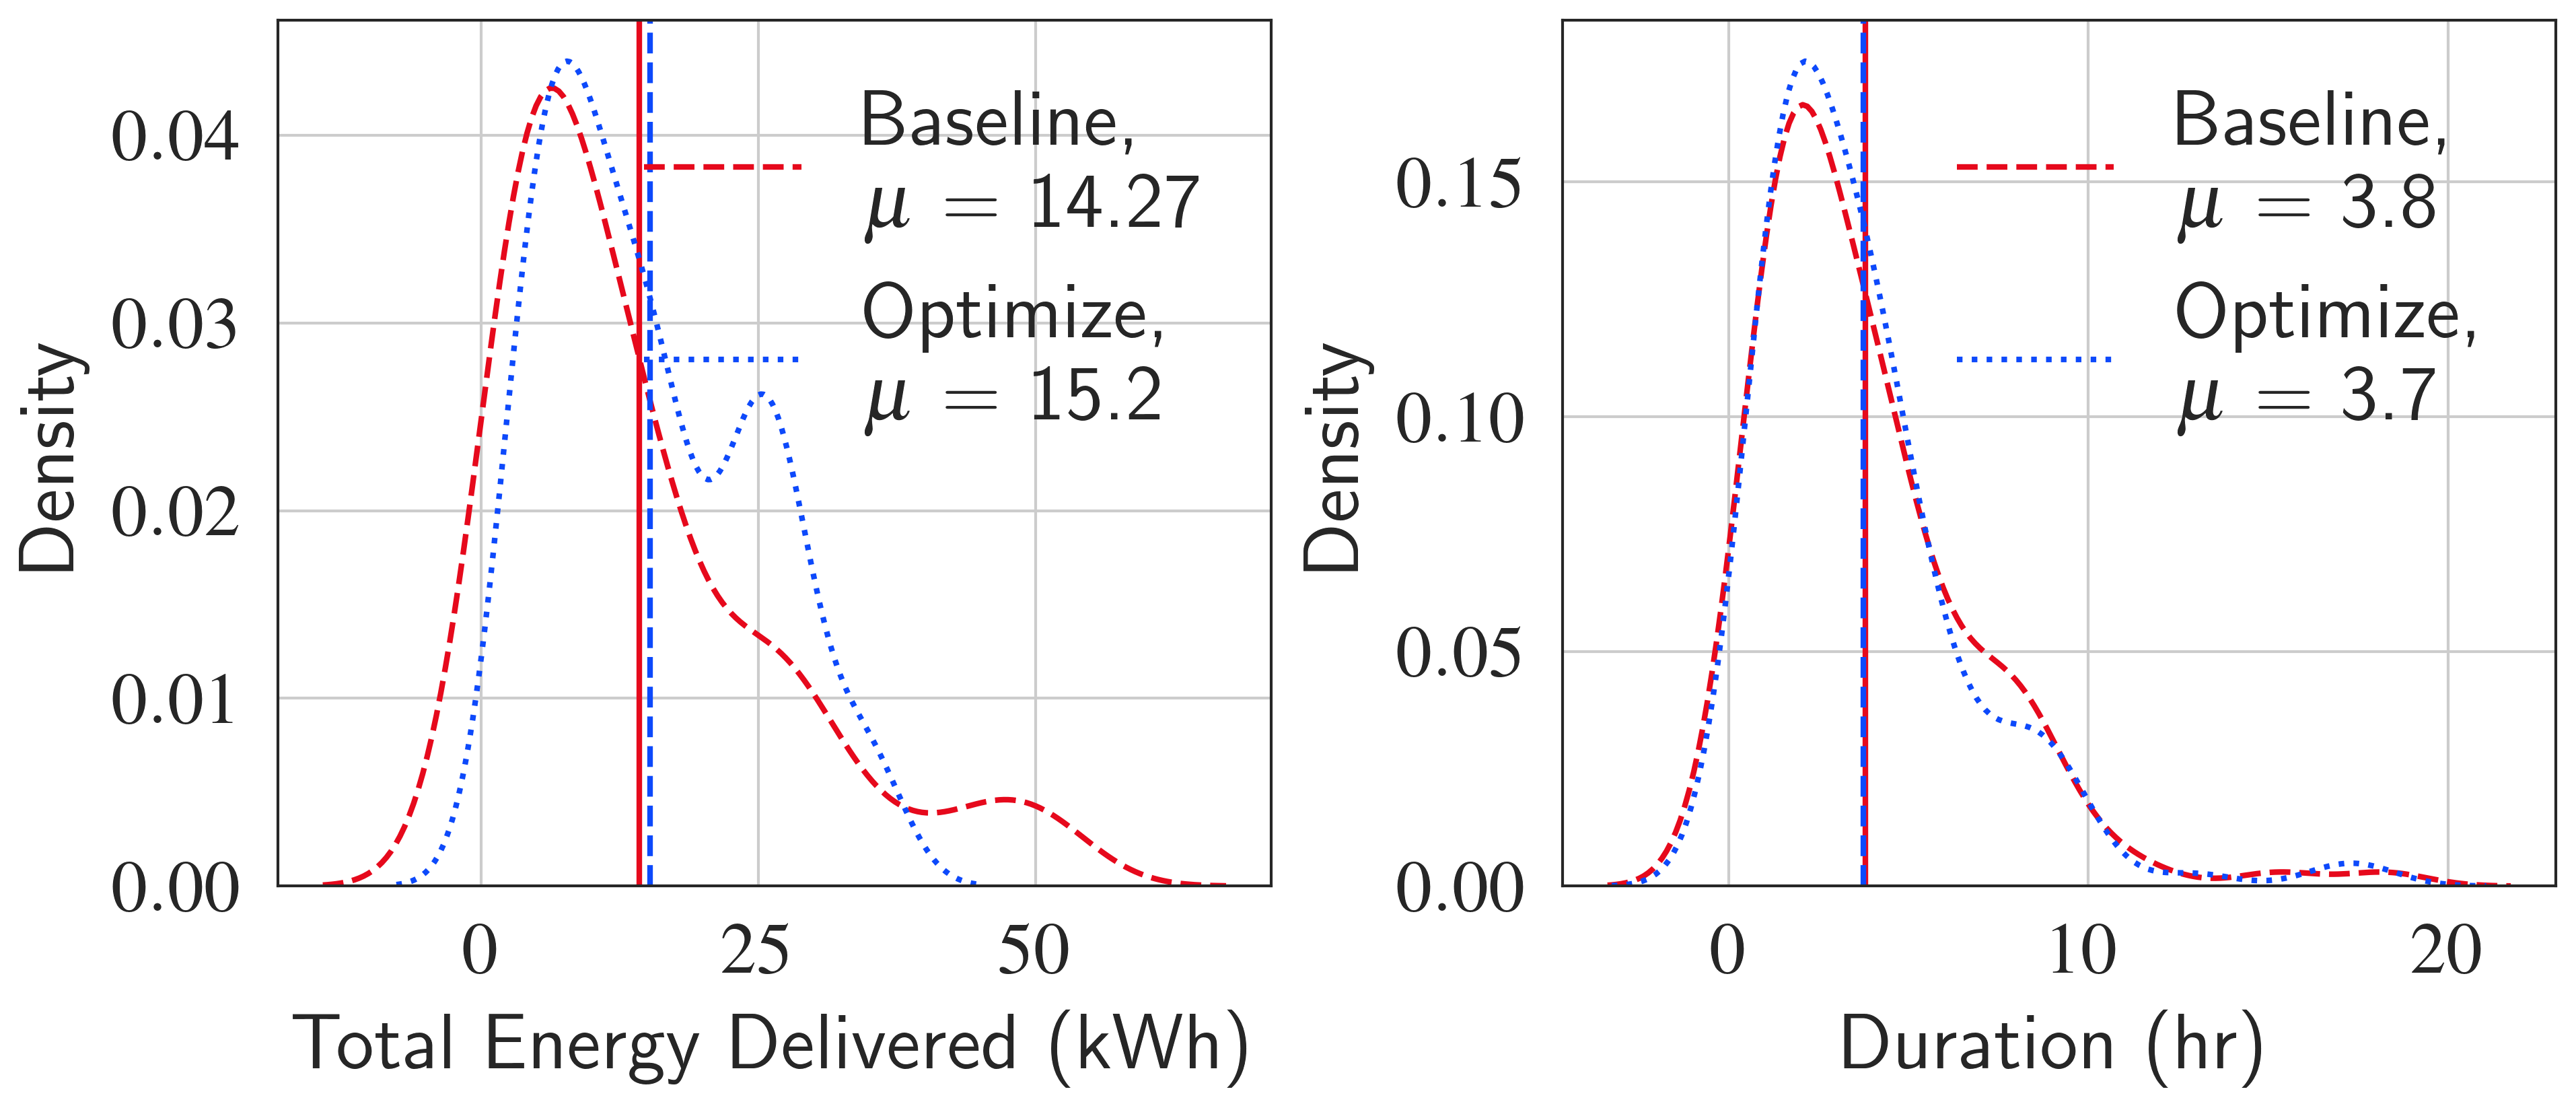

In [148]:
np.random.seed(0)
# sns.set_style("whitegrid")
sns.set_style("white")
fig,(ax,ax1) = plt.subplots(1,2,figsize=(w,h))
# ax=axes[0]

baseline = baseline.dropna(subset= ['Total Energy Delivered (kWh)']).sort_values(by='Total Energy Delivered (kWh)')

sns.kdeplot(baseline['Total Energy Delivered (kWh)'].dropna(),
            ax=ax, lw=1,
            color=high_vis_map[1], 
            label = 'Baseline,\n$\mu$ = {}'.format(np.round(baseline['Total Energy Delivered (kWh)'].mean(),2)))
ax.axvline(baseline['Total Energy Delivered (kWh)'].dropna().mean(), 
           linestyle="-", 
           
           color=high_vis_map[1])
ax.legend()
# ax1.set_xlabel('Net Revenue ($/kWh)')
print("baseline IRL", baseline['Total Energy Delivered (kWh)'].mean())
ax.grid(True)

# ax1=axes[1]

phaseIII = phaseIII.dropna(subset= ['Total Energy Delivered (kWh)']).sort_values(by='Total Energy Delivered (kWh)')

sns.kdeplot(phaseIII['Total Energy Delivered (kWh)'].dropna(),
            ax=ax,lw=1,
            color=high_vis_map[0], 
            label = 'Optimize,\n$\mu$ = {}'.format(np.round(phaseIII['Total Energy Delivered (kWh)'].mean(),1)))
ax.axvline(phaseIII['Total Energy Delivered (kWh)'].dropna().mean(), 
           linestyle="--",
           
           color=high_vis_map[0])
ax.legend()
# ax1.set_xlabel('Net Revenue ($/kWh)')
print("phaseIII IRL", phaseIII['Total Energy Delivered (kWh)'].mean())

baseline = baseline.dropna(subset= ['DurationHrs']).sort_values(by='DurationHrs')

sns.kdeplot(baseline['DurationHrs'].dropna(),
            ax=ax1,color=high_vis_map[1],lw=1,
            label = 'Baseline,\n$\mu$ = {}'.format(np.round(baseline['DurationHrs'].mean(),1)))
ax1.axvline(baseline['DurationHrs'].dropna().mean(), 
            
            color=high_vis_map[1], linestyle="-")
ax1.legend()
# ax11.set_xlabel('Net Revenue ($/kWh)')
print("baseline IRL", baseline['DurationHrs'].mean())
ax1.grid(True)

# ax11=ax1es[1]

phaseIII = phaseIII.dropna(subset= ['DurationHrs']).sort_values(by='DurationHrs')

sns.kdeplot(phaseIII['DurationHrs'].dropna(),
            ax=ax1,
            color=high_vis_map[0], 
            label = 'Optimize,\n$\mu$ = {}'.format(np.round(phaseIII['DurationHrs'].mean(),1)))
ax1.axvline(phaseIII['DurationHrs'].dropna().mean(),  linestyle="--", color=high_vis_map[0])
ax1.legend()
ax1.set_xlabel("Duration (hr)")
# ax11.set_xlabel('Net Revenue ($/kWh)')
print("phaseIII IRL", phaseIII['DurationHrs'].mean())
fig.savefig("Figures/distributions.pdf", transparent=True)


# plt.savefig("energy_delivered_distribution.pdf", transparent=True)

1.0

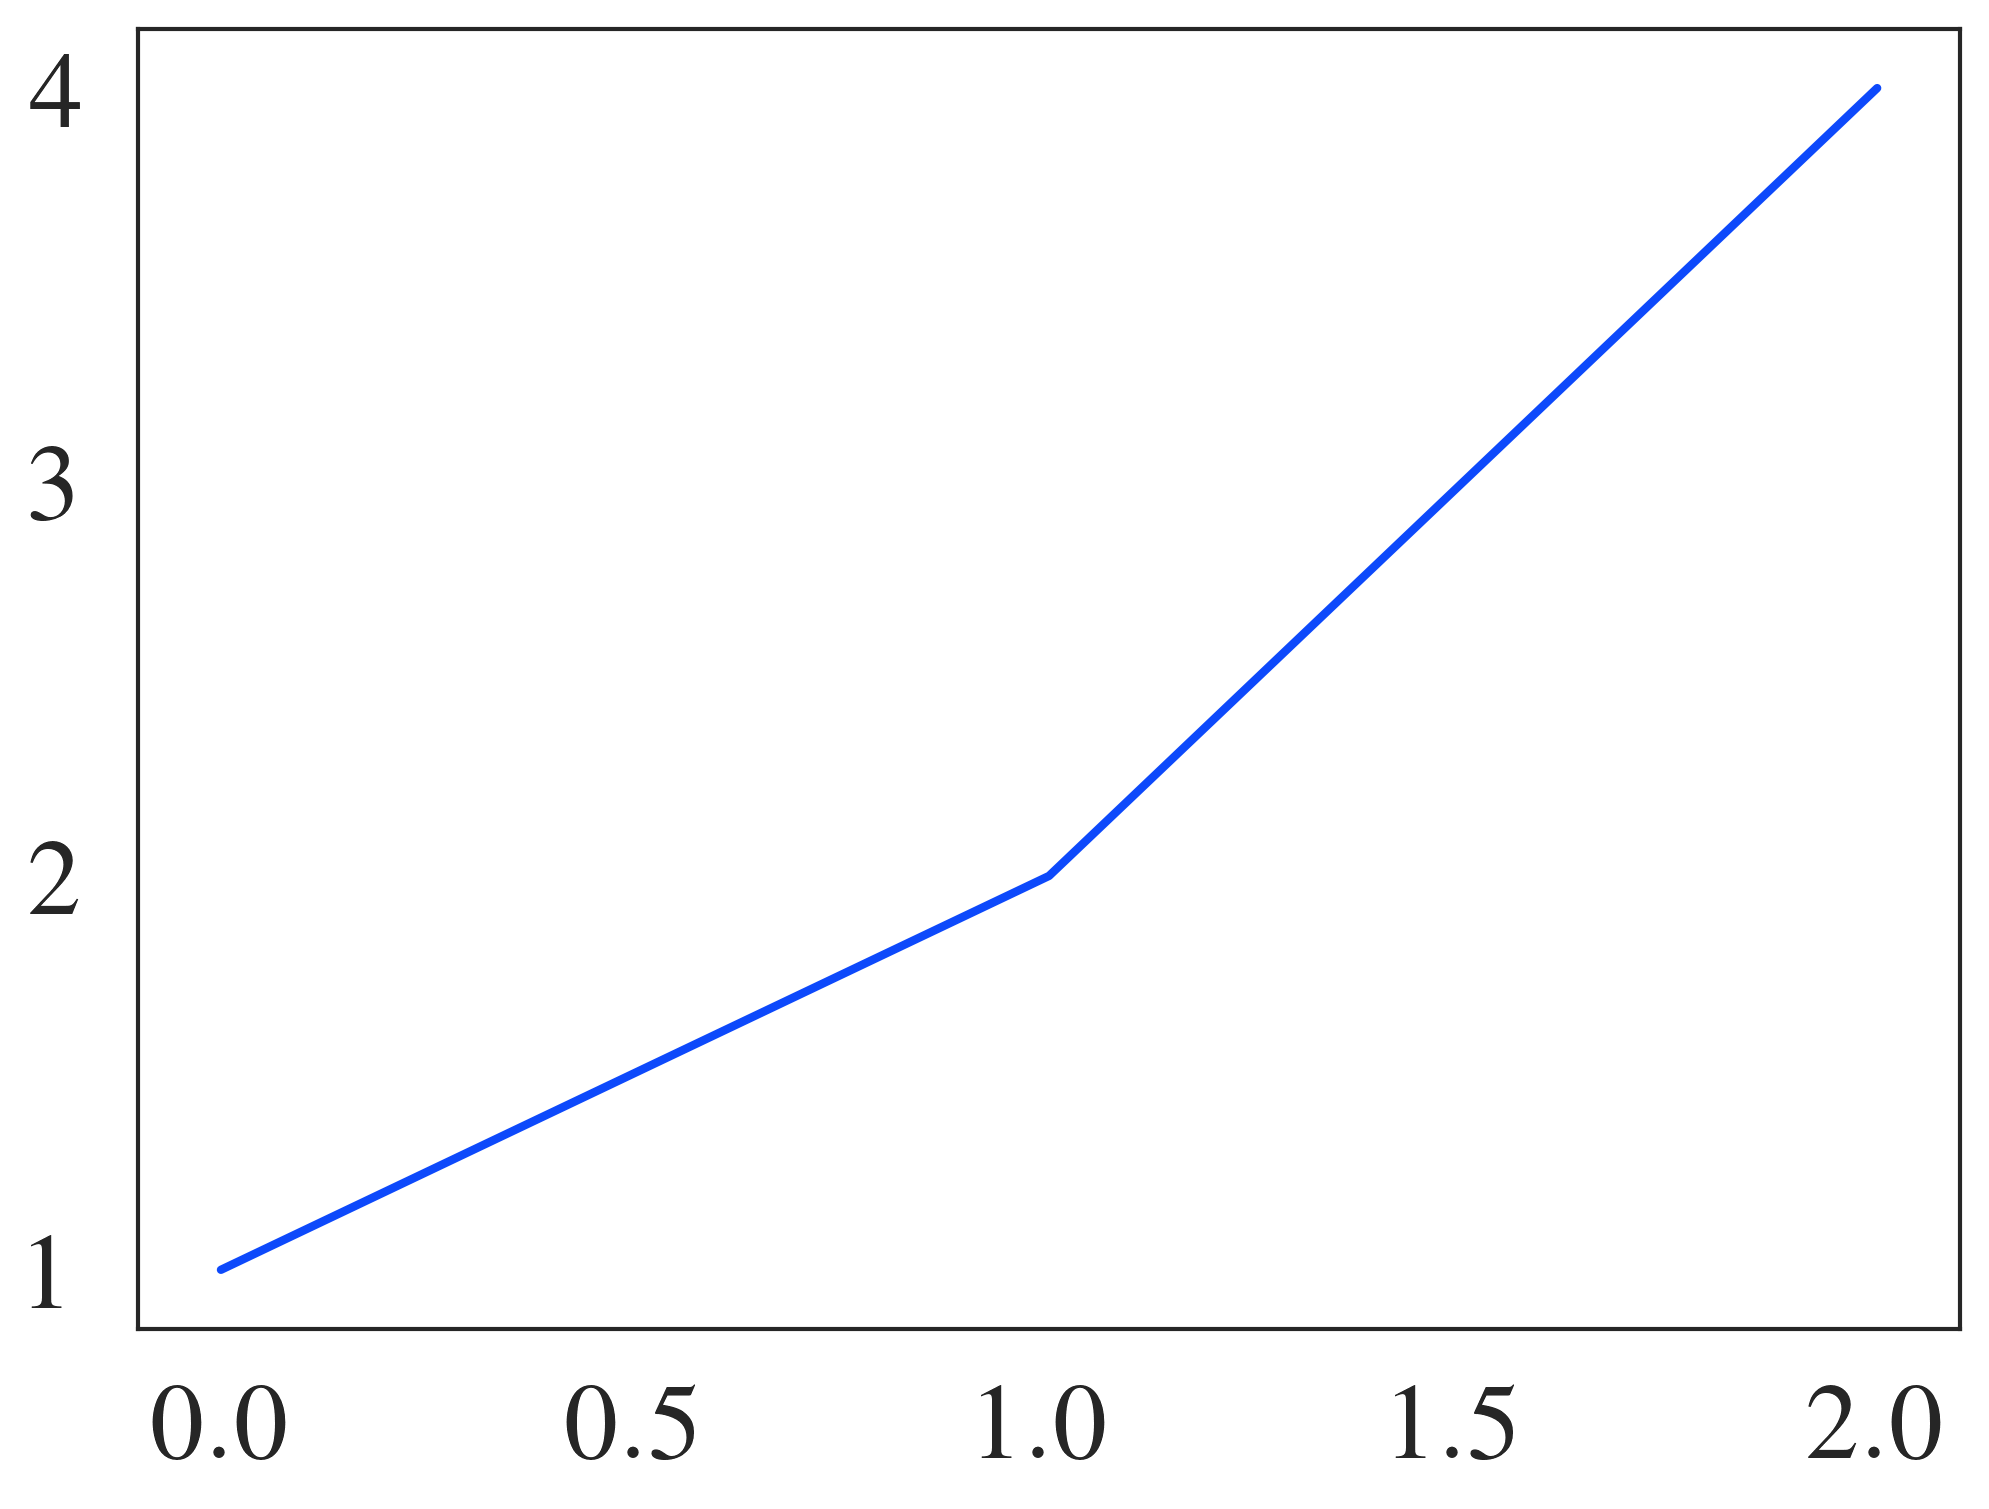

In [146]:
line, = plt.plot([1,2,4])
plt.getp(line, 'linewidth')

AttributeError: 'AxesSubplot' object has no attribute 'get_linewidth'

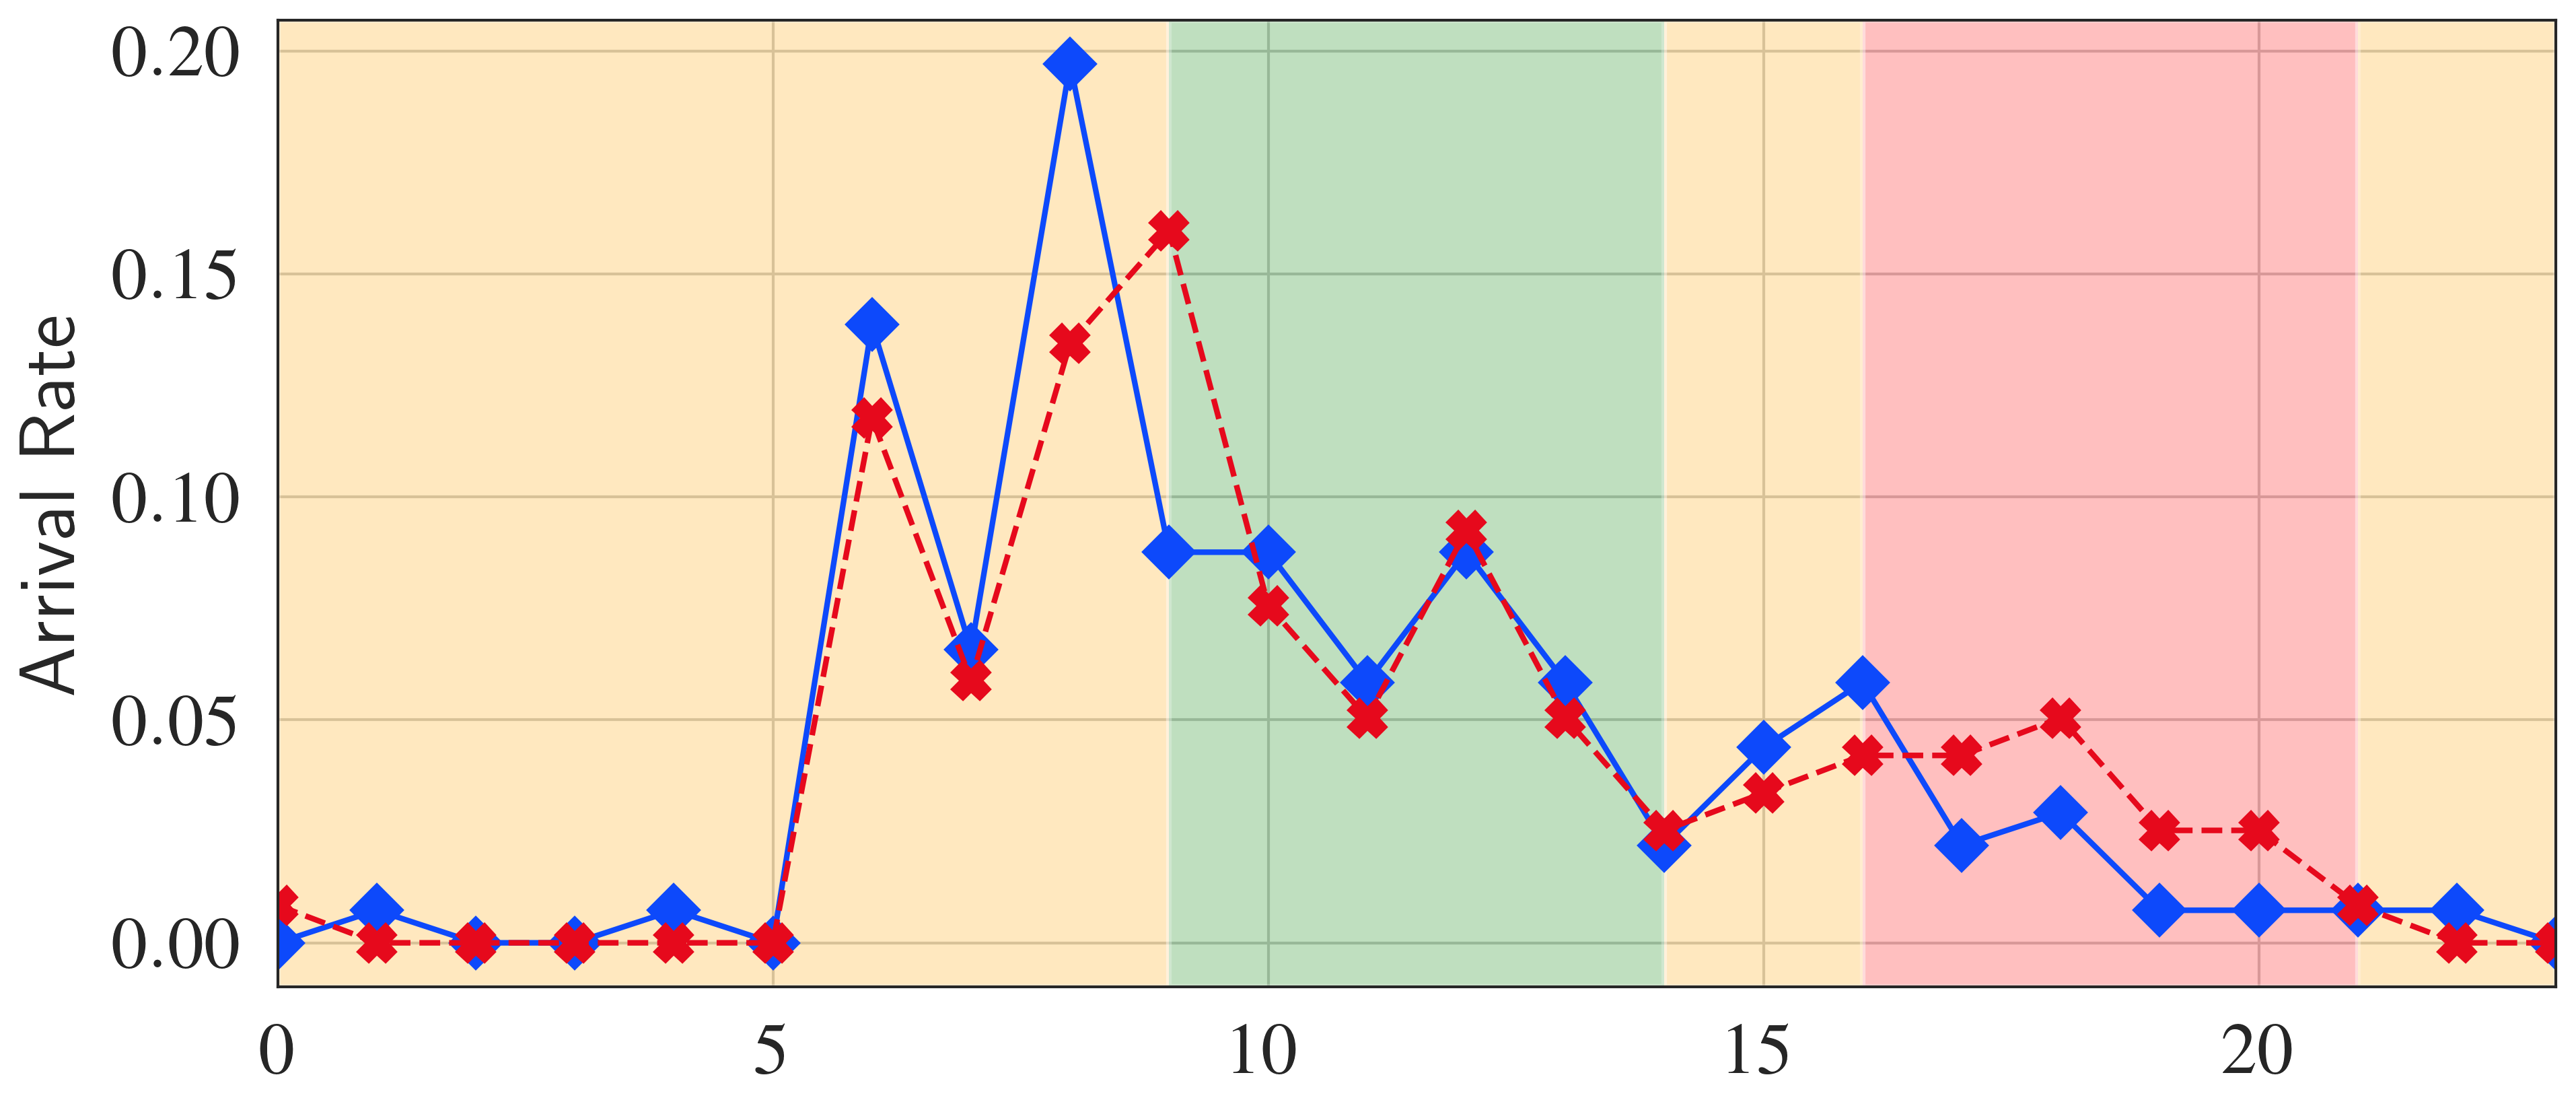

In [141]:


# As a function of Time
## Maybe normalize by the energy delivered
fig,ax = plt.subplots(1,1,figsize=(w,h), constrained_layout=True)

hour = np.arange(0,24)
p3_hourly_fraction = (phaseIII.groupby('ArrivalTime').count().reindex(np.arange(0,24), fill_value=0) / len(phaseIII))['choice']
base_hourly_fraction =(baseline.groupby('ArrivalTime').count().reindex(np.arange(0,24), fill_value=0) / len(baseline))['choice']
# baseline.groupby('ArrivalTime').count()

# hour = for 
# ax.scatter(hour, slack_time ,  s = duration *10,label = 'SCHEDULED, Slack Time')
ax.plot(hour, p3_hourly_fraction, '-',label = 'Optimize',marker = 'D')
ax.plot(hour, base_hourly_fraction, '--',label = 'Baseline',marker = 'X')

ax.set_ylabel("Arrival Rate")

ax.set_xlim(0,23)


ax.axvspan(16, 21, facecolor='red', alpha=0.25,label = 'Peak')
ax.axvspan(21, 23, facecolor='orange', alpha=0.25)
ax.axvspan(0, 9, facecolor='orange', alpha=0.25)
ax.axvspan(14, 16, facecolor='orange', alpha=0.25, label = 'Off-Peak')
ax.axvspan(9, 14, facecolor='g', alpha=0.25, label='Super Off-Peak')

ax.grid(True)


ax.set_xlabel("Arrival Hour")
ax.legend(bbox_to_anchor=(0.5, -0.40), loc='center', ncol=5,fontsize=10)
ax.set_xticks(np.arange(0,24,2))
fig.savefig("Figures/arrival_rates.pdf", transparent=True)


In [50]:
for row in list(phaseIII.index):
    if phaseIII.loc[row,'possible_maxChgRate_kW'] >=5:
        phaseIII.loc[row,'Level'] = "High"
    elif phaseIII.loc[row,'possible_maxChgRate_kW'] <5:
        phaseIII.loc[row,'Level'] = 'Low'

In [52]:
# plot_df = phaseIII[phaseIII['Level']=='High']
# plt.scatter(plot_df['reg_centsPerHr'], plot_df['reg_centsHr_sim'])
# plt.xlabel('reg_centsPerHr')
# plt.ylabel('reg_centsHr_sim')
# plt.xlim(120,280)
# plt.ylim(120,280)

In [53]:
# err = list(plot_df[(plot_df['reg_centsHr_sim'] - plot_df['reg_centsPerHr'] )  > 50].index)
# idx = plot_df[plot_df['vehicle_maxChgRate_kW'] < plot_df['peakPower_kW_irl']].index

In [55]:
# plot_df = phaseIII[phaseIII['Level']=='Low']
# plt.scatter(plot_df['reg_centsPerHr'], plot_df['reg_centsHr_sim'])

In [57]:
# err = list(plot_df[( - plot_df['reg_centsHr_sim'] + plot_df['reg_centsPerHr'] )  > 50].index)

/Users/aysetugbaozturk/miniconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


reg_centsPerHr  reg_centsHr_sim  possible_maxChgRate_kW  \
193           227.0       122.302942                   2.351   
115           229.0       123.741600                   3.459   
254           230.0       121.533897                   3.922   
3             229.0       123.741621                   3.459   
52            229.0       123.741635                   3.459   
143           229.0       123.741645                   3.459   
178           229.0       123.741563                   3.459   
74            229.0       123.741546                   3.459   
223           223.0       116.822896                   3.922   
248           228.0       121.484946                   3.922   

     peakPower_kW_irl  vehicle_maxChgRate_kW  
193             2.351                    8.0  
115             3.459                    8.8  
254             3.922                    7.0  
3               3.459                    8.8  
52              3.459                    8.8  
143             3.459                    8.8  
178             3.459                    8.8  
74              3.459                    8.8  
223             3.922                    7.0  
248             3.922                    7.0

ValueError: Could not interpret value `reg_centsHr_sim` for parameter `x`

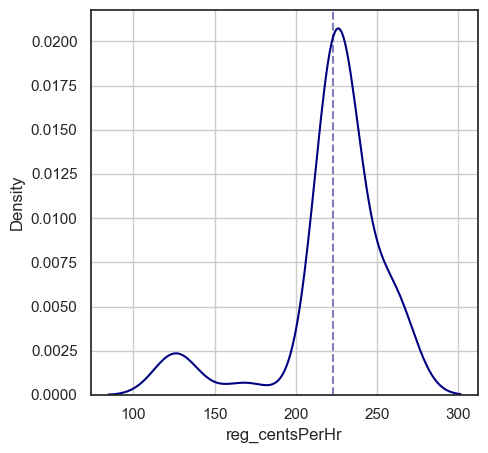

In [86]:
fig,(ax) = plt.subplots(1,1,figsize=(5,5))
plot_df = phaseIII[phaseIII['Level']=='High']
sns.kdeplot(data = plot_df,x='reg_centsPerHr',color='navy',label='Optimal Tariff, Expected')

ax.grid(True)

ax.axvline(plot_df['reg_centsPerHr'].mean(), linestyle="--", color ="navy",alpha=0.5)

sns.kdeplot(data = plot_df,x='reg_centsHr_sim',color='green',label='Optimal Tariff, Real Time')
ax.axvline(plot_df['reg_centsHr_sim'].mean(), linestyle="--", color ="green",alpha=0.5)
# print("phaseIII Virtual", phaseIII['Total Energy Delivered (kWh)'].mean())




# phaseIII = phaseIII.dropna(subset= ['cumEnergy_kWh']).sort_values(by='cumEnergy_kWh')

# sns.kdeplot(phaseIII['cumEnergy_kWh'].dropna(),ax=ax,color='green', label = 'IRL')
# ax.axvline(phaseIII['cumEnergy_kWh'].dropna().mean(), linestyle="--", color ="darkgreen")

# # ax1.set_xlabel('Net Revenue ($/kWh)')
# print("phaseIII IRL", phaseIII['cumEnergy_kWh'].mean())
ax.legend()

Reg 0.2784677419354837
Sch 0.4399193548387098
Leave 0.2788709677419355


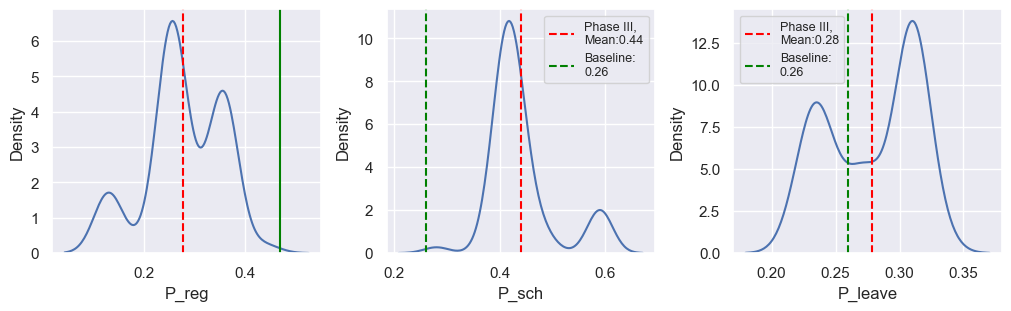

In [670]:
import seaborn as sns
sns.set_theme(); np.random.seed(0)
fig,(axes) = plt.subplots(1,3,figsize=(10,3))
ax=axes[0]

sns.kdeplot(phaseIII['P_reg'],ax=ax)
ax.axvline(baseline['P_reg'].dropna().mean(), color = 'green')
ax.axvline(phaseIII['P_reg'].mean(), linestyle="--", color ="red")
print("Reg", phaseIII['P_reg'].mean())
ax.grid(True)

ax1=axes[1]

phaseIII = phaseIII.dropna(subset= ['P_sch']).sort_values(by='P_sch')

sns.kdeplot(phaseIII['P_sch'].dropna(),ax=ax1)

# sns.kdeplot(baseline['P_sch'].dropna(),ax=ax1)

ax1.axvline(phaseIII['P_sch'].dropna().mean(), linestyle="--", color ="red", label = 'Phase III,\nMean:{}'.format(np.round(phaseIII['P_sch'].mean(),2)))
ax1.axvline(baseline['P_sch'].dropna().mean(), linestyle="--", color ="green",label = 'Baseline:\n{}'.format(np.round(baseline['P_sch'].mean(),2)))
ax1.legend(loc=1,fontsize=9)
print("Sch", phaseIII['P_sch'].mean())

ax2=axes[2]

phaseIII = phaseIII.dropna(subset= ['P_leave']).sort_values(by='P_leave')

sns.kdeplot(phaseIII['P_leave'].dropna(),ax=ax2)
ax2.axvline(phaseIII['P_leave'].dropna().mean(), linestyle="--", color ="red", label = 'Phase III,\nMean:{}'.format(np.round(phaseIII['P_leave'].mean(),2)))
ax2.axvline(baseline['P_leave'].dropna().mean(), linestyle="--", color ="green",label = 'Baseline:\n{}'.format(np.round(baseline['P_leave'].mean(),2)))
ax2.legend(loc=0,fontsize=9)
print("Leave", phaseIII['P_leave'].mean())


phaseIII 4.032585158150852
baseline 3.8932679738562093


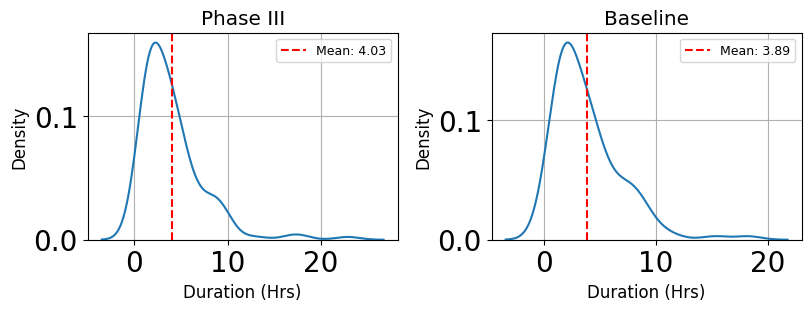

In [597]:
# import seaborn as sns
# sns.set_theme(); np.random.seed(0)
fig,(axes) = plt.subplots(1,2,figsize=(8,3))
ax=axes[0]

sns.kdeplot(data = phaseIII , x = 'connectedDuration_Hrs', ax=ax,common_norm=False, common_grid=True)

ax.axvline(phaseIII['connectedDuration_Hrs'].mean(), linestyle="--", color ="red", label = 'Mean: {}'.format(np.round(phaseIII['connectedDuration_Hrs'].mean(),2)))
print("phaseIII", phaseIII['connectedDuration_Hrs'].mean())
ax.set_xlabel('Duration (Hrs)')
ax.set_title('Phase III')
ax.legend(loc=1,fontsize=9)
ax.set_xticks(np.arange(0,30,10))

ax.grid(True)

ax1=axes[1]

baseline = baseline.dropna(subset= ['connectedDuration_Hrs']).sort_values(by='Total Energy Delivered (kWh)')

sns.kdeplot(data = baseline , x = 'connectedDuration_Hrs',common_norm=False, common_grid=True,ax=ax1)
ax1.axvline(baseline['connectedDuration_Hrs'].dropna().mean(), linestyle="--", color ="red",label = 'Mean: {}'.format(np.round(baseline['connectedDuration_Hrs'].mean(),2)))

print("baseline", baseline['connectedDuration_Hrs'].mean())
ax1.set_xlabel('Duration (Hrs)')
ax1.set_title('Baseline')
ax1.grid(True)
ax1.set_xticks(np.arange(0,30,10))
ax1.legend(loc=1,fontsize=9)

phaseIII 16.59993025547445
baseline 14.273304621848736


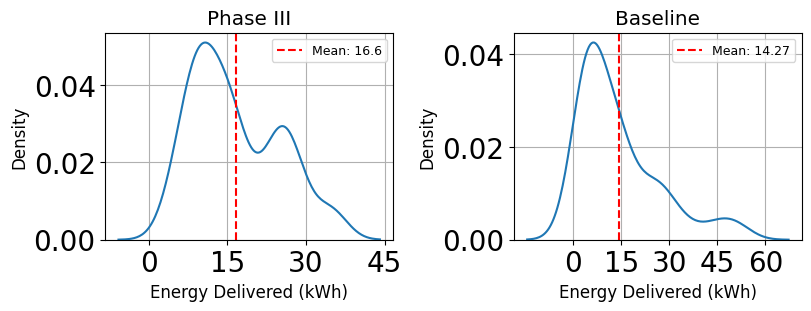

In [594]:
# import seaborn as sns
# sns.set_theme(); np.random.seed(0)
fig,(axes) = plt.subplots(1,2,figsize=(8,3))
ax=axes[0]

sns.kdeplot(data = phaseIII , x = 'Total Energy Delivered (kWh)', ax=ax,common_norm=False, common_grid=True)
ax.axvline(phaseIII['Total Energy Delivered (kWh)'].mean(), linestyle="--", color ="red", label = 'Mean: {}'.format(np.round(phaseIII['Total Energy Delivered (kWh)'].mean(),2)))
print("phaseIII", phaseIII['Total Energy Delivered (kWh)'].mean())
ax.set_xlabel('Energy Delivered (kWh)')
ax.set_title('Phase III')
ax.legend(loc=1,fontsize=9)
ax.set_xticks(np.arange(0,60,15))
ax.grid(True)

ax1=axes[1]

baseline = baseline.dropna(subset= ['Total Energy Delivered (kWh)']).sort_values(by='Total Energy Delivered (kWh)')

sns.kdeplot(data = baseline , x = 'Total Energy Delivered (kWh)',common_norm=False, common_grid=True,ax=ax1)
ax1.axvline(baseline['Total Energy Delivered (kWh)'].dropna().mean(), linestyle="--", color ="red", label = 'Mean: {}'.format(np.round(baseline['Total Energy Delivered (kWh)'].mean(),2)))
ax1.set_xlabel('Net Revenue ($/kWh)')
print("baseline", baseline['Total Energy Delivered (kWh)'].mean())
ax1.set_xlabel('Energy Delivered (kWh)')
ax1.set_title('Baseline')
ax1.grid(True)
ax1.set_xticks(np.arange(0,61,15))
ax1.legend(loc=1,fontsize=9)

phaseIII 39.351321630309556
baseline 43.28892686436079


Text(0.5, 0, 'Net Revenue ($/kWh)')

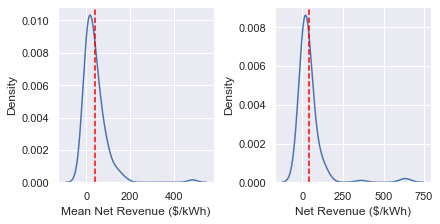

In [98]:
import seaborn as sns
sns.set_theme(); np.random.seed(0)
fig,(axes) = plt.subplots(1,2,figsize=(6,3))
ax=axes[0]

sns.kdeplot(phaseIII['Mean Net Revenue ($/kWh)'],ax=ax)
ax.axvline(phaseIII['Mean Net Revenue ($/kWh)'].mean(), linestyle="--", color ="red")
print("phaseIII", phaseIII['Mean Net Revenue ($/kWh)'].mean())
ax.grid(True)

ax1=axes[1]

baseline = baseline.dropna(subset= ['Mean Net Revenue ($/kWh)']).sort_values(by='Mean Net Revenue ($/kWh)')

sns.kdeplot(baseline['Mean Net Revenue ($/kWh)'].dropna(),ax=ax1)
ax1.axvline(baseline['Mean Net Revenue ($/kWh)'].dropna().mean(), linestyle="--", color ="red")

ax1.set_xlabel('Net Revenue ($/kWh)')
print("baseline", baseline['Mean Net Revenue ($/kWh)'].mean())
ax1.set_xlabel('Net Revenue ($/kWh)')

phaseIII 54.26297042748157
baseline 62.83639344403899


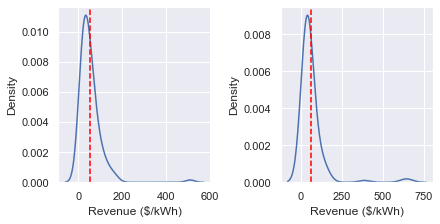

In [99]:
import seaborn as sns
sns.set_theme(); np.random.seed(0)
fig,(axes) = plt.subplots(1,2,figsize=(6,3))
ax=axes[0]

sns.kdeplot(phaseIII['Mean Revenue ($/kWh)'],ax=ax)
ax.axvline(phaseIII['Mean Revenue ($/kWh)'].mean(), linestyle="--", color ="red")
print("phaseIII", phaseIII['Mean Revenue ($/kWh)'].mean())
ax.grid(True)
ax.set_xlabel('Revenue ($/kWh)')
ax=axes[1]


sns.kdeplot(baseline['Mean Revenue ($/kWh)'].dropna(),ax=ax)
ax.axvline(baseline['Mean Revenue ($/kWh)'].dropna().mean(), linestyle="--", color ="red")
ax.set_xlabel('Revenue ($/kWh)')
print("baseline", baseline['Mean Revenue ($/kWh)'].mean())

phaseIII 18.657094003894976
baseline 16.914471789771405


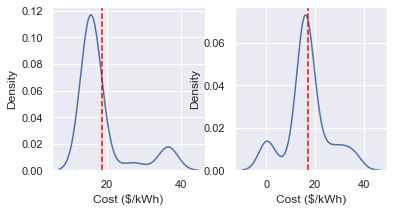

In [418]:
import seaborn as sns
sns.set_theme(); np.random.seed(0)
fig,(axes) = plt.subplots(1,2,figsize=(6,3))
ax=axes[0]

sns.kdeplot(phaseIII['Mean Cost ($/kWh)'],ax=ax)
ax.axvline(phaseIII['Mean Cost ($/kWh)'].mean(), linestyle="--", color ="red")
print("phaseIII", phaseIII['Mean Cost ($/kWh)'].mean())
ax.grid(True)
ax.set_xlabel('Cost ($/kWh)')
ax1=axes[1]


sns.kdeplot(baseline['Mean Cost ($/kWh)'].dropna(),ax=ax1)
ax1.axvline(baseline['Mean Cost ($/kWh)'].dropna().mean(), linestyle="--", color ="red")
ax1.set_xlabel('Cost ($/kWh)')
print("baseline", baseline['Mean Cost ($/kWh)'].mean())

phaseIII 1.4447522816174392
baseline 1.7044737334018185


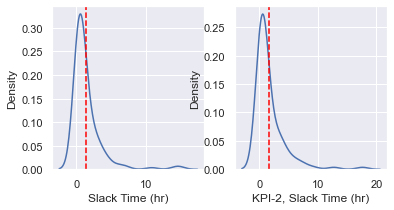

In [428]:
import seaborn as sns
sns.set_theme(); np.random.seed(0)
fig,(axes) = plt.subplots(1,2,figsize=(6,3))
ax=axes[0]

sns.kdeplot(phaseIII['KPI-2, Slack Time (hr)'],ax=ax)
ax.axvline(phaseIII['KPI-2, Slack Time (hr)'].mean(), linestyle="--", color ="red")
print("phaseIII", phaseIII['KPI-2, Slack Time (hr)'].mean())
ax.grid(True)
ax.set_xlabel('Slack Time (hr)')
ax1=axes[1]


sns.kdeplot(baseline['KPI-2, Slack Time (hr)'].dropna(),ax=ax1)
ax1.axvline(baseline['KPI-2, Slack Time (hr)'].dropna().mean(), linestyle="--", color ="red")
ax1.set_xlabel('KPI-2, Slack Time (hr)')
print("baseline", baseline['KPI-2, Slack Time (hr)'].mean())

phaseIII 18.657094003894976
baseline 16.914471789771405


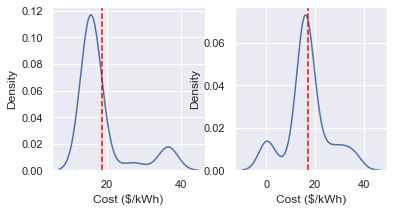

In [429]:
import seaborn as sns
sns.set_theme(); np.random.seed(0)
fig,(axes) = plt.subplots(1,2,figsize=(6,3))
ax=axes[0]

sns.kdeplot(phaseIII['Mean Cost ($/kWh)'],ax=ax)
ax.axvline(phaseIII['Mean Cost ($/kWh)'].mean(), linestyle="--", color ="red")
print("phaseIII", phaseIII['Mean Cost ($/kWh)'].mean())
ax.grid(True)
ax.set_xlabel('Cost ($/kWh)')
ax1=axes[1]

sns.kdeplot(baseline['Mean Cost ($/kWh)'].dropna(),ax=ax1)
ax1.axvline(baseline['Mean Cost ($/kWh)'].dropna().mean(), linestyle="--", color ="red")
ax1.set_xlabel('Cost ($/kWh)')
print("baseline", baseline['Mean Cost ($/kWh)'].mean())

In [87]:
bs = pd.DataFrame(data = {"Test":['Baseline', 'Baseline'], 
                    "Choice":["Regular","Scheduled"], 
                    "Count":[baseline['regular'].sum(), baseline['scheduled'].sum()]})
phs = pd.DataFrame(data = {"Test":['Phase III', 'Phase III'], 
                    "Choice":["Regular","Scheduled"], 
                    "Count":[phaseIII['regular'].sum(), phaseIII['scheduled'].sum()]})                    

dd = pd.concat([bs,phs])

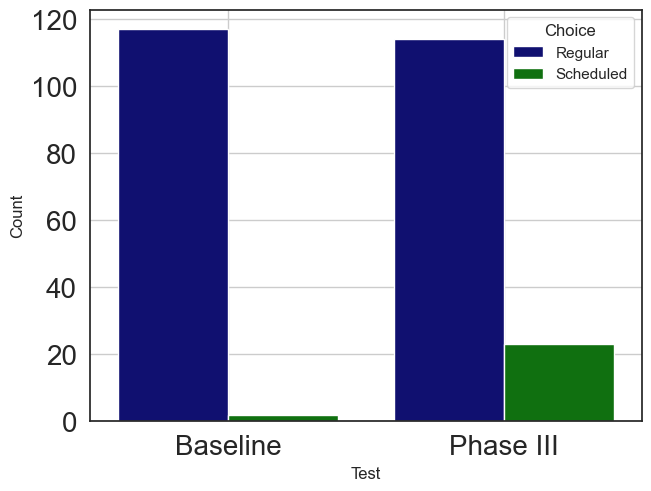

In [90]:

plt.rcParams['figure.constrained_layout.use'] = True
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
matplotlib.rcParams.update({'font.size': 12})
ax = sns.barplot(x='Test', y='Count', hue = 'Choice',data = dd, palette=["navy","green"])
ax.grid()

plt.savefig("number_of_sessions.pdf", transparent=True)

In [186]:
phaseIII.columns

Index(['dcosId', 'choice', 'connectTime', 'cumEnergy_Wh', 'Deadline',
       'defaultDeadline', 'Duration', 'DurationHrs', 'energyReq_Wh', 'estCost',
       'lastUpdate', 'peakPower_W', 'power', 'reg_centsPerHr', 'regular',
       'sch_centsPerHr', 'sch_centsPerKwh', 'sch_centsPerOverstayHr',
       'scheduled', 'siteId', 'startChargeTime', 'stationId', 'userId',
       'vehicle_maxChgRate_W', 'vehicle_model', 'timeToStart (s)',
       'Charging Cost (cents)', 'Charging Revenue (cents)',
       'Total Energy Delivered (kWh)', 'connectedDuration_Hrs', 'P_sch',
       'P_reg', 'P_leave', 'Overstay (hr)', 'Overstay Penalty (cents)',
       'vehicle_maxChgRate_kW', 'peakPower_kW', 'station_maxChgRate_kW',
       'inferred_vehicle_maxChgRate_kW', 'possible_maxChgRate_kW',
       'KPI-1, Net Revenue', 'KPI-2, Slack Time (hr)', 'Level', 'date',
       'p_sch / p_reg'],
      dtype='object')

# Control Effort vs Result

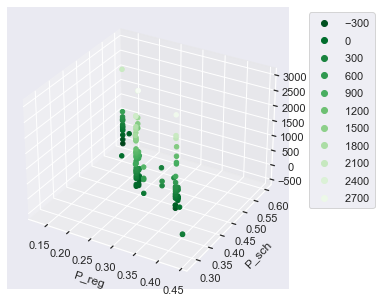

In [265]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
subplot_kw={"projection": "3d"}
# Make data.
X = phaseIII['P_reg'].values
Y = phaseIII['P_sch'].values


Z = phaseIII['KPI-1, Net Revenue'].values
# fig = plt.figure()
# p = ax.scatter3D(X, Y, Z, c=Z, cmap='Greens_r')
sc = ax.scatter(X, Y, Z, c=Z, marker='o', cmap='Greens_r', alpha=1)
ax.set_xlabel('P_reg')
ax.set_ylabel('P_sch')
# ax.set_zlabel('J')
# ax.set_xlim(60,190)
# ax.set_ylim(60,190)
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

In [247]:
# pd.concat([df_plot,temp]).columns

In [248]:
df_plot = phaseIII.groupby(['P_reg','P_sch','choice']).count()/ phaseIII.groupby(['P_reg','P_sch']).count()
df_plot = df_plot.drop(columns='choice').reset_index(drop=False)[['P_reg','P_sch',
                                                                  'choice',
                                                                  'Charging Cost (cents)']].rename(columns = {'Charging Cost (cents)':'Empirical P'})

temp = df_plot[(df_plot['Empirical P']==1) & (df_plot['choice']=='REGULAR') ].copy()
temp['choice'] = 'SCHEDULED'
temp['Empirical P'] = 0
df_plot = pd.concat([df_plot,temp]).sort_values(['P_reg','P_sch']).reset_index(drop=True)

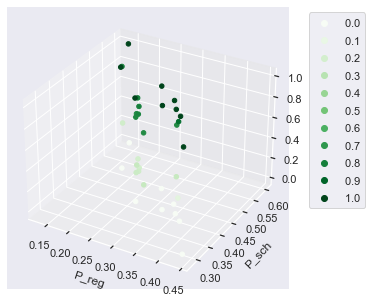

In [264]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = df_plot['P_reg'].values
Y = df_plot['P_sch'].values


Z = df_plot['Empirical P'].values
# fig = plt.figure()
# p = ax.scatter3D(X, Y, Z, c=Z, cmap='Greens_r')
sc = ax.scatter(X, Y, Z, c =Z,  marker='o', cmap='Greens', alpha=1)
ax.set_xlabel('P_reg')
ax.set_ylabel('P_sch')
# ax.set_zlabel('J')
# ax.set_xlim(60,190)
# ax.set_ylim(60,190)
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

In [231]:
phaseIII['p_sch / p_reg'] = np.round(phaseIII['P_sch'] / phaseIII['P_reg'] ,2 )
df_plot = phaseIII.groupby(['p_sch / p_reg','choice']).count()/ phaseIII.groupby(['p_sch / p_reg']).count()
df_plot = df_plot.drop(columns='choice').reset_index(drop=False)[['p_sch / p_reg',
                                                                  'choice',
                                                                  'Charging Cost (cents)']].rename(columns = {'Charging Cost (cents)':'Empirical P'})

temp = df_plot[(df_plot['Empirical P']==1) & (df_plot['choice']=='REGULAR') ].copy()
temp['choice'] = 'SCHEDULED'
temp['Empirical P'] = 0
df_plot = pd.concat([df_plot,temp]).sort_values('p_sch / p_reg').reset_index(drop=True)

In [270]:
phaseIII.columns

Index(['dcosId', 'choice', 'connectTime', 'cumEnergy_Wh', 'Deadline',
       'defaultDeadline', 'Duration', 'DurationHrs', 'energyReq_Wh', 'estCost',
       'lastUpdate', 'peakPower_W', 'power', 'reg_centsPerHr', 'regular',
       'sch_centsPerHr', 'sch_centsPerKwh', 'sch_centsPerOverstayHr',
       'scheduled', 'siteId', 'startChargeTime', 'stationId', 'userId',
       'vehicle_maxChgRate_W', 'vehicle_model', 'timeToStart (s)',
       'Charging Cost (cents)', 'Charging Revenue (cents)',
       'Total Energy Delivered (kWh)', 'connectedDuration_Hrs', 'P_sch',
       'P_reg', 'P_leave', 'Overstay (hr)', 'Overstay Penalty (cents)',
       'vehicle_maxChgRate_kW', 'peakPower_kW', 'station_maxChgRate_kW',
       'inferred_vehicle_maxChgRate_kW', 'possible_maxChgRate_kW',
       'KPI-1, Net Revenue', 'KPI-2, Slack Time (hr)', 'p_sch / p_reg'],
      dtype='object')

In [272]:
phaseIII.groupby(["P_sch",'choice',"sch_centsPerHr","reg_centsPerHr"]).count()

dcosId  connectTime  \
P_sch choice    sch_centsPerHr reg_centsPerHr                        
0.28  REGULAR   206.0          164.0                2            2   
0.38  REGULAR   156.0          137.0                1            1   
                232.0          226.0                3            3   
      SCHEDULED 232.0          226.0                1            1   
0.40  REGULAR   140.0          127.0                7            7   
                142.0          129.0                5            5   
                144.0          131.0                5            5   
                148.0          134.0                2            2   
                178.0          169.0                2            2   
                227.0          230.0                2            2   
0.41  REGULAR   138.0          127.0                1            1   
                140.0          128.0                3            3   
                143.0          132.0                9            9   
      SCHEDULED 143.0          132.0                2            2   
0.42  REGULAR   216.0          223.0               13           13   
                219.0          227.0                7            7   
      SCHEDULED 216.0          223.0                6            6   
0.43  REGULAR   131.0          125.0                1            1   
                218.0          228.0                7            7   
      SCHEDULED 218.0          228.0                2            2   
0.44  REGULAR   127.0          123.0                2            2   
                129.0          125.0                1            1   
                216.0          227.0                5            5   
                217.0          229.0                4            4   
      SCHEDULED 129.0          125.0                1            1   
                217.0          229.0                3            3   
0.45  REGULAR   213.0          227.0                4            4   
      SCHEDULED 213.0          227.0                1            1   
0.47  REGULAR   148.0          156.0                1            1   
0.48  REGULAR   200.0          222.0                1            1   
      SCHEDULED 200.0          222.0                4            4   
0.50  REGULAR   225.0          261.0                1            1   
0.59  REGULAR   198.0          260.0                8            8   
                               261.0                3            3   
      SCHEDULED 198.0          260.0                3            3   
0.60  REGULAR   185.0          246.0                1            1   

                                               cumEnergy_Wh  Deadline  \
P_sch choice    sch_centsPerHr reg_centsPerHr                           
0.28  REGULAR   206.0          164.0                      2         0   
0.38  REGULAR   156.0          137.0                      1         0   
                232.0          226.0                      3         0   
      SCHEDULED 232.0          226.0                      1         1   
0.40  REGULAR   140.0          127.0                      7         0   
                142.0          129.0                      5         0   
                144.0          131.0                      5         0   
                148.0          134.0                      2         0   
                178.0          169.0                      2         0   
                227.0          230.0                      2         0   
0.41  REGULAR   138.0          127.0                      1         0   
                140.0          128.0                      3         0   
                143.0          132.0                      9         0   
      SCHEDULED 143.0          132.0                      2         2   
0.42  REGULAR   216.0          223.0                     13         0   
                219.0          227.0                      7         0   
      SCHEDULED 216.0          223.0                      6         6   

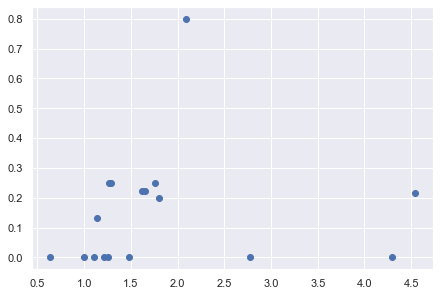

In [232]:
fig, ax = plt.subplots()

X = df_plot[df_plot['choice']=='SCHEDULED'][['p_sch / p_reg']].values
Y = df_plot[df_plot['choice']=='SCHEDULED']['Empirical P'].values


# Z = phaseIII['KPI-1, Net Revenue'].values
# # fig = plt.figure()
# # p = ax.scatter3D(X, Y, Z, c=Z, cmap='Greens_r')
sc = ax.scatter(X, Y)

dcosId  connectTime  cumEnergy_Wh  Deadline  \
P_reg P_sch choice                                                   
0.13  0.59  REGULAR        11           11            11         0   
            SCHEDULED       3            3             3         3   
0.14  0.60  REGULAR         1            1             1         0   
0.18  0.50  REGULAR         1            1             1         0   
0.23  0.48  REGULAR         1            1             1         0   
            SCHEDULED       4            4             4         4   
0.25  0.44  REGULAR         9            9             9         0   
            SCHEDULED       3            3             3         3   
      0.45  REGULAR         4            4             4         0   
            SCHEDULED       1            1             1         1   
0.26  0.42  REGULAR        20           20            20         0   
            SCHEDULED       6            6             6         6   
      0.43  REGULAR         7            7             7         0   
            SCHEDULED       2            2             2         2   
0.27  0.40  REGULAR         2            2             2         0   
0.29  0.47  REGULAR         1            1             1         0   
0.30  0.38  REGULAR         3            3             3         0   
            SCHEDULED       1            1             1         1   
0.33  0.40  REGULAR         2            2             2         0   
0.34  0.43  REGULAR         1            1             1         0   
      0.44  REGULAR         3            3             3         0   
            SCHEDULED       1            1             1         1   
0.36  0.40  REGULAR        19           19            19         0   
      0.41  REGULAR        13           13            13         0   
            SCHEDULED       2            2             2         2   
0.38  0.38  REGULAR         1            1             1         0   
0.44  0.28  REGULAR         2            2             2         0   

                       defaultDeadline  Duration  DurationHrs  energyReq_Wh  \
P_reg P_sch choice                                                            
0.13  0.59  REGULAR                 11        11           11             0   
            SCHEDULED                3         3            3             3   
0.14  0.60  REGULAR                  1         1            1             0   
0.18  0.50  REGULAR                  1         1            1             0   
0.23  0.48  REGULAR                  1         1            1             0   
            SCHEDULED                4         4            4             4   
0.25  0.44  REGULAR                  9         9            9             0   
            SCHEDULED                3         3            3             3   
      0.45  REGULAR                  4         4            4             0   
            SCHEDULED                1         1            1             1   
0.26  0.42  REGULAR                 20        20           20             0   
            SCHEDULED                6         6            6             6   
      0.43  REGULAR                  7         7            7             0   
            SCHEDULED                2         2            2             2   
0.27  0.40  REGULAR                  2         2            2             0   
0.29  0.47  REGULAR                  1         1            1             0   
0.30  0.38  REGULAR                  3         3            3             0   
            SCHEDULED                1         1            1             1   
0.33  0.40  REGULAR                  2         2            2             0   
0.34  0.43  REGULAR                  1         1            1             0   
      0.44  REGULAR                  3         3            3             0   
            SCHEDULED                1         1            1             1   
0.36  0.40  REGULAR                 19        19           19             0   
      0.41  REGUL

In [ ]:
phaseIII['P_reg','P_reg']